<a href="https://colab.research.google.com/github/Deadline430/OL_Report_2025/blob/main/OL_HotelBooking_P3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Prepare the packages for this project



In [11]:
cd /content/drive/MyDrive/CS Master 2025/CS7641 Machine Learning/OL Report/OL_REPORT

/content/drive/MyDrive/CS Master 2025/CS7641 Machine Learning/OL Report/OL_REPORT


In [12]:
# --- Installation Commands ---
# Run these commands if you don't have the necessary packages installed in your environment.
!pip install torch torchvision torchaudio torchmetrics mlrose-hiive optuna resource memory_profiler psutil tensorflow --quiet
!pip install pandas numpy scikit-learn imbalanced-learn matplotlib plotly seaborn polars --quiet

# --- Import Required Libraries ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, learning_curve, validation_curve, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay
from sklearn.metrics import f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, precision_recall_curve, auc
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy.stats import pointbiserialr
import time
import platform
import psutil
import resource
import torch
import memory_profiler
import tensorflow as tf # Import tensorflow


print("\n--- Environment Information ---")
print(f"Python Version: {platform.python_version()}")
print(f"System: {platform.system()} {platform.release()}")
print(f"Processor: {platform.processor()}")
print(f"Total RAM: {round(psutil.virtual_memory().total / (1024**3), 2)} GB")
print(f"TensorFlow Version: {tf.__version__}") # Print TensorFlow version


--- Environment Information ---
Python Version: 3.12.11
System: Linux 6.6.97+
Processor: x86_64
Total RAM: 50.99 GB
TensorFlow Version: 2.19.0


In [13]:
import os, random, numpy as np, torch
import json # Import json for saving the registry

def set_seed(s=4242):
    random.seed(s); np.random.seed(s); torch.manual_seed(s); torch.cuda.manual_seed_all(s)
    torch.backends.cudnn.deterministic = True; torch.backends.cudnn.benchmark = False

# Set the global seed
global_seed = 4242
set_seed(global_seed)

# Record device information
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Initialize seed registry with the global seed
seed_registry = {
    'global_seed': global_seed,
    'part_seeds': {} # Dictionary to store seeds for each part
}

# Plan for seeds in Parts 1-3:
# Use 3-5 seeds minimum for stability. Log median ± IQR for metrics.
# For Part 1, a single trained checkpoint can be reused, varying Randomized Optimization (RO) seeds.
# Seeds for each part will be added to the 'part_seeds' dictionary as they are defined.

# Example of how you might add seeds for Part 1 (to be finalized later)
# part1_seeds = [101, 102, 103] # Example seeds for Part 1
# seed_registry['part_seeds']['Part 1'] = part1_seeds

# Example of how you might save the registry later (e.g., at the end of the notebook or after defining seeds for each part)
# seed_registry_path = 'seed_registry.json'
# with open(seed_registry_path, 'w') as f:
#     json.dump(seed_registry, f, indent=4)
# print(f"\nSeed registry saved to {seed_registry_path}")

Using device: cuda


In [14]:
import os
import csv
import time
import resource # To track resource usage (optional, but good for compute accounting)
import psutil # To track resource usage (optional)
import json # Import json for saving the registry

# Define the logging directory and file
log_dir = 'logs'
log_file = os.path.join(log_dir, 'hotelbooking_log.csv')

# Create the logging directory if it doesn't exist
os.makedirs(log_dir, exist_ok=True)

# Define the CSV header
header = [
    'dataset',
    'part',
    'method',
    'seed(s)',
    'split',
    'loss/metrics',
    'gradient_evals',
    'function_evals',
    'wall_clock_time_s',
    'optimizer_settings',
    'regularizer_settings',
    'RO_settings',
    'checkpoint_path',
    'checkpoint_hash',
    'compute_accounting' # Placeholder for more detailed compute tracking if needed
]

# Check if the log file exists and write the header if it doesn't
if not os.path.exists(log_file):
    with open(log_file, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(header)

def log_experiment_result(dataset, part, method, seeds, split, metrics, gradient_evals, function_evals, wall_clock_time_s, optimizer_settings, regularizer_settings, RO_settings, checkpoint_path, checkpoint_hash, compute_accounting=''):
    """
    Appends a row to the experiment log CSV file.

    Args:
        dataset (str): Name of the dataset.
        part (str): The part of the project (e.g., 'Part 1', 'Part 2').
        method (str): The method or model used (e.g., 'Decision Tree', 'Shallow-Wide NN').
        seeds (str): Seed(s) used for the experiment.
        split (str): The data split the metrics are from (e.g., 'train', 'test', 'validation').
        metrics (dict): A dictionary of metric names and their values.
        gradient_evals (int): Number of gradient evaluations.
        function_evals (int): Number of function evaluations.
        wall_clock_time_s (float): Wall-clock time in seconds.
        optimizer_settings (str): String representation of optimizer settings.
        regularizer_settings (str): String representation of regularizer settings.
        RO_settings (str): String representation of Randomized Optimization settings.
        checkpoint_path (str): Path to the model checkpoint.
        checkpoint_hash (str): Hash of the model checkpoint.
        compute_accounting (str): Placeholder for detailed compute accounting.
    """
    # Convert metrics dictionary to a string representation
    metrics_str = json.dumps(metrics)

    # Prepare the row data
    row_data = [
        dataset,
        part,
        method,
        seeds,
        split,
        metrics_str,
        gradient_evals,
        function_evals,
        wall_clock_time_s,
        optimizer_settings,
        regularizer_settings,
        RO_settings,
        checkpoint_path,
        checkpoint_hash,
        compute_accounting
    ]

    # Append the row to the CSV file
    with open(log_file, 'a', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(row_data)

    print(f"Logged experiment result for dataset='{dataset}', method='{method}', split='{split}'")

# Placeholder for compute accounting functions
def get_process_memory_usage_gb():
    """Get current process memory usage in GB."""
    process = psutil.Process(os.getpid())
    return process.memory_info().rss / (1024**3)

def get_total_memory_gb():
    """Get total system memory in GB."""
    return psutil.virtual_memory().total / (1024**3)

def get_cpu_usage():
    """Get current CPU usage percentage."""
    return psutil.cpu_percent(interval=1) # interval for sampling


# Initialize counters and timers (will need to be updated during training/evaluation)
gradient_evals_counter = 0
function_evals_counter = 0
start_time = 0

def start_timer():
    global start_time
    start_time = time.time()

def stop_timer():
    global start_time
    end_time = time.time()
    return end_time - start_time

def increment_gradient_evals(count=1):
    global gradient_evals_counter
    gradient_evals_counter += count

def increment_function_evals(count=1):
    global function_evals_counter
    function_evals_counter += count


print(f"Logging infrastructure set up. Log file: {log_file}")

Logging infrastructure set up. Log file: logs/hotelbooking_log.csv


## View and Preprocessing the Dataset


### Dataset Overview

In [15]:
df=pd.read_csv('hotel_bookings.csv')
# Display the first 5 rows of the DataFrame
pd.set_option('display.max_columns', None)
display(df.head())
# Get information about the DataFrame, including data types and non-null values
display(df.info())
# Get descriptive statistics for numerical columns
display(df.describe())
# Get descriptive statistics for categorical columns
display(df.describe(include='object'))

hotel  is_canceled  lead_time  arrival_date_year arrival_date_month  \
0  Resort Hotel            0        342               2015               July   
1  Resort Hotel            0        737               2015               July   
2  Resort Hotel            0          7               2015               July   
3  Resort Hotel            0         13               2015               July   
4  Resort Hotel            0         14               2015               July   

   arrival_date_week_number  arrival_date_day_of_month  \
0                        27                          1   
1                        27                          1   
2                        27                          1   
3                        27                          1   
4                        27                          1   

   stays_in_weekend_nights  stays_in_week_nights  adults  children  babies  \
0                        0                     0       2       0.0       0   
1                        0                     0       2       0.0       0   
2                        0                     1       1       0.0       0   
3                        0                     1       1       0.0       0   
4                        0                     2       2       0.0       0   

  meal country market_segment distribution_channel  is_repeated_guest  \
0   BB     PRT         Direct               Direct                  0   
1   BB     PRT         Direct               Direct                  0   
2   BB     GBR         Direct               Direct                  0   
3   BB     GBR      Corporate            Corporate                  0   
4   BB     GBR      Online TA                TA/TO                  0   

   previous_cancellations  previous_bookings_not_canceled reserved_room_type  \
0                       0                               0                  C   
1                       0                               0                  C   
2                       0                               0                  A   
3                       0                               0                  A   
4                       0                               0                  A   

  assigned_room_type  booking_changes deposit_type  agent  company  \
0                  C                3   No Deposit    NaN      NaN   
1                  C                4   No Deposit    NaN      NaN   
2                  C                0   No Deposit    NaN      NaN   
3                  A                0   No Deposit  304.0      NaN   
4                  A                0   No Deposit  240.0      NaN   

   days_in_waiting_list customer_type   adr  required_car_parking_spaces  \
0                     0     Transient   0.0                            0   
1                     0     Transient   0.0                            0   
2                     0     Transient  75.0                            0   
3                     0     Transient  75.0                            0   
4                     0     Transient  98.0                            0   

   total_of_special_requests reservation_status reservation_status_date  
0                          0          Check-Out              2015-07-01  
1                          0          Check-Out              2015-07-01  
2                          0          Check-Out              2015-07-02  
3                          0          Check-Out              2015-07-02  
4                          1          Check-Out              2015-07-03

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

None

is_canceled      lead_time  arrival_date_year  \
count  119390.000000  119390.000000      119390.000000   
mean        0.370416     104.011416        2016.156554   
std         0.482918     106.863097           0.707476   
min         0.000000       0.000000        2015.000000   
25%         0.000000      18.000000        2016.000000   
50%         0.000000      69.000000        2016.000000   
75%         1.000000     160.000000        2017.000000   
max         1.000000     737.000000        2017.000000   

       arrival_date_week_number  arrival_date_day_of_month  \
count             119390.000000              119390.000000   
mean                  27.165173                  15.798241   
std                   13.605138                   8.780829   
min                    1.000000                   1.000000   
25%                   16.000000                   8.000000   
50%                   28.000000                  16.000000   
75%                   38.000000                  23.000000   
max                   53.000000                  31.000000   

       stays_in_weekend_nights  stays_in_week_nights         adults  \
count            119390.000000         119390.000000  119390.000000   
mean                  0.927599              2.500302       1.856403   
std                   0.998613              1.908286       0.579261   
min                   0.000000              0.000000       0.000000   
25%                   0.000000              1.000000       2.000000   
50%                   1.000000              2.000000       2.000000   
75%                   2.000000              3.000000       2.000000   
max                  19.000000             50.000000      55.000000   

            children         babies  is_repeated_guest  \
count  119386.000000  119390.000000      119390.000000   
mean        0.103890       0.007949           0.031912   
std         0.398561       0.097436           0.175767   
min         0.000000       0.000000           0.000000   
25%         0.000000       0.000000           0.000000   
50%         0.000000       0.000000           0.000000   
75%         0.000000       0.000000           0.000000   
max        10.000000      10.000000           1.000000   

       previous_cancellations  previous_bookings_not_canceled  \
count           119390.000000                   119390.000000   
mean                 0.087118                        0.137097   
std                  0.844336                        1.497437   
min                  0.000000                        0.000000   
25%                  0.000000                        0.000000   
50%                  0.000000                        0.000000   
75%                  0.000000                        0.000000   
max                 26.000000                       72.000000   

       booking_changes          agent      company  days_in_waiting_list  \
count    119390.000000  103050.000000  6797.000000         119390.000000   
mean          0.221124      86.693382   189.266735              2.321149   
std           0.652306     110.774548   131.655015             17.594721   
min           0.000000       1.000000     6.000000              0.000000   
25%           0.000000       9.000000    62.000000              0.000000   
50%           0.000000      14.000000   179.000000              0.000000   
75%           0.000000     229.000000   270.000000              0.000000   
max          21.000000     535.000000   543.000000            391.000000   

                 adr  required_car_parking_spaces  total_of_special_requests  
count  119390.000000                119390.000000              119390.000000  
mean      101.831122                     0.062518                   0.571363  
std        50.535790                     0.245291                   0.792798  
min        -6.380000                     0.000000                   0.000000  
25%        69.290000                     0.000000                   0.000000  
50%        94.57500

hotel arrival_date_month    meal country market_segment  \
count       119390             119390  119390  118902         119390   
unique           2                 12       5     177              8   
top     City Hotel             August      BB     PRT      Online TA   
freq         79330              13877   92310   48590          56477   

       distribution_channel reserved_room_type assigned_room_type  \
count                119390             119390             119390   
unique                    5                 10                 12   
top                   TA/TO                  A                  A   
freq                  97870              85994              74053   

       deposit_type customer_type reservation_status reservation_status_date  
count        119390        119390             119390                  119390  
unique            3             4                  3                     926  
top      No Deposit     Transient          Check-Out              2015-10-21  
freq         104641         89613              75166                    1461

### Handle the missing values

In [16]:
# Impute missing values in 'company' and 'agent' columns with 0
df['company'] = df['company'].fillna(0)
df['agent'] = df['agent'].fillna(0)

# Find the most frequent country
most_frequent_country = df['country'].mode()[0]

# Impute missing values in 'country' column with the most frequent country
df['country'] = df['country'].fillna(most_frequent_country)

# Impute missing values in 'children' column with 0
df['children'] = df['children'].fillna(0)

print("Missing values after imputation:")
display(df[['company', 'agent', 'country', 'children']].isnull().sum())
# Verify that the missing values have been imputed in all relevant columns

Missing values after imputation:


company     0
agent       0
country     0
children    0
dtype: int64

### Handling Invalid Data and Outliers




In [17]:
# IF the sum of adults, children and babies is zero, this record provide no useful info and need to be removed
# Remove rows where the sum of adults, children, and babies is zero
df = df[(df['adults'] + df['children'] + df['babies']) > 0]

# Check the records after removing non-sense data
print(f"After removing no useful info: {df.shape}")

After removing no useful info: (119210, 32)


In [18]:
# Remove outlier rows where adr is greater than 5000
df = df[df['adr'] <= 5000].copy()

# Remove rows where adr is 0 unless market_segment is Complementary
df = df[~((df['adr'] == 0) & (df['market_segment'] != 'Complementary'))].copy()

# Display the shape of the updated DataFrame
print(f"DataFrame shape after removing ADR > 5000 and specific ADR=0 cases: {df.shape}")

DataFrame shape after removing ADR > 5000 and specific ADR=0 cases: (118064, 32)


In [19]:
# There are very few "undefined" value under market_segment and distribution_channel features
# Remove the records to reduce features after one-hot encoding

df = df[df['market_segment'] != 'Undefined'].copy()
df = df[df['distribution_channel'] != 'Undefined'].copy()

# Display the shape of the updated DataFrame to verify the rows have been removed
display(df.shape)

(118059, 32)

### Data Leakage Prevention

In [20]:
# Remove 'reservation_status' and 'reservation_status_date' columns
df = df.drop(['reservation_status', 'reservation_status_date'], axis=1)

# Display the shape of the updated DataFrame to verify the columns have been removed
display(df.shape)

(118059, 30)

### Handling High-Cardinality Categorical Features

In [21]:

global_cancellation_mean = df['is_canceled'].mean()

# Calculate the mean of the target variable for each country
country_cancellation_mean = df.groupby('country')['is_canceled'].mean()

# Define the smoothing parameter (alpha). A higher alpha means more smoothing towards the global mean.
alpha = 5

# Calculate the smoothed mean for each country
# Formula: (count * category_mean + alpha * global_mean) / (count + alpha)
country_counts = df['country'].value_counts()
smoothed_country_cancellation = (country_cancellation_mean * country_counts + alpha * global_cancellation_mean) / (country_counts + alpha)

# Map the smoothed values back to the DataFrame
df['country_encoded'] = df['country'].map(smoothed_country_cancellation)

# Display the first few rows with the new encoded column
display(df[['country', 'country_encoded', 'is_canceled']].head(10))

country  country_encoded  is_canceled
2      GBR         0.203119            0
3      GBR         0.203119            0
4      GBR         0.203119            0
5      GBR         0.203119            0
6      PRT         0.571031            0
7      PRT         0.571031            0
8      PRT         0.571031            1
9      PRT         0.571031            1
10     PRT         0.571031            1
11     PRT         0.571031            0

In [22]:
# Select the remaining categorical columns (excluding 'country' and the target variable if it's still an object type)
categorical_cols_for_onehot = df.select_dtypes(include='object').columns.tolist()

# Remove 'country' from the list as it has already been encoded
categorical_cols_for_onehot.remove('country')

# Apply one-hot encoding to the selected categorical columns
df_encoded = pd.get_dummies(df, columns=categorical_cols_for_onehot, drop_first=True) # drop_first=True avoids multicollinearity

# Display the first few rows and the shape of the new DataFrame to show the encoded features
display(df_encoded.head())
display(df_encoded.shape)

is_canceled  lead_time  arrival_date_year  arrival_date_week_number  \
2            0          7               2015                        27   
3            0         13               2015                        27   
4            0         14               2015                        27   
5            0         14               2015                        27   
6            0          0               2015                        27   

   arrival_date_day_of_month  stays_in_weekend_nights  stays_in_week_nights  \
2                          1                        0                     1   
3                          1                        0                     1   
4                          1                        0                     2   
5                          1                        0                     2   
6                          1                        0                     2   

   adults  children  babies country  is_repeated_guest  \
2       1       0.0       0     GBR                  0   
3       1       0.0       0     GBR                  0   
4       2       0.0       0     GBR                  0   
5       2       0.0       0     GBR                  0   
6       2       0.0       0     PRT                  0   

   previous_cancellations  previous_bookings_not_canceled  booking_changes  \
2                       0                               0                0   
3                       0                               0                0   
4                       0                               0                0   
5                       0                               0                0   
6                       0                               0                0   

   agent  company  days_in_waiting_list    adr  required_car_parking_spaces  \
2    0.0      0.0                     0   75.0                            0   
3  304.0      0.0                     0   75.0                            0   
4  240.0      0.0                     0   98.0                            0   
5  240.0      0.0                     0   98.0                            0   
6    0.0      0.0                     0  107.0                            0   

   total_of_special_requests  country_encoded  hotel_Resort Hotel  \
2                          0         0.203119                True   
3                          0         0.203119                True   
4                          1         0.203119                True   
5                          1         0.203119                True   
6                          0         0.571031                True   

   arrival_date_month_August  arrival_date_month_December  \
2                      False                        False   
3                      False                        False   
4                      False                        False   
5                      False                        False   
6                      False                        False   

   arrival_date_month_February  arrival_date_month_January  \
2                        False                       False   
3                        False                       False   
4                        False                       False   
5                        False                       False   
6                        False                       False   

   arrival_date_month_July  arrival_date_month_June  arrival_date_month_March  \
2                     True                    False                     False   
3                     True                    False                     False   
4                     True                    False                     False   
5                     True                    False                     False   
6                     True                    False                     False   

   arrival_date_month_May  arrival_date_month_November  \
2                   False                        False   
3                   False       

(118059, 70)

## Exploratory Data Analysis

### Distribution of Booking Cancellation

In [23]:
# Calculate the distribution of the target variable 'is_canceled'
cancellation_distribution = df['is_canceled'].value_counts()

# Calculate the percentage distribution
cancellation_percentage = df['is_canceled'].value_counts(normalize=True) * 100

print("Distribution of Booking Cancellation:")
display(cancellation_distribution)
print("\nPercentage Distribution of Booking Cancellation:")
display(cancellation_percentage)


Distribution of Booking Cancellation:


is_canceled
0    73969
1    44090
Name: count, dtype: int64


Percentage Distribution of Booking Cancellation:


is_canceled
0    62.654266
1    37.345734
Name: proportion, dtype: float64

### Analyze numerical features impact on cancellation

In [24]:
from scipy.stats import pointbiserialr

# Identify numerical columns (excluding the target and the already encoded country)
numerical_cols = df_encoded.select_dtypes(include=np.number).columns.tolist()
numerical_cols.remove('is_canceled')
numerical_cols.remove('country_encoded') # Exclude the encoded country column

# Calculate point-biserial correlation for each numerical column
correlations = {}
for col in numerical_cols:
    correlation, _ = pointbiserialr(df_encoded[col], df_encoded['is_canceled'])
    correlations[col] = correlation

# Print the correlation coefficients, sorted by absolute value
print("Point-Biserial Correlation with 'is_canceled':")
for col, corr in sorted(correlations.items(), key=lambda item: abs(item[1]), reverse=True):
    print(f"{col}: {corr:.4f}")

Point-Biserial Correlation with 'is_canceled':
lead_time: 0.2919
total_of_special_requests: -0.2374
required_car_parking_spaces: -0.1973
booking_changes: -0.1445
previous_cancellations: 0.1097
company: -0.0838
is_repeated_guest: -0.0783
adults: 0.0581
previous_bookings_not_canceled: -0.0576
days_in_waiting_list: 0.0544
agent: -0.0464
adr: 0.0367
babies: -0.0330
stays_in_week_nights: 0.0207
arrival_date_year: 0.0148
arrival_date_week_number: 0.0092
arrival_date_day_of_month: -0.0060
stays_in_weekend_nights: -0.0051
children: 0.0046


## Analyze categorical features


In [25]:
# Select categorical columns (excluding 'country' as it has been encoded)
categorical_cols = df.select_dtypes(include='object').columns.tolist()
if 'country' in categorical_cols:
    categorical_cols.remove('country')

# Iterate through categorical columns and calculate cancellation rates
print("Cancellation Rate by Category:")
for col in categorical_cols:
    print(f"\nFeature: '{col}'")
    # Calculate cancellation rate (mean of 'is_canceled') for each category
    cancellation_rate_by_category = df.groupby(col)['is_canceled'].mean().reset_index()
    cancellation_rate_by_category = cancellation_rate_by_category.rename(columns={'is_canceled': 'cancellation_rate'})
    display(cancellation_rate_by_category)
    print("-" * 30)

Cancellation Rate by Category:

Feature: 'hotel'


hotel  cancellation_rate
0    City Hotel           0.420221
1  Resort Hotel           0.280377

------------------------------

Feature: 'arrival_date_month'


arrival_date_month  cancellation_rate
0               April           0.410107
1              August           0.379869
2            December           0.355884
3            February           0.336892
4             January           0.307705
5                July           0.377485
6                June           0.416536
7               March           0.324185
8                 May           0.400171
9            November           0.316458
10            October           0.384210
11          September           0.393805

------------------------------

Feature: 'meal'


meal  cancellation_rate
0         BB           0.376525
1         FB           0.601513
2         HB           0.347823
3         SC           0.377637
4  Undefined           0.251539

------------------------------

Feature: 'market_segment'


market_segment  cancellation_rate
0       Aviation           0.220779
1  Complementary           0.122253
2      Corporate           0.189407
3         Direct           0.153896
4         Groups           0.617292
5  Offline TA/TO           0.346257
6      Online TA           0.369384

------------------------------

Feature: 'distribution_channel'


distribution_channel  cancellation_rate
0            Corporate           0.222561
1               Direct           0.175709
2                  GDS           0.195767
3                TA/TO           0.413302

------------------------------

Feature: 'reserved_room_type'


reserved_room_type  cancellation_rate
0                  A           0.394680
1                  B           0.328792
2                  C           0.333333
3                  D           0.319578
4                  E           0.294846
5                  F           0.305817
6                  G           0.368880
7                  H           0.410385
8                  L           0.333333

------------------------------

Feature: 'assigned_room_type'


assigned_room_type  cancellation_rate
0                   A           0.447230
1                   B           0.238073
2                   C           0.189846
3                   D           0.252715
4                   E           0.252710
5                   F           0.248521
6                   G           0.308608
7                   H           0.355524
8                   I           0.024390
9                   K           0.081967
10                  L           1.000000

------------------------------

Feature: 'deposit_type'


deposit_type  cancellation_rate
0   No Deposit           0.286136
1   Non Refund           0.993624
2   Refundable           0.222222

------------------------------

Feature: 'customer_type'


customer_type  cancellation_rate
0         Contract           0.311204
1            Group           0.076642
2        Transient           0.410449
3  Transient-Party           0.257250

------------------------------


## Hypothesis on the Primary Drivers of Cancellation

### Hypothesis Statements:
Based on the comprehensive exploratory data analysis, the central hypothesis is that the likelihood of a hotel booking cancellation is primarily driven by factors indicating low guest commitment. Hence, it's a classication task.

## Modeling and Comparative Analysis

### Data Splitting


In [26]:
from sklearn.model_selection import train_test_split

# Define features (X) and target (y)
X = df_encoded.drop(['is_canceled', 'country'], axis=1) # Drop 'is_canceled' and the original 'country' column
y = df_encoded['is_canceled']

# Set a random state for reproducibility
random_state = 42

# Split the data into training and testing sets with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,  # 20% for testing
    stratify=y,     # Stratify based on the target variable
    random_state=random_state # Set the random state
)

# Print the shapes of the resulting sets
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

# You can also check the distribution of the target variable in the splits
print("\nDistribution of 'is_canceled' in y_train:")
display(y_train.value_counts(normalize=True))
print("\nDistribution of 'is_canceled' in y_test:")
display(y_test.value_counts(normalize=True))

Shape of X_train: (94447, 68)
Shape of X_test: (23612, 68)
Shape of y_train: (94447,)
Shape of y_test: (23612,)

Distribution of 'is_canceled' in y_train:


is_canceled
0    0.626542
1    0.373458
Name: proportion, dtype: float64


Distribution of 'is_canceled' in y_test:


is_canceled
0    0.626546
1    0.373454
Name: proportion, dtype: float64

## Data scaling


In [27]:
from sklearn.preprocessing import StandardScaler

# Identify numerical columns (excluding the encoded country, as it's already scaled-like)
numerical_cols = X_train.select_dtypes(include=np.number).columns.tolist()

# Instantiate StandardScaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform both train and test data
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

# Display the first few rows of the scaled dataframes to verify
display(X_train.head())
display(X_test.head())

lead_time  arrival_date_year  arrival_date_week_number  \
72537   1.876671           1.188161                  0.287212   
98601   0.828519          -0.227235                  0.949563   
49073   0.004972          -0.227235                 -0.890302   
48661  -0.116689          -0.227235                 -1.037491   
93715  -0.200915          -0.227235                  0.213617   

       arrival_date_day_of_month  stays_in_weekend_nights  \
72537                   1.613692                 1.072934   
98601                   1.499902                -0.939226   
49073                  -1.117270                -0.939226   
48661                   1.158532                 1.072934   
93715                   0.817162                 1.072934   

       stays_in_week_nights    adults  children    babies  is_repeated_guest  \
72537             -0.270239  2.363787 -0.260488 -0.081111          -0.174179   
98601              0.259465  0.290914 -0.260488 -0.081111          -0.174179   
49073             -0.799943  0.290914 -0.260488 -0.081111          -0.174179   
48661             -0.799943  0.290914 -0.260488 -0.081111          -0.174179   
93715             -0.799943  0.290914 -0.260488 -0.081111          -0.174179   

       previous_cancellations  previous_bookings_not_canceled  \
72537               -0.102775                          -0.091   
98601               -0.102775                          -0.091   
49073               -0.102775                          -0.091   
48661               -0.102775                          -0.091   
93715               -0.102775                          -0.091   

       booking_changes     agent   company  days_in_waiting_list       adr  \
72537        -0.340092 -0.614356 -0.198152              -0.13202  0.855557   
98601        -0.340092 -0.633063 -0.198152              -0.13202 -0.209552   
49073        -0.340092 -0.586295 -0.198152              -0.13202 -0.592686   
48661        -0.340092  0.891564 -0.198152              -0.13202 -0.063203   
93715         1.230139 -0.614356 -0.198152              -0.13202 -0.115304   

       required_car_parking_spaces  total_of_special_requests  \
72537                    -0.256215                  -0.721388   
98601                    -0.256215                   0.538210   
49073                    -0.256215                  -0.721388   
48661                    -0.256215                  -0.721388   
93715                    -0.256215                   0.538210   

       country_encoded  hotel_Resort Hotel  arrival_date_month_August  \
72537        -0.796149               False                      False   
98601        -0.855867               False                      False   
49073         1.133729               False                      False   
48661         1.133729               False                      False   
93715         1.133729               False                      False   

       arrival_date_month_December  arrival_date_month_February  \
72537                        False                        False   
98601                        False                        False   
49073                        False                        False   
48661                        False                        False   
93715                        False                        False   

       arrival_date_month_January  arrival_date_month_July  \
72537                       False                     True   
98601                       False                    False   
49073                       False                    False   
48661                       False                    False   
93715                       False                     True   

       arrival_date_month_June  arrival_date_month_March  \
72537                    False                     False   
98601                    False                     False   
49073                    False                     False   
48661                    False                      True   
93

lead_time  arrival_date_year  arrival_date_week_number  \
55038   0.164066          -0.227235                  0.360807   
84760   0.107915          -0.227235                 -1.258275   
16079  -0.350651          -1.642630                  0.360807   
91874   0.819161          -0.227235                 -0.080761   
71120   1.361954           1.188161                 -0.080761   

       arrival_date_day_of_month  stays_in_weekend_nights  \
55038                  -1.458640                -0.939226   
84760                   1.386112                 1.072934   
16079                  -0.889690                 1.072934   
91874                   0.930952                -0.939226   
71120                   1.386112                -0.939226   

       stays_in_week_nights    adults  children    babies  is_repeated_guest  \
55038              0.789169  2.363787 -0.260488 -0.081111          -0.174179   
84760             -0.270239 -1.781960 -0.260488 -0.081111          -0.174179   
16079              0.789169  0.290914 -0.260488 -0.081111          -0.174179   
91874             -0.270239 -1.781960 -0.260488 -0.081111          -0.174179   
71120              0.259465  0.290914  2.243308 -0.081111          -0.174179   

       previous_cancellations  previous_bookings_not_canceled  \
55038               -0.102775                          -0.091   
84760               -0.102775                          -0.091   
16079               -0.102775                          -0.091   
91874               -0.102775                          -0.091   
71120               -0.102775                          -0.091   

       booking_changes     agent   company  days_in_waiting_list       adr  \
55038         1.230139 -0.614356 -0.198152              -0.13202  0.782912   
84760         1.230139  0.554837 -0.198152              -0.13202 -0.571507   
16079        -0.340092  1.639847 -0.198152              -0.13202  1.359413   
91874        -0.340092 -0.380517 -0.198152              -0.13202 -0.169099   
71120         2.800370 -0.614356 -0.198152              -0.13202  0.678074   

       required_car_parking_spaces  total_of_special_requests  \
55038                    -0.256215                   0.538210   
84760                    -0.256215                  -0.721388   
16079                    -0.256215                   0.538210   
91874                    -0.256215                  -0.721388   
71120                    -0.256215                   1.797808   

       country_encoded  hotel_Resort Hotel  arrival_date_month_August  \
55038        -0.672496               False                       True   
84760         1.133729               False                      False   
16079        -0.672496                True                       True   
91874        -1.875727               False                      False   
71120        -1.177046               False                      False   

       arrival_date_month_December  arrival_date_month_February  \
55038                        False                        False   
84760                        False                         True   
16079                        False                        False   
91874                        False                        False   
71120                        False                        False   

       arrival_date_month_January  arrival_date_month_July  \
55038                       False                    False   
84760                       False                    False   
16079                       False                    False   
91874                       False                    False   
71120                       False                    False   

       arrival_date_month_June  arrival_date_month_March  \
55038                    False                     False   
84760                    False                     False   
16079                    False                     False   
91874                     True                     False   
71

In [28]:
import os

# Define the directory to save the split indices
splits_dir = 'data_splits'
os.makedirs(splits_dir, exist_ok=True)

# Save the indices of the training, validation, and test sets for the Hotel Booking dataset
# Note: validation split was done within the .fit() call, so we save the train/test indices
# and will handle the validation split within each part as needed.

# Save training indices
train_indices_path = os.path.join(splits_dir, 'hotelbooking_train_indices.csv')
pd.DataFrame(X_train.index).to_csv(train_indices_path, index=False)
print(f"Training indices saved to: {train_indices_path}")

# Save test indices
test_indices_path = os.path.join(splits_dir, 'hotelbooking_test_indices.csv')
pd.DataFrame(X_test.index).to_csv(test_indices_path, index=False)
print(f"Test indices saved to: {test_indices_path}")

print("\nData split indices for Hotel Booking dataset have been saved for reproducibility.")

# You can load the indices later using:
# train_indices = pd.read_csv('data_splits/hotelbooking_train_indices.csv')['index'].tolist()
# test_indices = pd.read_csv('data_splits/hotelbooking_test_indices.csv')['index'].tolist()
#
# X_train_loaded = X.loc[train_indices]
# y_train_loaded = y.loc[train_indices]
# X_test_loaded = X.loc[test_indices]
# y_test_loaded = y.loc[test_indices]

Training indices saved to: data_splits/hotelbooking_train_indices.csv
Test indices saved to: data_splits/hotelbooking_test_indices.csv

Data split indices for Hotel Booking dataset have been saved for reproducibility.


## Part 3

In [29]:
import json
import os

# Define the directory and file path for the best Adam hyperparameters
configs_dir = 'configs'
dataset_name = 'hotelbooking'
best_adam_config_path = os.path.join(configs_dir, f'{dataset_name}_best_adam_pytorch.json')

# Load the best Adam hyperparameters
best_adam_hyperparameters = {}
if os.path.exists(best_adam_config_path):
    with open(best_adam_config_path, 'r') as f:
        best_adam_hyperparameters = json.load(f)
    print(f"Best Adam hyperparameters loaded from: {best_adam_config_path}")
    print("Loaded hyperparameters:")
    display(best_adam_hyperparameters)
else:
    print(f"Error: Best Adam hyperparameters file not found at {best_adam_config_path}")
    # Define some default Adam hyperparameters if the file is not found,
    # to allow the rest of the notebook to run without immediate errors.
    print("Using default Adam hyperparameters.")
    best_adam_hyperparameters = {
        'optimizer': 'Adam',
        'learning_rate': 0.001,
        'beta1': 0.9,
        'beta2': 0.999,
        'epsilon': 1e-08,
        'weight_decay': 0
    }
    display(best_adam_hyperparameters)

# Extract individual hyperparameters for easier access
best_adam_lr = best_adam_hyperparameters.get('learning_rate', 0.001)
best_adam_beta1 = best_adam_hyperparameters.get('beta1', 0.9)
best_adam_beta2 = best_adam_hyperparameters.get('beta2', 0.999)
best_adam_epsilon = best_adam_hyperparameters.get('epsilon', 1e-08)
best_adam_weight_decay = best_adam_hyperparameters.get('weight_decay', 0) # This should be 0 for standard Adam

Best Adam hyperparameters loaded from: configs/hotelbooking_best_adam_pytorch.json
Loaded hyperparameters:


{'optimizer': 'Adam',
 'learning_rate': 0.01,
 'beta1': 0.9,
 'beta2': 0.999,
 'epsilon': 1e-08,
 'weight_decay': 0}

### Define PyTorch Model with Regularization Options

Modify the PyTorch model definition to include options for applying L2 weight decay (coupled), Dropout, and Label Smoothing.

In [30]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F # Import functional for label smoothing

class RegularizedFullNetwork(nn.Module):
    def __init__(self, input_size, backbone_layer_sizes, output_size, dropout_rate=0.0, l2_lambda=0.0):
        super(RegularizedFullNetwork, self).__init__()

        layers = []
        current_input_size = input_size

        # Define Backbone layers
        for i, layer_size in enumerate(backbone_layer_sizes):
            # L2 weight decay is typically handled by the optimizer in PyTorch,
            # but to apply it specifically to weights (excluding biases/Norm params if desired),
            # you can either use AdamW (which couples L2 with weight updates) or
            # manually add the L2 penalty to the loss function.
            # For this task, we'll use AdamW later if needed, and for coupled L2,
            # we'll rely on the optimizer's weight_decay parameter applied to all params by default.
            # If we needed to exclude biases/Norm params, we'd need parameter groups in the optimizer.
            # For simplicity and consistency with the prompt's "L2 weight decay (coupled)" and
            # "not AdamW" for this specific step, we'll add L2 to the loss manually for this experiment,
            # applying it to all trainable parameters for simplicity unless otherwise specified.

            layers.append(nn.Linear(current_input_size, layer_size))
            layers.append(nn.ReLU())
            current_input_size = layer_size
            # Add Dropout after ReLU, except for the last layer before the output
            if dropout_rate > 0 and i < len(backbone_layer_sizes) - 1:
                layers.append(nn.Dropout(dropout_rate))


        self.backbone = nn.Sequential(*layers) # The entire sequence including potential dropout
        self.output_layer = nn.Linear(backbone_layer_sizes[-1], output_size) # Output layer

        self.l2_lambda = l2_lambda # Store L2 lambda for manual loss calculation

    def forward(self, x):
        x = self.backbone(x)
        x = self.output_layer(x)
        return x # Return logits for use with BCEWithLogitsLoss (and manual L2)

    def add_l2_penalty(self):
        """Calculates the L2 penalty for all trainable parameters."""
        l2_reg = torch.tensor(0.).to(self.l2_lambda.device if isinstance(self.l2_lambda, torch.Tensor) else self.output_layer.weight.device)
        for param in self.parameters():
            if param.requires_grad:
                l2_reg += torch.norm(param, p=2) # L2 norm
        return self.l2_lambda * l2_reg


# Define the model architecture parameters based on the TF deeper-narrower model
input_size = X_train.shape[1] # Number of features
backbone_layer_sizes = [256, 256, 128, 128] # Sizes of the conceptual backbone layers
output_size = 1 # Binary classification

# Instantiate a model without regularization initially for demonstration
# We will instantiate models with specific regularization settings in the training loops
model_template = RegularizedFullNetwork(input_size, backbone_layer_sizes, output_size)


print("PyTorch Regularized Full Network model defined with L2 penalty method.")
print(model_template)

# Count and print the number of parameters (should be the same as before regularization options)
total_params = sum(p.numel() for p in model_template.parameters())
trainable_params = sum(p.numel() for p in model_template.parameters() if p.requires_grad)

print(f"\nTotal parameters: {total_params}")
print(f"Trainable parameters: {trainable_params}")

PyTorch Regularized Full Network model defined with L2 penalty method.
RegularizedFullNetwork(
  (backbone): Sequential(
    (0): Linear(in_features=68, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=128, bias=True)
    (7): ReLU()
  )
  (output_layer): Linear(in_features=128, out_features=1, bias=True)
)

Total parameters: 132993
Trainable parameters: 132993


In [32]:
import torch
import torch.nn as nn
import torch.optim as optim
import os
import numpy as np
import time
import pandas as pd
import json
from torch.utils.data import TensorDataset, DataLoader

# Define the directory for saving logs and artifacts
logs_dir = 'logs'
artifacts_dir = 'artifacts'
os.makedirs(logs_dir, exist_ok=True)
os.makedirs(artifacts_dir, exist_ok=True)

# Define the dataset name for file paths
dataset_name = 'hotelbooking'

# Load the best Adam hyperparameters (assuming they are available from previous steps)
# best_adam_lr, best_adam_beta1, best_adam_beta2, best_adam_epsilon, best_adam_weight_decay
# are expected to be loaded in a preceding cell.

# Define training parameters
reg_train_epochs = 30
batch_size = 2048
full_train_seeds = [11, 23, 47] # Use the same seeds as Part 2 full runs
seed_registry['part_seeds']['Part 3 (PyTorch) - Regularization Study'] = full_train_seeds


# Define the loss function (without L2 regularization initially, will add manually)
criterion = nn.BCEWithLogitsLoss()

# Move data to the correct device and convert to PyTorch tensors and Datasets
X_train_tensor = torch.tensor(X_train.values.astype(np.float32), dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train.values.astype(np.float32), dtype=torch.float32).unsqueeze(1).to(device)
X_test_tensor = torch.tensor(X_test.values.astype(np.float32), dtype=torch.float32).to(device) # Keep test as tensor for evaluation
y_test_tensor = torch.tensor(y_test.values.astype(np.float32), dtype=torch.float32).unsqueeze(1).to(device)


train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) # Shuffle training data

# Define evaluation metric function (from Part 2)
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, average_precision_score

def evaluate_model(model, X_tensor, y_tensor, criterion):
    model.eval() # Set model to evaluation mode
    with torch.no_grad():
        # Ensure X_tensor has the correct shape for the model (remove extra dimension if present)
        if X_tensor.dim() == 3:
             X_tensor = X_tensor.squeeze(1) # Remove the extra dimension


        outputs = model(X_tensor)
        loss = criterion(outputs, y_tensor).item()
        probs = torch.sigmoid(outputs).cpu().numpy()
        labels = y_tensor.cpu().numpy()

        # Calculate metrics
        acc = accuracy_score(labels, (probs > 0.5).astype(int))
        try:
            auroc = roc_auc_score(labels, probs)
        except ValueError:
            auroc = np.nan # Handle case with only one class present

        preds = (probs > 0.5).astype(int)
        macro_f1 = f1_score(labels, preds, average='macro')
        pr_auc = average_precision_score(labels, probs)

    return loss, acc, auroc, macro_f1, pr_auc

# --- Experiment 1: L2 Weight Decay (Coupled) ---

print("\n--- Running L2 Weight Decay Experiments ---")

# Define L2 lambda search space
l2_lambdas = [0, 1e-5, 5e-5, 1e-4, 5e-4]

# Dictionary to store training history for L2 experiments
l2_training_history = {}

# Dictionary to store training times for L2 experiments
l2_training_times = {}

# Document the L2 application: Applying L2 penalty to all trainable parameters (weights and biases)
print(f"\nApplying L2 penalty to all trainable parameters.")

for l2_lambda in l2_lambdas:
    l2_lambda_str = str(l2_lambda).replace('.', 'p') # Create a string representation for filenames
    print(f"\nExperimenting with L2 Lambda: {l2_lambda}")
    l2_training_history[l2_lambda] = {}
    l2_training_times[l2_lambda] = {}

    for seed in full_train_seeds:
        print(f"  Running with seed {seed}...")
        set_seed(seed) # Set seed for reproducibility

        # Instantiate a new model for each seed and L2 lambda
        model = RegularizedFullNetwork(input_size, backbone_layer_sizes, output_size, l2_lambda=l2_lambda)
        model.to(device) # Move model to the correct device

        # Create Adam optimizer with best hyperparameters from Part 2
        optimizer = optim.Adam(model.parameters(),
                               lr=best_adam_lr,
                               betas=(best_adam_beta1, best_adam_beta2),
                               eps=best_adam_epsilon,
                               weight_decay=0) # Set weight_decay to 0 in optimizer for manual L2


        # Lists to store metrics and loss per epoch for this seed
        epoch_history = {
            'train_loss': [],
            'val_loss': [],
            'val_accuracy': [],
            'val_auroc': [],
            'val_macro_f1': [],
            'val_pr_auc': [],
            'wall_clock_time': [], # Time elapsed since start of training for this seed
            'gradient_evals': [] # Added to log gradient evaluations per epoch
        }

        start_time = time.time()
        gradient_evals_counter = 0 # Reset gradient counter per seed

        # Training loop
        for epoch in range(reg_train_epochs):
            model.train() # Set model to training mode
            running_loss = 0.0
            num_batches = 0

            for inputs, labels in train_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                optimizer.zero_grad()
                outputs = model(inputs)
                # Calculate loss including manual L2 penalty
                loss = criterion(outputs, labels) + model.add_l2_penalty()
                loss.backward()

                gradient_evals_counter += inputs.size(0) # Increment by batch size (assuming one gradient calculation per sample in the batch)


                optimizer.step()

                running_loss += loss.item()
                num_batches += 1

            epoch_train_loss = running_loss / num_batches if num_batches > 0 else 0.0
            epoch_history['train_loss'].append(epoch_train_loss)

            # Evaluate on validation set (X_test_tensor, y_test_tensor)
            val_loss, val_acc, val_auroc, val_macro_f1, val_pr_auc = evaluate_model(model, X_test_tensor, y_test_tensor, criterion) # Use criterion without L2 for evaluation loss

            epoch_history['val_loss'].append(val_loss)
            epoch_history['val_accuracy'].append(val_acc)
            epoch_history['val_auroc'].append(val_auroc)
            epoch_history['val_macro_f1'].append(val_macro_f1)
            epoch_history['val_pr_auc'].append(val_pr_auc)
            epoch_history['wall_clock_time'].append(time.time() - start_time)
            epoch_history['gradient_evals'].append(gradient_evals_counter) # Log cumulative gradient evals at end of epoch


            print(f"    Seed {seed}, Epoch {epoch+1}/{reg_train_epochs}: Train Loss (with L2): {epoch_train_loss:.4f}, Val Loss (without L2): {val_loss:.4f}, Val AUC: {val_auroc:.4f}")


        # Store the full history for this seed
        l2_training_history[l2_lambda][seed] = epoch_history
        l2_training_times[l2_lambda][seed] = epoch_history['wall_clock_time'][-1] # Store total time


print("\nL2 Weight Decay experiments finished.")

# Optional: Save training history and times for L2 experiments
l2_history_path_pt = os.path.join(logs_dir, f'{dataset_name}_part3_pytorch_l2_training_history.json')
with open(l2_history_path_pt, 'w') as f:
    # Need to convert numpy objects (like nan) to serializable types
    def convert_numpy(obj):
        if isinstance(obj, np.generic):
            return obj.item()  # Convert numpy scalars to Python scalars
        if isinstance(obj, dict):
            return {k: convert_numpy(v) for k, v in obj.items()}
        if isinstance(obj, list):
            return [convert_numpy(item) for item in obj]
        return obj

    serializable_history = convert_numpy(l2_training_history)
    json.dump(serializable_history, f, indent=4)

print(f"\nL2 training history saved to: {l2_history_path_pt}")

l2_times_path_pt = os.path.join(logs_dir, f'{dataset_name}_part3_pytorch_l2_training_times.json')
with open(l2_times_path_pt, 'w') as f:
    json.dump(l2_training_times, f, indent=4)

print(f"L2 training times saved to: {l2_times_path_pt}")


--- Running L2 Weight Decay Experiments ---

Applying L2 penalty to all trainable parameters.

Experimenting with L2 Lambda: 0
  Running with seed 11...
    Seed 11, Epoch 1/30: Train Loss (with L2): 0.4383, Val Loss (without L2): 0.3264, Val AUC: 0.9229
    Seed 11, Epoch 2/30: Train Loss (with L2): 0.3174, Val Loss (without L2): 0.3057, Val AUC: 0.9340
    Seed 11, Epoch 3/30: Train Loss (with L2): 0.2975, Val Loss (without L2): 0.2948, Val AUC: 0.9395
    Seed 11, Epoch 4/30: Train Loss (with L2): 0.2867, Val Loss (without L2): 0.2951, Val AUC: 0.9411
    Seed 11, Epoch 5/30: Train Loss (with L2): 0.2809, Val Loss (without L2): 0.2848, Val AUC: 0.9433
    Seed 11, Epoch 6/30: Train Loss (with L2): 0.2717, Val Loss (without L2): 0.2811, Val AUC: 0.9457
    Seed 11, Epoch 7/30: Train Loss (with L2): 0.2652, Val Loss (without L2): 0.2837, Val AUC: 0.9456
    Seed 11, Epoch 8/30: Train Loss (with L2): 0.2621, Val Loss (without L2): 0.2807, Val AUC: 0.9458
    Seed 11, Epoch 9/30: Train

### Analyze L2 Weight Decay Results

Analyze the training history from the L2 weight decay experiments by aggregating the history across seeds and calculating the median and Interquartile Range (IQR) for relevant metrics (e.g., validation loss, accuracy, AUROC) over epochs and wall-clock time.


Aggregating L2 training history and calculating median/IQR...
  Aggregating history for L2 Lambda: 0...
  Aggregation complete for L2 Lambda: 0.
  Aggregating history for L2 Lambda: 1e-05...
  Aggregation complete for L2 Lambda: 1e-05.
  Aggregating history for L2 Lambda: 5e-05...
  Aggregation complete for L2 Lambda: 5e-05.
  Aggregating history for L2 Lambda: 0.0001...
  Aggregation complete for L2 Lambda: 0.0001.
  Aggregating history for L2 Lambda: 0.0005...
  Aggregation complete for L2 Lambda: 0.0005.

Finished aggregating training history for all L2 lambdas.

Sample of aggregated performance DataFrame for L2 Lambda: 0


wall_clock_time_median  wall_clock_time_q1  wall_clock_time_q3  \
epoch                                                                   
0                    1.039243            1.026166            1.043368   
1                    2.041843            1.933165            2.057700   
2                    2.836985            2.834862            2.843141   
3                    3.876230            3.869599            3.888835   
4                    4.635324            4.623502            4.788983   

       wall_clock_time_iqr  gradient_evals_median  gradient_evals_q1  \
epoch                                                                  
0                 0.017203                94447.0            94447.0   
1                 0.124535               188894.0           188894.0   
2                 0.008279               283341.0           283341.0   
3                 0.019235               377788.0           377788.0   
4                 0.165481               472235.0           472235.0   

       gradient_evals_q3  gradient_evals_iqr  train_loss_median  \
epoch                                                             
0                94447.0                 0.0           0.430902   
1               188894.0                 0.0           0.315426   
2               283341.0                 0.0           0.297346   
3               377788.0                 0.0           0.286478   
4               472235.0                 0.0           0.279206   

       train_loss_q1  train_loss_q3  train_loss_iqr  val_auroc_median  \
epoch                                                                   
0           0.418980       0.434610        0.015630          0.924166   
1           0.314975       0.316419        0.001444          0.934010   
2           0.295820       0.297445        0.001625          0.939544   
3           0.285860       0.286571        0.000711          0.941083   
4           0.279032       0.280029        0.000997          0.942805   

       val_auroc_q1  val_auroc_q3  val_auroc_iqr  val_loss_median  \
epoch                                                               
0          0.923537      0.924777       0.001240         0.326102   
1          0.933986      0.934550       0.000564         0.305126   
2          0.939312      0.939605       0.000293         0.294821   
3          0.941078      0.941470       0.000393         0.292208   
4          0.942424      0.943036       0.000612         0.286297   

       val_loss_q1  val_loss_q3  val_loss_iqr  val_macro_f1_median  \
epoch                                                                
0         0.325297     0.326242      0.000946             0.828979   
1         0.305082     0.305420      0.000338             0.842525   
2         0.294650     0.295705      0.001055             0.849844   
3         0.289852     0.293663      0.003811             0.852859   
4         0.285537     0.288507      0.002970             0.855653   

       val_macro_f1_q1  val_macro_f1_q3  val_macro_f1_iqr  val_pr_auc_median  \
epoch                                                                          
0             0.825722         0.832001          0.006279           0.894886   
1             0.840666         0.844103          0.003437           0.908217   
2             0.849446         0.850418          0.000972           0.914695   
3             0.848862         0.853282          0.004420           0.917020   
4             0.854306         0.856562          0.002256           0.919415   

       val_pr_auc_q1  val_pr_auc_q3  val_pr_auc_iqr  val_accuracy_median  \
epoch                                                                      
0           0.894087       0.895903        0.001816             0.845375   
1           0.908189       0.908825        0.000636             0.856683   
2           0.914628       0.914698        0.000070             0.862951   
3           0.916755       0.917586        0.000831             0.863417   
4           0.91


Generating L2 regularization performance plots...
  Plot saved to: figures/hotelbooking_part3_pytorch_l2_val_loss_vs_epochs.png


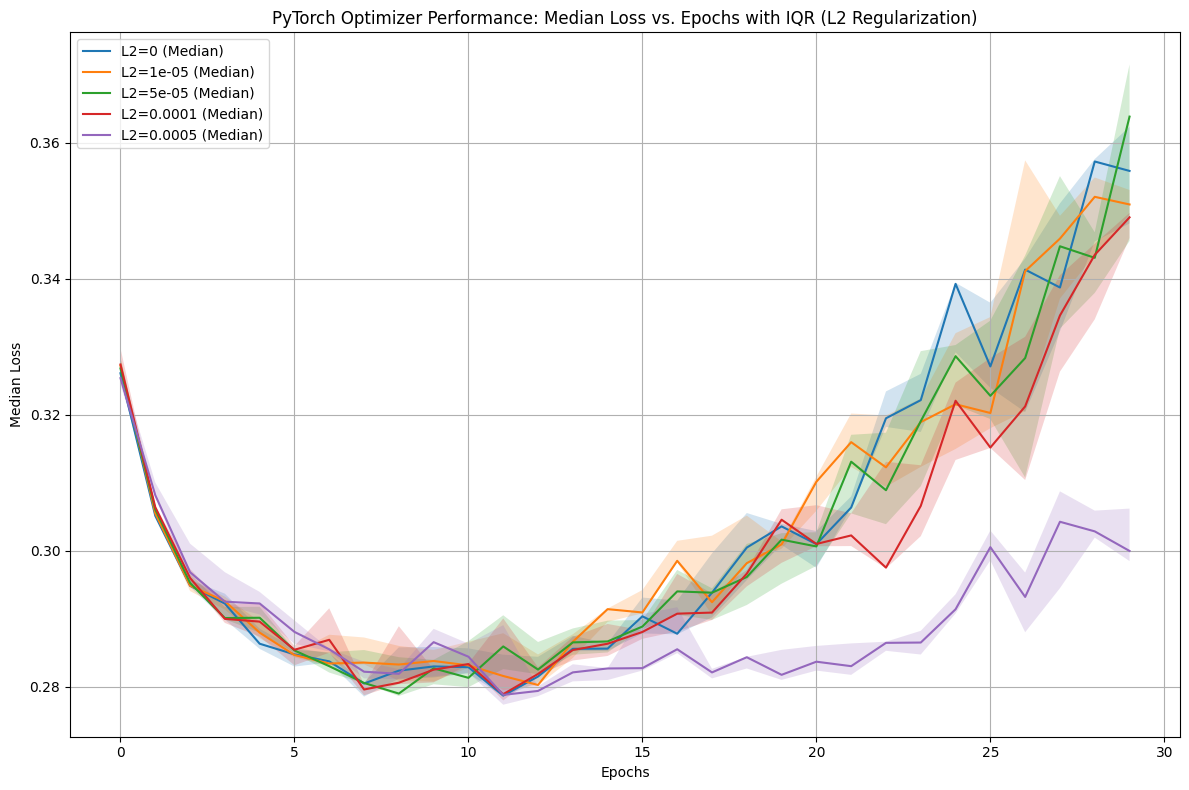

  Plot saved to: figures/hotelbooking_part3_pytorch_l2_val_loss_vs_time.png


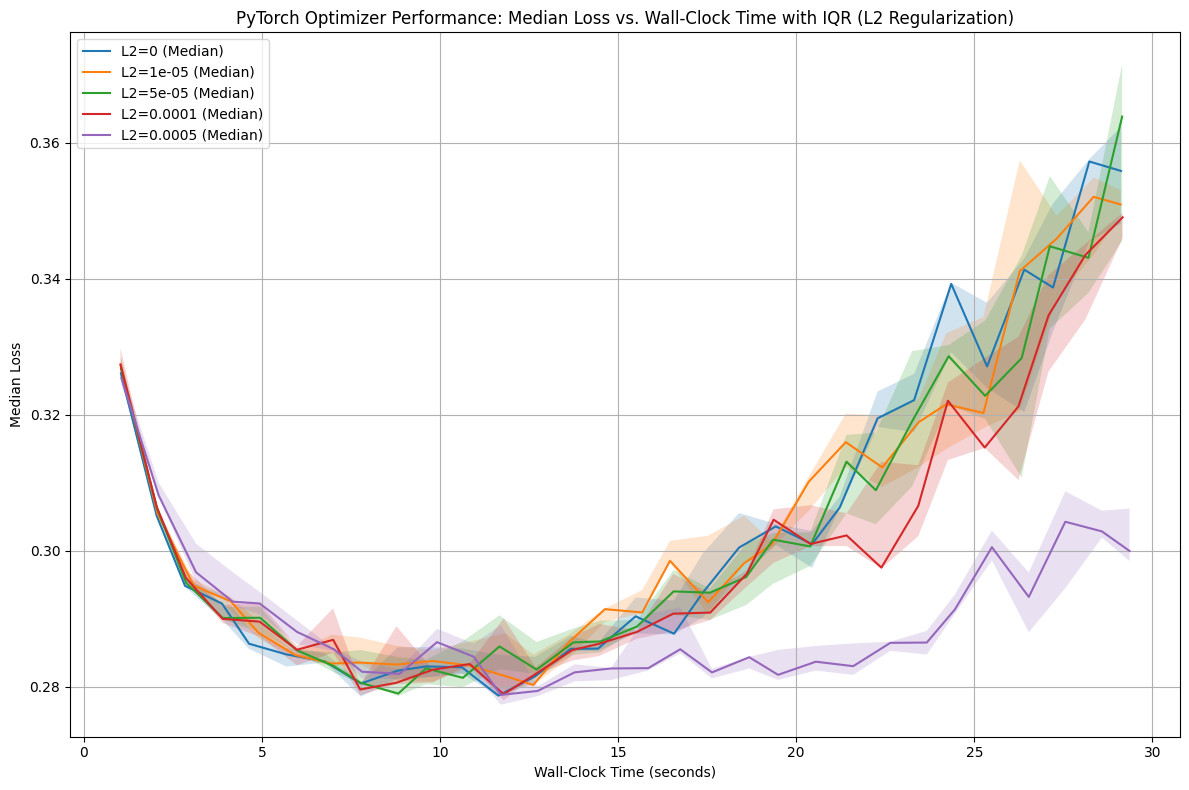

  Plot saved to: figures/hotelbooking_part3_pytorch_l2_val_loss_vs_grads.png


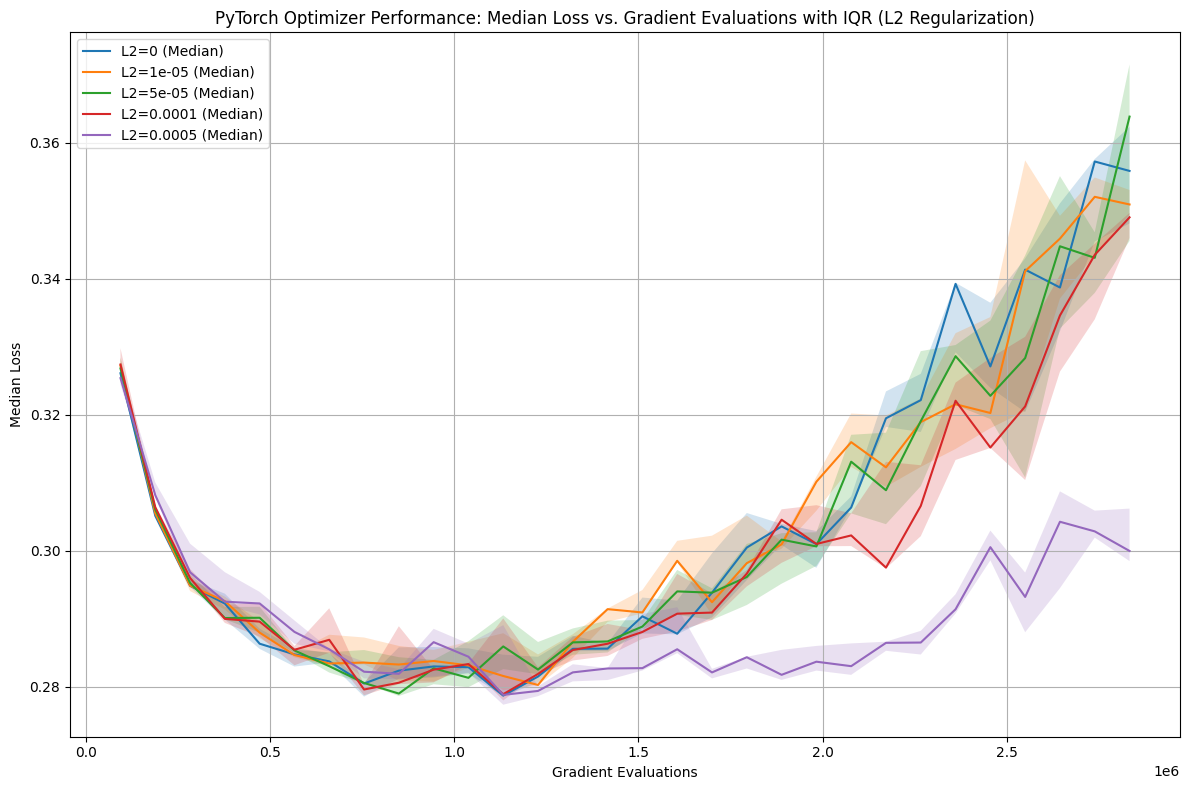

  Plot saved to: figures/hotelbooking_part3_pytorch_l2_val_auroc_vs_epochs.png


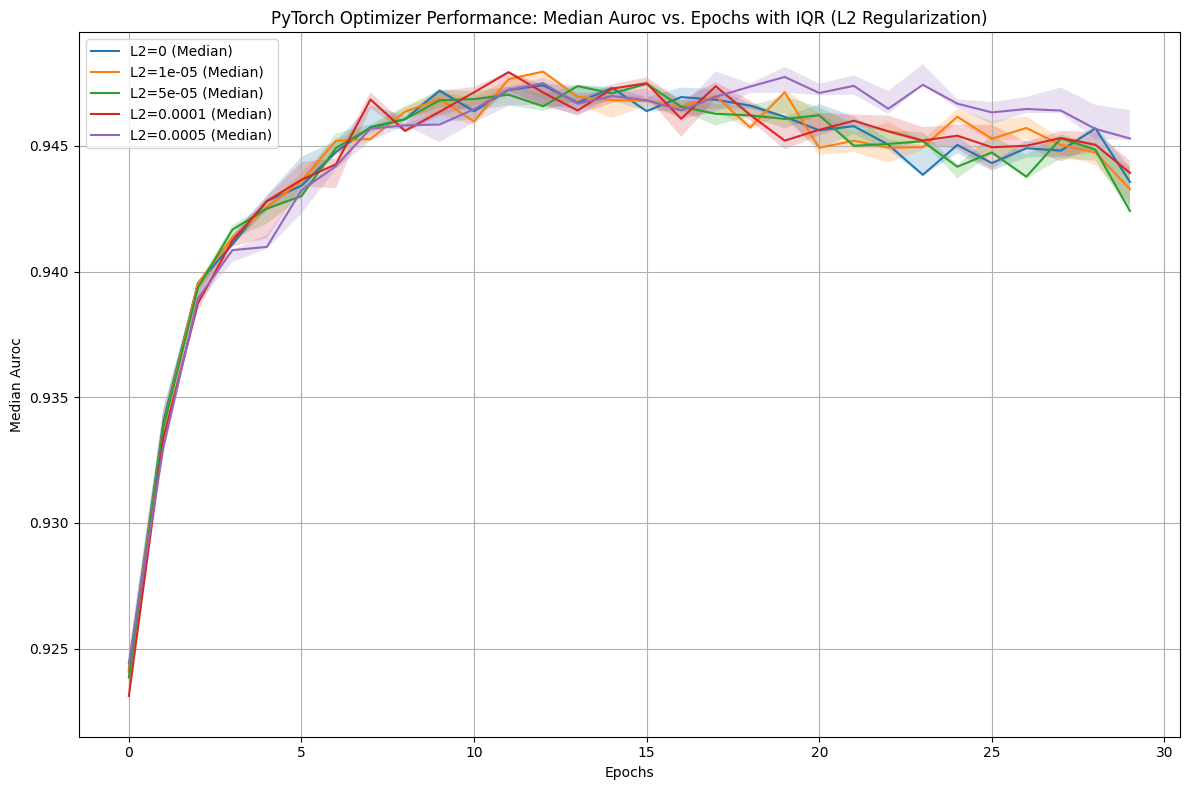

  Plot saved to: figures/hotelbooking_part3_pytorch_l2_val_auroc_vs_time.png


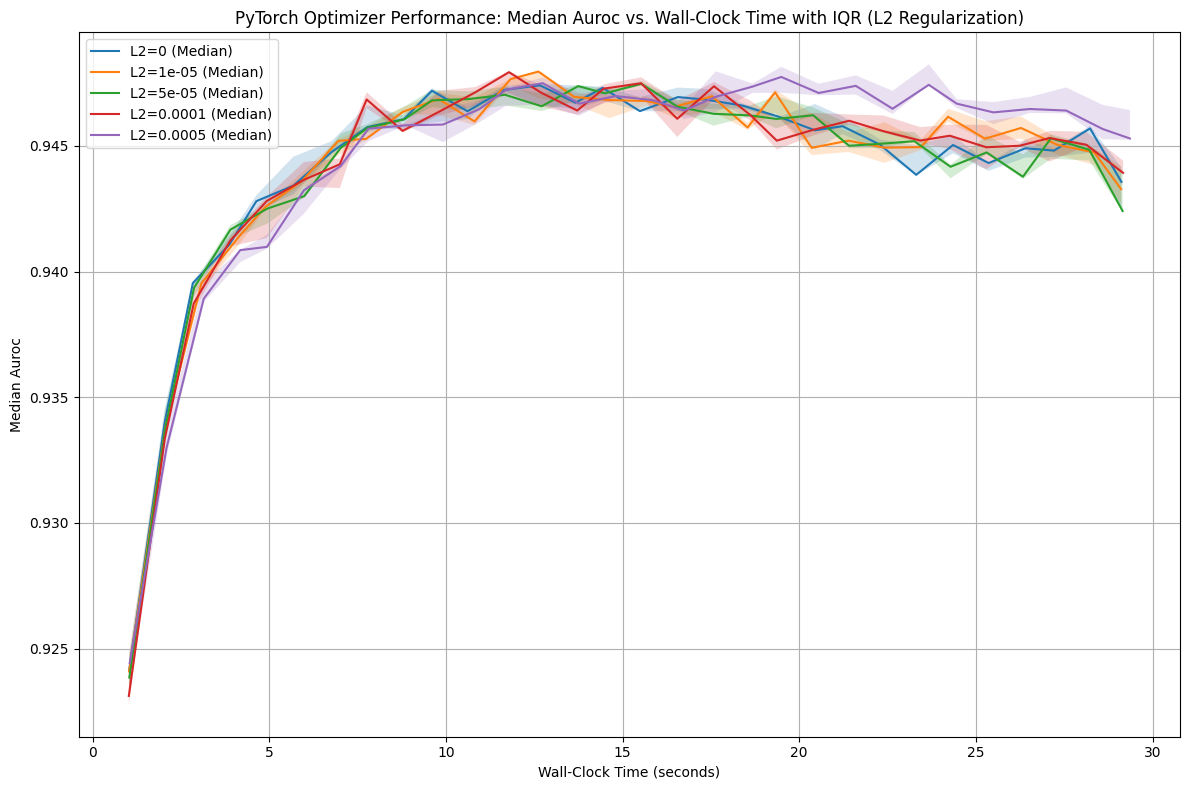

  Plot saved to: figures/hotelbooking_part3_pytorch_l2_val_auroc_vs_grads.png


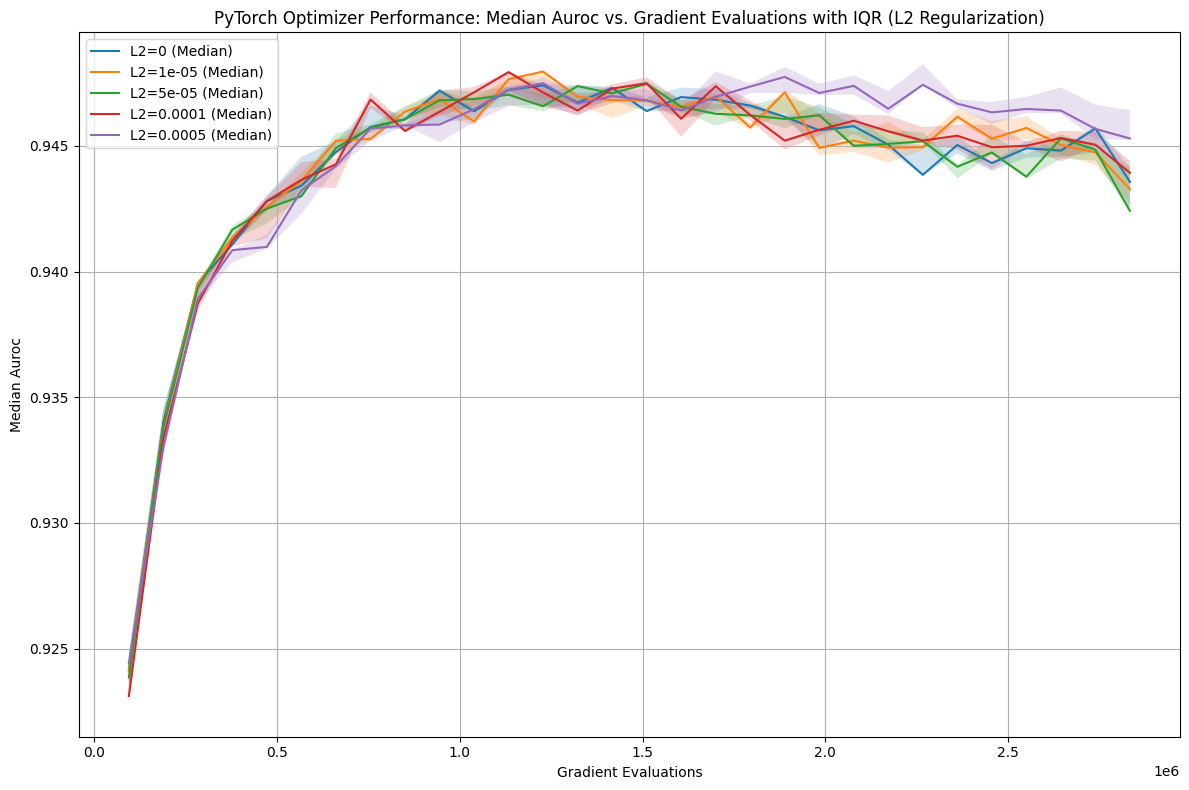


Finished generating L2 regularization performance plots.


In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# Define the directory for logs and figures
logs_dir = 'logs'
figures_dir = 'figures'
os.makedirs(figures_dir, exist_ok=True)
dataset_name = 'hotelbooking'

# Load the L2 training history if not already loaded
if 'l2_training_history' not in locals():
    l2_history_path_pt = os.path.join(logs_dir, f'{dataset_name}_part3_pytorch_l2_training_history.json')
    l2_training_history = {}
    if os.path.exists(l2_history_path_pt):
        with open(l2_history_path_pt, 'r') as f:
            l2_training_history = json.load(f)
        print(f"L2 training history loaded from: {l2_history_path_pt}")
    else:
        print(f"Error: L2 training history file not found at {l2_history_path_pt}")


print("\nAggregating L2 training history and calculating median/IQR...")

# Dictionary to store aggregated performance summaries for L2 experiments
l2_aggregated_performance = {}

# Iterate through each L2 lambda's history
for l2_lambda, seed_histories in l2_training_history.items():
    print(f"  Aggregating history for L2 Lambda: {l2_lambda}...")

    # Convert history for each seed into a DataFrame and align by epoch
    seed_dfs = []
    for seed, history_data in seed_histories.items():
        # Convert epoch history to DataFrame
        df = pd.DataFrame(history_data)
        # Add epoch number as a column
        df['epoch'] = df.index
        # Rename columns to include seed for uniqueness before merging
        df = df.rename(columns={col: f'{col}_seed{seed}' for col in df.columns if col != 'epoch'})
        seed_dfs.append(df)

    # Merge DataFrames from all seeds for this L2 lambda based on epoch
    # Use outer join to handle potential differences in epochs
    merged_df = seed_dfs[0] if seed_dfs else pd.DataFrame()
    for i in range(1, len(seed_dfs)):
        merged_df = pd.merge(merged_df, seed_dfs[i], on='epoch', how='outer')

    # Sort by epoch to ensure correct order
    merged_df = merged_df.sort_values('epoch')
    merged_df = merged_df.set_index('epoch')

    # Forward-fill any missing values (due to outer join)
    merged_df = merged_df.ffill()

    # Calculate median and IQR for each metric across seeds
    metrics_to_aggregate = [col.replace(f'_seed{seed}', '') for col in merged_df.columns if '_seed' in col]
    metrics_to_aggregate = list(set(metrics_to_aggregate)) # Get unique metric names

    summary_data = {}
    for metric in metrics_to_aggregate:
        # Select columns for the current metric across all seeds
        metric_cols = [col for col in merged_df.columns if col.startswith(f'{metric}_seed')]

        if metric_cols:
            # Calculate median and IQR
            summary_data[f'{metric}_median'] = merged_df[metric_cols].median(axis=1)
            summary_data[f'{metric}_q1'] = merged_df[metric_cols].quantile(0.25, axis=1)
            summary_data[f'{metric}_q3'] = merged_df[metric_cols].quantile(0.75, axis=1)
            summary_data[f'{metric}_iqr'] = summary_data[f'{metric}_q3'] - summary_data[f'{metric}_q1']

    # Create the aggregated performance DataFrame for this L2 lambda
    l2_aggregated_performance[l2_lambda] = pd.DataFrame(summary_data)

    print(f"  Aggregation complete for L2 Lambda: {l2_lambda}.")

print("\nFinished aggregating training history for all L2 lambdas.")

# Display a sample of one aggregated performance dataframe
if l2_aggregated_performance:
    first_lambda = list(l2_aggregated_performance.keys())[0]
    print(f"\nSample of aggregated performance DataFrame for L2 Lambda: {first_lambda}")
    display(l2_aggregated_performance[first_lambda].head())


# --- Plot Performance Metrics vs. Epochs and Compute ---

print("\nGenerating L2 regularization performance plots...")

metrics_to_plot = ['val_loss', 'val_auroc'] # Metrics to visualize

for metric in metrics_to_plot:
    # Plot vs. Epochs
    plt.figure(figsize=(12, 8))
    for l2_lambda, summary_df in l2_aggregated_performance.items():
        if f'{metric}_median' in summary_df.columns:
            epochs = summary_df.index
            median_metric = summary_df[f'{metric}_median']
            q1_metric = summary_df[f'{metric}_q1']
            q3_metric = summary_df[f'{metric}_q3']

            plt.plot(epochs, median_metric, label=f'L2={l2_lambda} (Median)')
            plt.fill_between(epochs, q1_metric, q3_metric, alpha=0.2)

    plt.xlabel("Epochs")
    plt.ylabel(f"Median {metric.replace('val_', '').replace('_', ' ').title()}")
    plt.title(f"PyTorch Optimizer Performance: Median {metric.replace('val_', '').replace('_', ' ').title()} vs. Epochs with IQR (L2 Regularization)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plot_path_epoch = os.path.join(figures_dir, f'{dataset_name}_part3_pytorch_l2_{metric}_vs_epochs.png')
    plt.savefig(plot_path_epoch)
    print(f"  Plot saved to: {plot_path_epoch}")
    plt.show()

    # Plot vs. Wall-Clock Time
    plt.figure(figsize=(12, 8))
    for l2_lambda, summary_df in l2_aggregated_performance.items():
        if f'{metric}_median' in summary_df.columns and 'wall_clock_time_median' in summary_df.columns:
            wall_clock_time = summary_df['wall_clock_time_median']
            median_metric = summary_df[f'{metric}_median']
            q1_metric = summary_df[f'{metric}_q1']
            q3_metric = summary_df[f'{metric}_q3']

            plt.plot(wall_clock_time, median_metric, label=f'L2={l2_lambda} (Median)')
            plt.fill_between(wall_clock_time, q1_metric, q3_metric, alpha=0.2)

    plt.xlabel("Wall-Clock Time (seconds)")
    plt.ylabel(f"Median {metric.replace('val_', '').replace('_', ' ').title()}")
    plt.title(f"PyTorch Optimizer Performance: Median {metric.replace('val_', '').replace('_', ' ').title()} vs. Wall-Clock Time with IQR (L2 Regularization)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plot_path_time = os.path.join(figures_dir, f'{dataset_name}_part3_pytorch_l2_{metric}_vs_time.png')
    plt.savefig(plot_path_time)
    print(f"  Plot saved to: {plot_path_time}")
    plt.show()

    # Plot vs. Gradient Evaluations
    plt.figure(figsize=(12, 8))
    for l2_lambda, summary_df in l2_aggregated_performance.items():
         if f'{metric}_median' in summary_df.columns and 'gradient_evals_median' in summary_df.columns:
              gradient_evals = summary_df['gradient_evals_median']
              median_metric = summary_df[f'{metric}_median']
              q1_metric = summary_df[f'{metric}_q1']
              q3_metric = summary_df[f'{metric}_q3']

              plt.plot(gradient_evals, median_metric, label=f'L2={l2_lambda} (Median)')
              plt.fill_between(gradient_evals, q1_metric, q3_metric, alpha=0.2)

    plt.xlabel("Gradient Evaluations")
    plt.ylabel(f"Median {metric.replace('val_', '').replace('_', ' ').title()}")
    plt.title(f"PyTorch Optimizer Performance: Median {metric.replace('val_', '').replace('_', ' ').title()} vs. Gradient Evaluations with IQR (L2 Regularization)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plot_path_grads = os.path.join(figures_dir, f'{dataset_name}_part3_pytorch_l2_{metric}_vs_grads.png')
    plt.savefig(plot_path_grads)
    print(f"  Plot saved to: {plot_path_grads}")
    plt.show()


print("\nFinished generating L2 regularization performance plots.")

### Experiment 2: Early Stopping

Implement and experiment with Early Stopping as a regularization technique. Define the patience and minimum delta parameters, and integrate the Early Stopping callback into the training loop for the PyTorch model using the best Adam optimizer. Document whether and when Early Stopping fired for each run.

In [40]:
import torch
import torch.nn as nn
import torch.optim as optim
import os
import numpy as np
import time
import pandas as pd
import json
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau # Import for potential future use, not needed for Early Stopping

# Define the directory for saving logs and artifacts
logs_dir = 'logs'
artifacts_dir = 'artifacts'
os.makedirs(logs_dir, exist_ok=True)
os.makedirs(artifacts_dir, exist_ok=True)

# Define the dataset name for file paths
dataset_name = 'hotelbooking'

# Load the best Adam hyperparameters (assuming they are available from previous steps)
# best_adam_lr, best_adam_beta1, best_adam_beta2, best_adam_epsilon, best_adam_weight_decay
# are expected to be loaded in a preceding cell.

# Define training parameters
es_train_epochs = 30 # Set a higher max epoch for Early Stopping to potentially fire
batch_size = 2048 # Use the same batch size
full_train_seeds = [11, 23, 47] # Use the same seeds
seed_registry['part_seeds']['Part 3 (PyTorch) - Early Stopping'] = full_train_seeds


# Define the loss function
criterion = nn.BCEWithLogitsLoss()

# Move data to the correct device and convert to PyTorch tensors and Datasets
X_train_tensor = torch.tensor(X_train.values.astype(np.float32), dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train.values.astype(np.float32), dtype=torch.float32).unsqueeze(1).to(device)
X_test_tensor = torch.tensor(X_test.values.astype(np.float32), dtype=torch.float32).unsqueeze(1).to(device) # Keep test as tensor for evaluation
y_test_tensor = torch.tensor(y_test.values.astype(np.float32), dtype=torch.float32).unsqueeze(1).to(device)


train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Define evaluation metric function (from Part 2)
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, average_precision_score

def evaluate_model(model, X_tensor, y_tensor, criterion):
    model.eval() # Set model to evaluation mode
    with torch.no_grad():
        # Ensure X_tensor has the correct shape for the model (remove extra dimension if present)
        if X_tensor.dim() == 3:
             X_tensor = X_tensor.squeeze(1) # Remove the extra dimension


        outputs = model(X_tensor)
        loss = criterion(outputs, y_tensor).item()
        probs = torch.sigmoid(outputs).cpu().numpy()
        labels = y_tensor.cpu().numpy()

        # Calculate metrics
        acc = accuracy_score(labels, (probs > 0.5).astype(int))
        try:
            auroc = roc_auc_score(labels, probs)
        except ValueError:
            auroc = np.nan # Handle case with only one class present

        preds = (probs > 0.5).astype(int)
        macro_f1 = f1_score(labels, preds, average='macro')
        pr_auc = average_precision_score(labels, probs)

    return loss, acc, auroc, macro_f1, pr_auc


# --- Early Stopping Implementation ---

class EarlyStopping:
    """
    Early stops the training if validation loss doesn't improve after a given patience.
    """
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last validation loss improvement.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement.
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                           Default: 0
            path (str): Path for the checkpoint to be saved to.
                        Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                                   Default: print
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
        self.stopped_epoch = None # Track the epoch when early stopping occurred

    def __call__(self, val_loss, model, epoch):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
                self.stopped_epoch = epoch # Record the epoch when stopping
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss


# --- Experiment 2: Early Stopping ---

print("\n--- Running Early Stopping Experiments ---")

# Define Early Stopping parameters
es_patience = 10 # Patience
es_min_delta = 1e-4 # Minimum change to be considered an improvement

# Dictionary to store training history for Early Stopping experiments
es_training_history = {}

# Dictionary to store training times for Early Stopping experiments
es_training_times = {}

# Dictionary to store Early Stopping info (whether it fired and at which epoch)
early_stopping_info = {}

for seed in full_train_seeds:
    print(f"\n  Running with seed {seed}...")
    set_seed(seed) # Set seed for reproducibility

    # Instantiate a new model for each seed
    model = RegularizedFullNetwork(input_size, backbone_layer_sizes, output_size) # No L2 or Dropout here, focusing on ES
    model.to(device) # Move model to the correct device

    # Create Adam optimizer with best hyperparameters from Part 2
    optimizer = optim.Adam(model.parameters(),
                           lr=best_adam_lr,
                           betas=(best_adam_beta1, best_adam_beta2),
                           eps=best_adam_epsilon,
                           weight_decay=0) # No weight decay in optimizer


    # Initialize Early Stopping
    # Define checkpoint path for this run
    checkpoint_path = os.path.join(artifacts_dir, dataset_name, 'part3', f'early_stopping_seed{seed}_checkpoint.pt')
    os.makedirs(os.path.dirname(checkpoint_path), exist_ok=True)
    early_stopping = EarlyStopping(patience=es_patience, verbose=False, delta=es_min_delta, path=checkpoint_path)


    # Lists to store metrics and loss per epoch for this seed
    epoch_history = {
        'train_loss': [],
        'val_loss': [],
        'val_accuracy': [],
        'val_auroc': [],
        'val_macro_f1': [],
        'val_pr_auc': [],
        'wall_clock_time': [], # Time elapsed since start of training for this seed
        'gradient_evals': [] # Added to log gradient evaluations per epoch
    }

    start_time = time.time()
    gradient_evals_counter = 0 # Reset gradient counter per seed


    # Training loop
    for epoch in range(es_train_epochs):
        model.train() # Set model to training mode
        running_loss = 0.0
        num_batches = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels) # No L2 or other regularization in loss here
            loss.backward()

            gradient_evals_counter += inputs.size(0) # Increment by batch size


            optimizer.step()

            running_loss += loss.item()
            num_batches += 1

        epoch_train_loss = running_loss / num_batches if num_batches > 0 else 0.0
        epoch_history['train_loss'].append(epoch_train_loss)

        # Evaluate on validation set
        val_loss, val_acc, val_auroc, val_macro_f1, val_pr_auc = evaluate_model(model, X_test_tensor.squeeze(1), y_test_tensor, criterion)

        epoch_history['val_loss'].append(val_loss)
        epoch_history['val_accuracy'].append(val_acc)
        epoch_history['val_auroc'].append(val_auroc)
        epoch_history['val_macro_f1'].append(val_macro_f1)
        epoch_history['val_pr_auc'].append(val_pr_auc)
        epoch_history['wall_clock_time'].append(time.time() - start_time)
        epoch_history['gradient_evals'].append(gradient_evals_counter)


        print(f"    Seed {seed}, Epoch {epoch+1}/{es_train_epochs}: Train Loss: {epoch_train_loss:.4f}, Val Loss: {val_loss:.4f}, Val AUC: {val_auroc:.4f}")

        # Check Early Stopping criteria
        early_stopping(val_loss, model, epoch)

        if early_stopping.early_stop:
            print(f"    Early stopping triggered for seed {seed} at epoch {epoch+1}.")
            early_stopping_info[seed] = {'stopped': True, 'stopped_epoch': epoch + 1}
            break # Stop training for this seed

    if seed not in early_stopping_info: # If loop finished without early stopping
         early_stopping_info[seed] = {'stopped': False, 'stopped_epoch': es_train_epochs} # Record max epochs


    # Load the best model weights saved by Early Stopping
    model.load_state_dict(torch.load(checkpoint_path))


    # Store the full history for this seed (up to the stopped epoch)
    es_training_history[seed] = {k: v[:epoch+1] for k, v in epoch_history.items()} # Store history up to the stopped epoch
    es_training_times[seed] = epoch_history['wall_clock_time'][-1] # Store total time


print("\nEarly Stopping experiments finished.")

# Optional: Save training history and times for Early Stopping experiments
es_history_path_pt = os.path.join(logs_dir, f'{dataset_name}_part3_pytorch_es_training_history.json')
with open(es_history_path_pt, 'w') as f:
    def convert_numpy(obj):
        if isinstance(obj, np.generic):
            return obj.item()
        if isinstance(obj, dict):
            return {k: convert_numpy(v) for k, v in obj.items()}
        if isinstance(obj, list):
            return [convert_numpy(item) for item in obj]
        return obj
    serializable_history = convert_numpy(es_training_history)
    json.dump(serializable_history, f, indent=4)

print(f"\nEarly Stopping training history saved to: {es_history_path_pt}")

es_times_path_pt = os.path.join(logs_dir, f'{dataset_name}_part3_pytorch_es_training_times.json')
with open(es_times_path_pt, 'w') as f:
    json.dump(es_training_times, f, indent=4)

print(f"Early Stopping training times saved to: {es_times_path_pt}")

# Save Early Stopping info
es_info_path_pt = os.path.join(logs_dir, f'{dataset_name}_part3_pytorch_es_info.json')
with open(es_info_path_pt, 'w') as f:
    json.dump(early_stopping_info, f, indent=4)
print(f"Early Stopping info saved to: {es_info_path_pt}")

# Log Early Stopping info
log_experiment_result(
    dataset='Hotel Booking',
    part='Part 3 (PyTorch)',
    method='Early Stopping Info',
    seeds=str(full_train_seeds),
    split='Validation', # Early Stopping monitors validation loss
    metrics=early_stopping_info,
    gradient_evals='N/A', # Logged within history
    function_evals='N/A', # Logged within history
    wall_clock_time_s='N/A', # Logged within history
    optimizer_settings='Adam (Best from Part 2)',
    regularizer_settings=f'EarlyStopping(patience={es_patience}, min_delta={es_min_delta})',
    RO_settings='N/A',
    checkpoint_path='N/A', # Checkpoint path is per seed and handled by EarlyStopping
    checkpoint_hash='N/A', # Not tracking checkpoint hash
    compute_accounting=''
)


--- Running Early Stopping Experiments ---

  Running with seed 11...
    Seed 11, Epoch 1/30: Train Loss: 0.4383, Val Loss: 0.3264, Val AUC: 0.9229
    Seed 11, Epoch 2/30: Train Loss: 0.3174, Val Loss: 0.3057, Val AUC: 0.9340
    Seed 11, Epoch 3/30: Train Loss: 0.2975, Val Loss: 0.2948, Val AUC: 0.9395
    Seed 11, Epoch 4/30: Train Loss: 0.2867, Val Loss: 0.2951, Val AUC: 0.9411
EarlyStopping counter: 1 of 10
    Seed 11, Epoch 5/30: Train Loss: 0.2809, Val Loss: 0.2848, Val AUC: 0.9433
    Seed 11, Epoch 6/30: Train Loss: 0.2717, Val Loss: 0.2811, Val AUC: 0.9457
    Seed 11, Epoch 7/30: Train Loss: 0.2652, Val Loss: 0.2837, Val AUC: 0.9456
EarlyStopping counter: 1 of 10
    Seed 11, Epoch 8/30: Train Loss: 0.2621, Val Loss: 0.2807, Val AUC: 0.9458
    Seed 11, Epoch 9/30: Train Loss: 0.2586, Val Loss: 0.2800, Val AUC: 0.9464
    Seed 11, Epoch 10/30: Train Loss: 0.2500, Val Loss: 0.2830, Val AUC: 0.9474
EarlyStopping counter: 1 of 10
    Seed 11, Epoch 11/30: Train Loss: 0.2462,

### Analyze Early Stopping Results

Analyze the training history from the Early Stopping experiments by aggregating the history across seeds and calculating the median and Interquartile Range (IQR) for relevant metrics (e.g., validation loss, accuracy, AUROC) over epochs and wall-clock time.


Aggregating Early Stopping training history and calculating median/IQR...
  Aggregating history for EarlyStopping...
  Aggregation complete for EarlyStopping.

Finished aggregating training history for Early Stopping.

Sample of aggregated performance DataFrame for Early Stopping:


wall_clock_time_median  wall_clock_time_q1  wall_clock_time_q3  \
epoch                                                                   
0                    0.813630            0.808916            0.815771   
1                    1.979109            1.956258            2.110477   
2                    3.064346            3.061241            3.093536   
3                    3.954427            3.923426            4.061469   
4                    5.001834            4.999980            5.031852   

       wall_clock_time_iqr  gradient_evals_median  gradient_evals_q1  \
epoch                                                                  
0                 0.006855                94447.0            94447.0   
1                 0.154220               188894.0           188894.0   
2                 0.032295               283341.0           283341.0   
3                 0.138042               377788.0           377788.0   
4                 0.031872               472235.0           472235.0   

       gradient_evals_q3  gradient_evals_iqr  train_loss_median  \
epoch                                                             
0                94447.0                 0.0           0.374275   
1               188894.0                 0.0           0.307950   
2               283341.0                 0.0           0.294197   
3               377788.0                 0.0           0.284092   
4               472235.0                 0.0           0.278042   

       train_loss_q1  train_loss_q3  train_loss_iqr  val_auroc_median  \
epoch                                                                   
0           0.369226       0.375065        0.005838          0.928637   
1           0.307845       0.308260        0.000415          0.936174   
2           0.294135       0.294739        0.000604          0.941030   
3           0.283376       0.284296        0.000920          0.942652   
4           0.277485       0.279063        0.001578          0.942318   

       val_auroc_q1  val_auroc_q3  val_auroc_iqr  val_macro_f1_median  \
epoch                                                                   
0          0.928561      0.928746       0.000184             0.832875   
1          0.936084      0.936951       0.000867             0.846444   
2          0.940661      0.941281       0.000620             0.851405   
3          0.941844      0.942705       0.000861             0.851760   
4          0.941817      0.942590       0.000773             0.853731   

       val_macro_f1_q1  val_macro_f1_q3  val_macro_f1_iqr  val_loss_median  \
epoch                                                                        
0             0.829404         0.833620          0.004216         0.316993   
1             0.846036         0.846505          0.000469         0.301232   
2             0.846871         0.851761          0.004890         0.290802   
3             0.850728         0.853749          0.003021         0.289005   
4             0.853130         0.854502          0.001372         0.288870   

       val_loss_q1  val_loss_q3  val_loss_iqr  val_pr_auc_median  \
epoch                                                              
0         0.316510     0.317347      0.000837           0.900827   
1         0.299127     0.302410      0.003283           0.910508   
2         0.290236     0.294237      0.004001           0.916629   
3         0.288975     0.290002      0.001027           0.918682   
4         0.287743     0.290393      0.002650           0.918529   

       val_pr_auc_q1  val_pr_auc_q3  val_pr_auc_iqr  val_accuracy_median  \
epoch                                                                      
0           0.900585       0.901202        0.000617             0.849060   
1           0.910194       0.911340        0.001146             0.857954   
2           0.916283       0.916969        0.000686             0.863713   
3           0.917848       0.918831        0.000983             0.864264   
4           0.91


Generating Early Stopping performance plots...
  Plot saved to: figures/hotelbooking_part3_pytorch_es_val_loss_vs_epochs.png


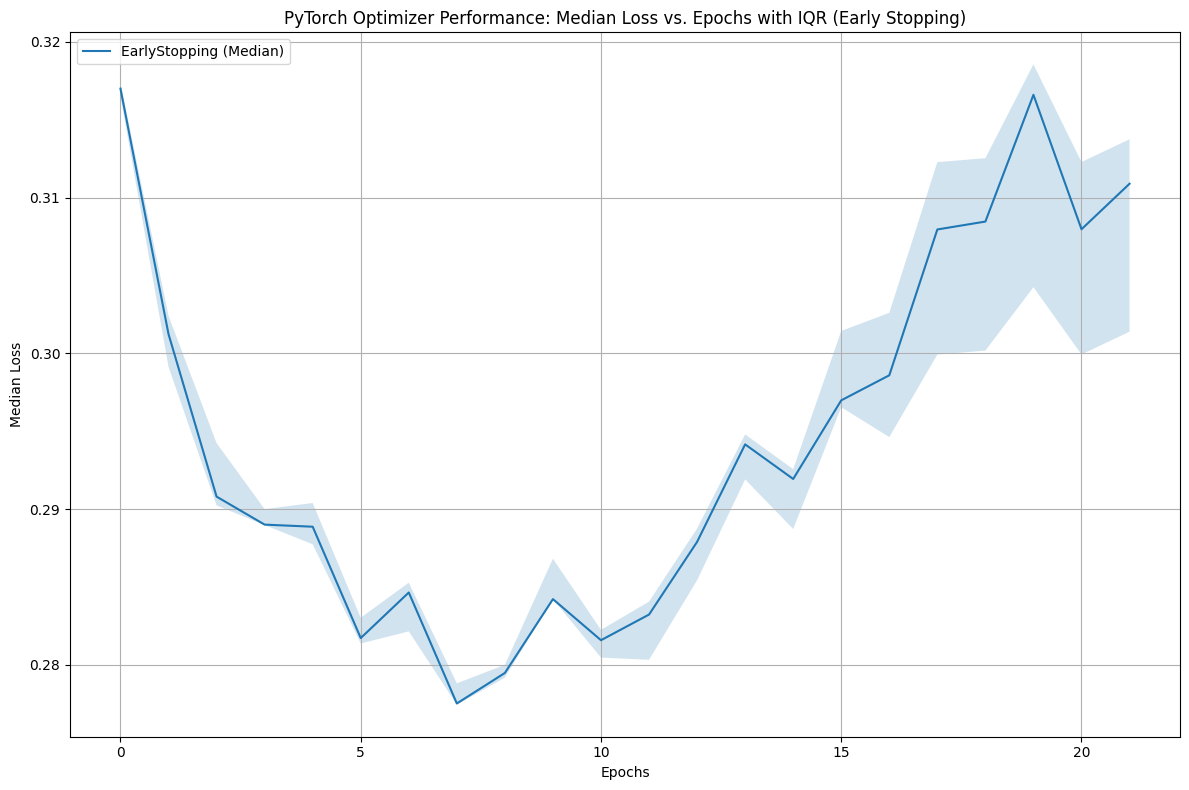

  Plot saved to: figures/hotelbooking_part3_pytorch_es_val_loss_vs_time.png


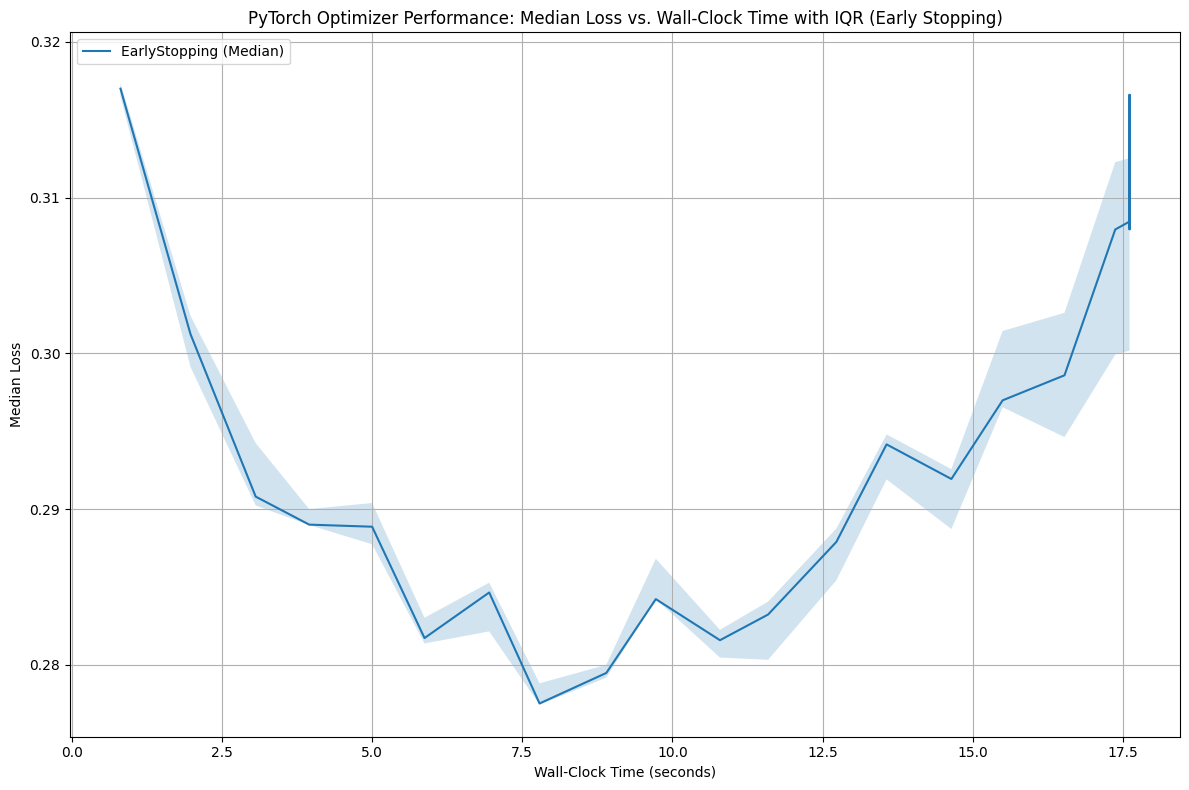

  Plot saved to: figures/hotelbooking_part3_pytorch_es_val_loss_vs_grads.png


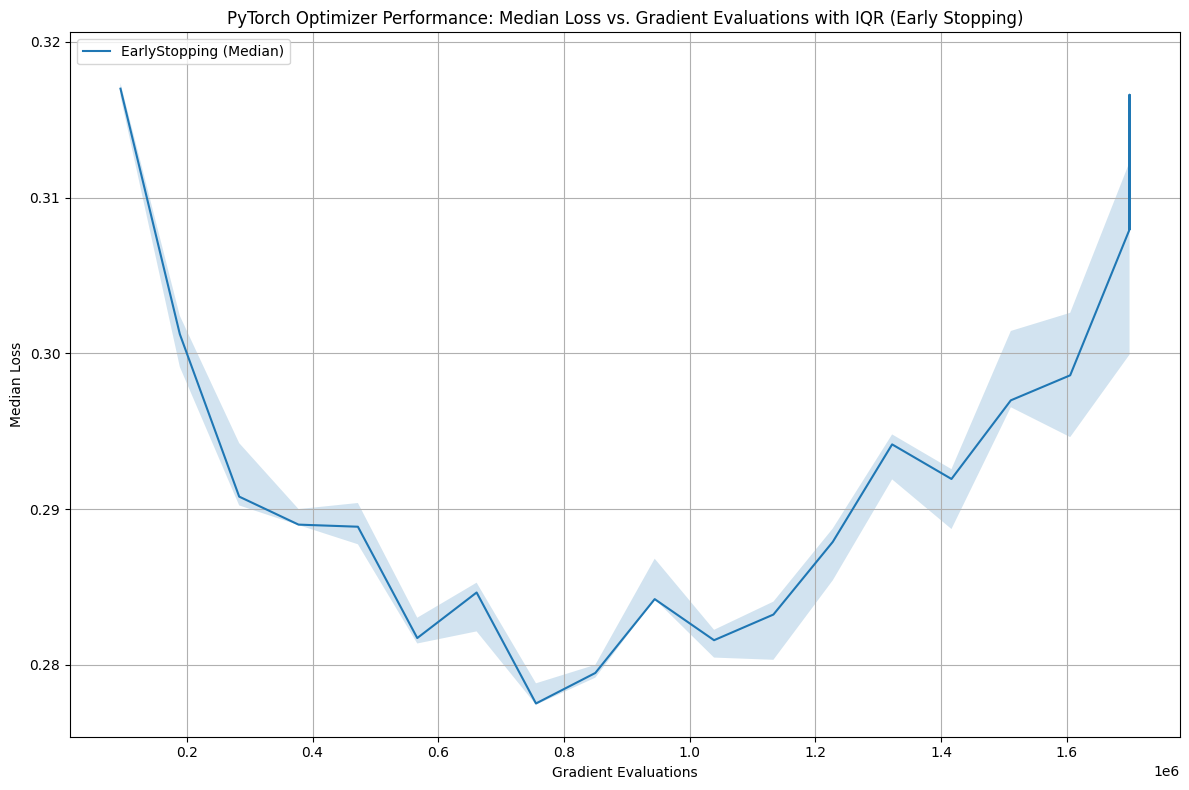

  Plot saved to: figures/hotelbooking_part3_pytorch_es_val_auroc_vs_epochs.png


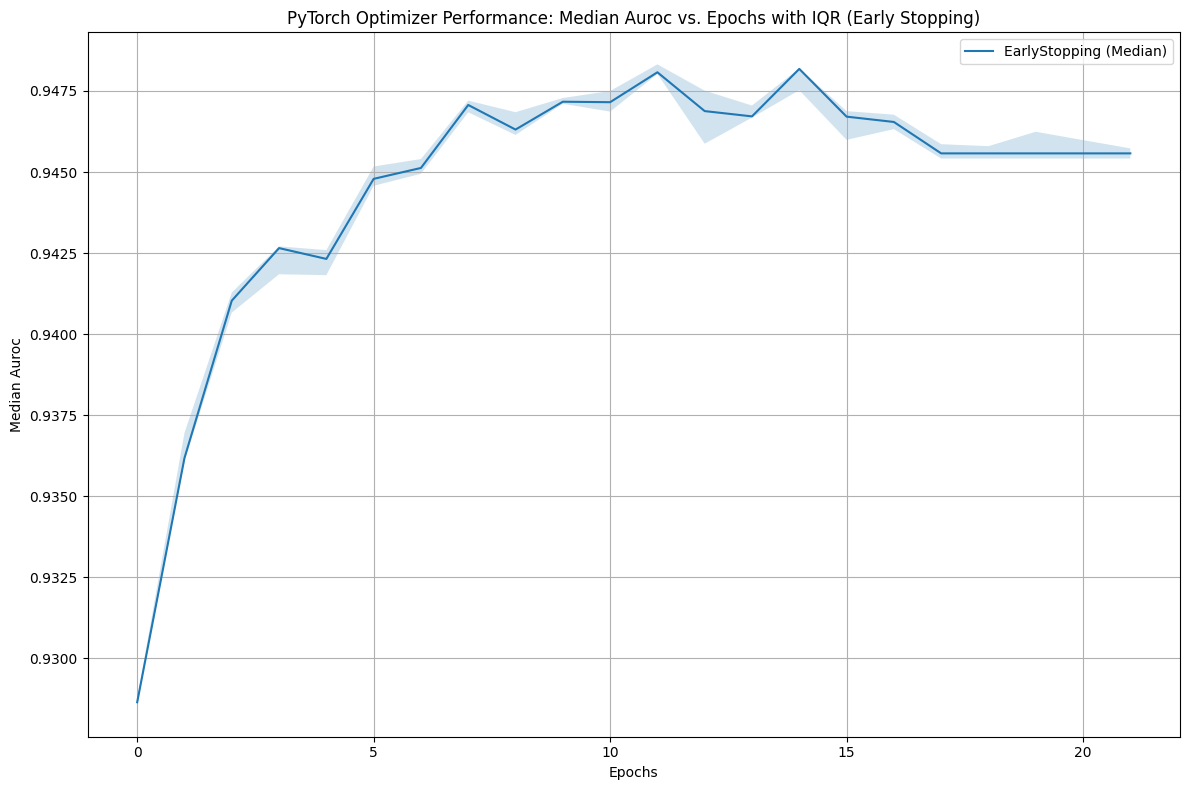

  Plot saved to: figures/hotelbooking_part3_pytorch_es_val_auroc_vs_time.png


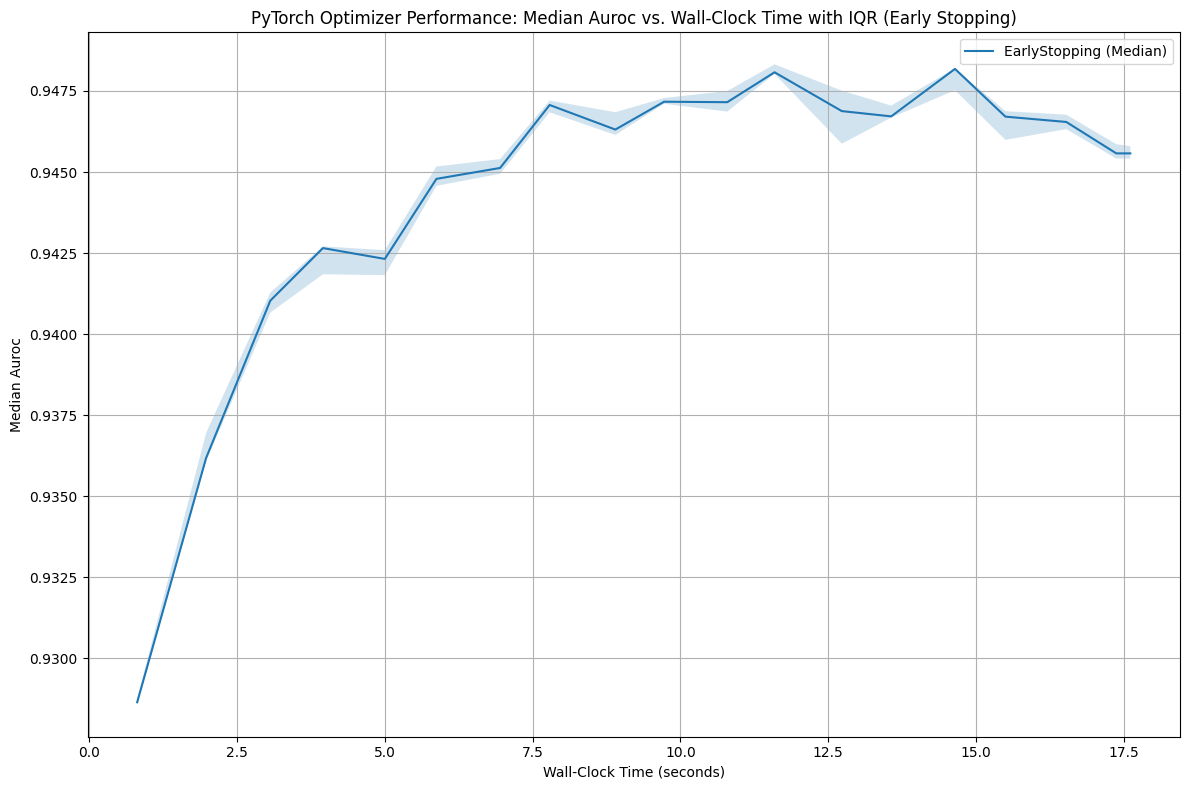

  Plot saved to: figures/hotelbooking_part3_pytorch_es_val_auroc_vs_grads.png


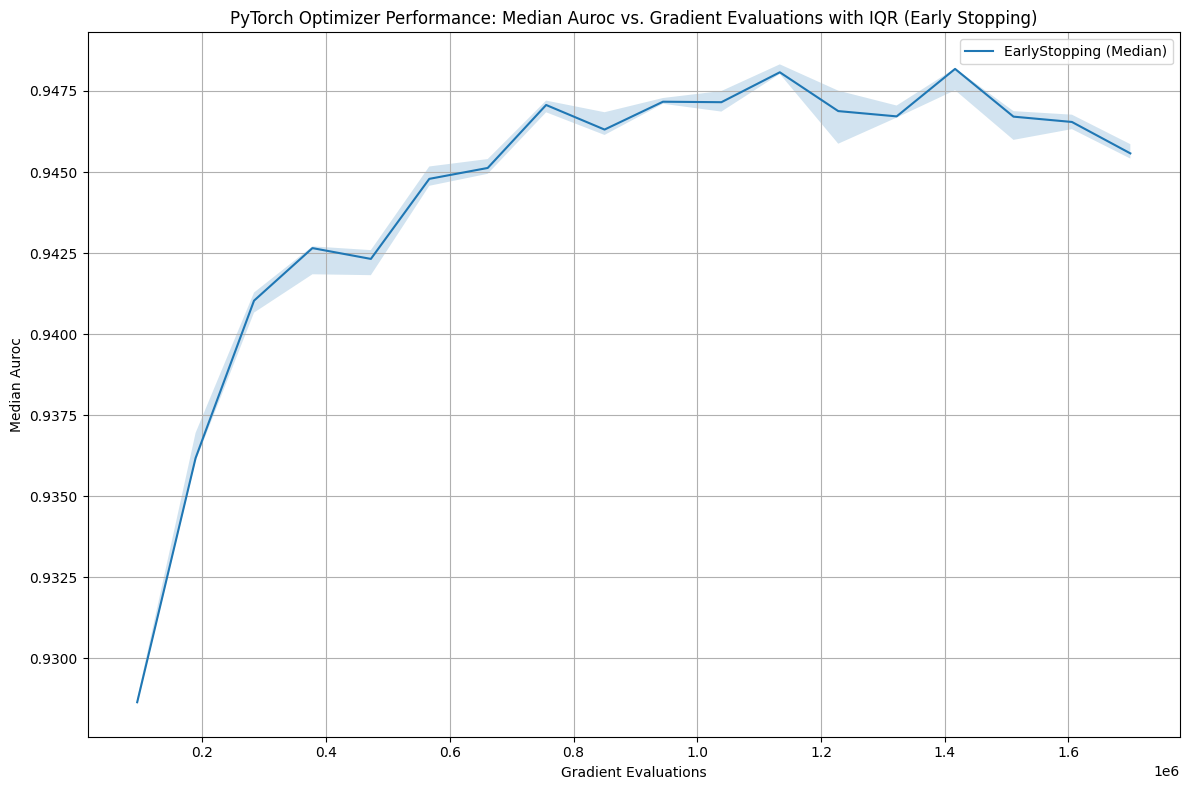


Finished generating Early Stopping performance plots.


In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import json

# Define the directory for logs and figures
logs_dir = 'logs'
figures_dir = 'figures'
os.makedirs(figures_dir, exist_ok=True)
dataset_name = 'hotelbooking'

# Load the Early Stopping training history if not already loaded
if 'es_training_history' not in locals():
    es_history_path_pt = os.path.join(logs_dir, f'{dataset_name}_part3_pytorch_es_training_history.json')
    es_training_history = {}
    if os.path.exists(es_history_path_pt):
        with open(es_history_path_pt, 'r') as f:
            es_training_history = json.load(f)
        print(f"Early Stopping training history loaded from: {es_history_path_pt}")
    else:
        print(f"Error: Early Stopping training history file not found at {es_history_path_pt}")

# Load Early Stopping info to get the stopped epochs
if 'early_stopping_info' not in locals():
    es_info_path_pt = os.path.join(logs_dir, f'{dataset_name}_part3_pytorch_es_info.json')
    early_stopping_info = {}
    if os.path.exists(es_info_path_pt):
        with open(es_info_path_pt, 'r') as f:
            early_stopping_info = json.load(f)
        print(f"Early Stopping info loaded from: {es_info_path_pt}")
    else:
        print(f"Error: Early Stopping info file not found at {es_info_path_pt}")


print("\nAggregating Early Stopping training history and calculating median/IQR...")

# Dictionary to store aggregated performance summaries for Early Stopping experiments
es_aggregated_performance = {}

# Early Stopping is a single 'configuration' (defined by its patience and delta)
# We aggregate across seeds for this configuration.
opt_name = 'EarlyStopping' # Use a descriptive name for the aggregated results

if es_training_history:
    print(f"  Aggregating history for {opt_name}...")

    # Convert history for each seed into a DataFrame and align by epoch
    seed_dfs = []
    for seed_str, history_data in es_training_history.items():
        # Ensure seed is an integer if needed, though dictionary keys are strings
        seed = int(seed_str)
        df = pd.DataFrame(history_data)
        df['epoch'] = df.index
        # Rename columns to include seed for uniqueness before merging
        df = df.rename(columns={col: f'{col}_seed{seed}' for col in df.columns if col != 'epoch'})
        seed_dfs.append(df)

    # Merge DataFrames from all seeds based on epoch
    merged_df = seed_dfs[0] if seed_dfs else pd.DataFrame()
    for i in range(1, len(seed_dfs)):
        merged_df = pd.merge(merged_df, seed_dfs[i], on='epoch', how='outer')

    # Sort by epoch to ensure correct order
    merged_df = merged_df.sort_values('epoch')
    merged_df = merged_df.set_index('epoch')

    # Forward-fill any missing values (due to different stopping epochs)
    merged_df = merged_df.ffill()

    # Calculate median and IQR for each metric across seeds
    metrics_to_aggregate = [col.replace(f'_seed{list(es_training_history.keys())[0]}', '') for col in merged_df.columns if '_seed' in col]
    metrics_to_aggregate = list(set(metrics_to_aggregate)) # Get unique metric names


    summary_data = {}
    for metric in metrics_to_aggregate:
        # Select columns for the current metric across all seeds
        metric_cols = [col for col in merged_df.columns if col.startswith(f'{metric}_seed')]

        if metric_cols:
            # Calculate median and IQR
            summary_data[f'{metric}_median'] = merged_df[metric_cols].median(axis=1)
            summary_data[f'{metric}_q1'] = merged_df[metric_cols].quantile(0.25, axis=1)
            summary_data[f'{metric}_q3'] = merged_df[metric_cols].quantile(0.75, axis=1)
            summary_data[f'{metric}_iqr'] = summary_data[f'{metric}_q3'] - summary_data[f'{metric}_q1']

    # Store the aggregated performance DataFrame
    es_aggregated_performance[opt_name] = pd.DataFrame(summary_data)

    print(f"  Aggregation complete for {opt_name}.")

else:
    print("No Early Stopping training history available to aggregate.")


print("\nFinished aggregating training history for Early Stopping.")

# Display a sample of the aggregated performance dataframe
if es_aggregated_performance:
    print(f"\nSample of aggregated performance DataFrame for Early Stopping:")
    display(es_aggregated_performance[opt_name].head())

# --- Plot Performance Metrics vs. Epochs and Compute ---

print("\nGenerating Early Stopping performance plots...")

metrics_to_plot = ['val_loss', 'val_auroc'] # Metrics to visualize

for metric in metrics_to_plot:
    # Plot vs. Epochs
    plt.figure(figsize=(12, 8))
    if opt_name in es_aggregated_performance:
        summary_df = es_aggregated_performance[opt_name]
        if f'{metric}_median' in summary_df.columns:
            epochs = summary_df.index
            median_metric = summary_df[f'{metric}_median']
            q1_metric = summary_df[f'{metric}_q1']
            q3_metric = summary_df[f'{metric}_q3']

            plt.plot(epochs, median_metric, label=f'{opt_name} (Median)')
            plt.fill_between(epochs, q1_metric, q3_metric, alpha=0.2)

    plt.xlabel("Epochs")
    plt.ylabel(f"Median {metric.replace('val_', '').replace('_', ' ').title()}")
    plt.title(f"PyTorch Optimizer Performance: Median {metric.replace('val_', '').replace('_', ' ').title()} vs. Epochs with IQR (Early Stopping)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plot_path_epoch = os.path.join(figures_dir, f'{dataset_name}_part3_pytorch_es_{metric}_vs_epochs.png')
    plt.savefig(plot_path_epoch)
    print(f"  Plot saved to: {plot_path_epoch}")
    plt.show()

    # Plot vs. Wall-Clock Time
    plt.figure(figsize=(12, 8))
    if opt_name in es_aggregated_performance:
        summary_df = es_aggregated_performance[opt_name]
        if f'{metric}_median' in summary_df.columns and 'wall_clock_time_median' in summary_df.columns:
            wall_clock_time = summary_df['wall_clock_time_median']
            median_metric = summary_df[f'{metric}_median']
            q1_metric = summary_df[f'{metric}_q1']
            q3_metric = summary_df[f'{metric}_q3']

            plt.plot(wall_clock_time, median_metric, label=f'{opt_name} (Median)')
            plt.fill_between(wall_clock_time, q1_metric, q3_metric, alpha=0.2)

    plt.xlabel("Wall-Clock Time (seconds)")
    plt.ylabel(f"Median {metric.replace('val_', '').replace('_', ' ').title()}")
    plt.title(f"PyTorch Optimizer Performance: Median {metric.replace('val_', '').replace('_', ' ').title()} vs. Wall-Clock Time with IQR (Early Stopping)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plot_path_time = os.path.join(figures_dir, f'{dataset_name}_part3_pytorch_es_{metric}_vs_time.png')
    plt.savefig(plot_path_time)
    print(f"  Plot saved to: {plot_path_time}")
    plt.show()

    # Plot vs. Gradient Evaluations
    plt.figure(figsize=(12, 8))
    if opt_name in es_aggregated_performance:
        summary_df = es_aggregated_performance[opt_name]
        if f'{metric}_median' in summary_df.columns and 'gradient_evals_median' in summary_df.columns:
            gradient_evals = summary_df['gradient_evals_median']
            median_metric = summary_df[f'{metric}_median']
            q1_metric = summary_df[f'{metric}_q1']
            q3_metric = summary_df[f'{metric}_q3']

            plt.plot(gradient_evals, median_metric, label=f'{opt_name} (Median)')
            plt.fill_between(gradient_evals, q1_metric, q3_metric, alpha=0.2)

    plt.xlabel("Gradient Evaluations")
    plt.ylabel(f"Median {metric.replace('val_', '').replace('_', ' ').title()}")
    plt.title(f"PyTorch Optimizer Performance: Median {metric.replace('val_', '').replace('_', ' ').title()} vs. Gradient Evaluations with IQR (Early Stopping)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plot_path_grads = os.path.join(figures_dir, f'{dataset_name}_part3_pytorch_es_{metric}_vs_grads.png')
    plt.savefig(plot_path_grads)
    print(f"  Plot saved to: {plot_path_grads}")
    plt.show()


print("\nFinished generating Early Stopping performance plots.")

### Experiment 3: Dropout

Implement and experiment with Dropout as a regularization technique. Modify the PyTorch model to include dropout layers at specified locations and run experiments with different dropout rates using the best Adam optimizer. Document the exact placements and rates used.

In [44]:
import torch
import torch.nn as nn
import torch.optim as optim
import os
import numpy as np
import time
import pandas as pd
import json
from torch.utils.data import TensorDataset, DataLoader

# Define the directory for saving logs and artifacts
logs_dir = 'logs'
artifacts_dir = 'artifacts'
figures_dir = 'figures' # Also define figures_dir for saving model diagram
os.makedirs(logs_dir, exist_ok=True)
os.makedirs(artifacts_dir, exist_ok=True)
os.makedirs(figures_dir, exist_ok=True)


# Define the dataset name for file paths
dataset_name = 'hotelbooking'

# Load the best Adam hyperparameters (assuming they are available from previous steps)
# best_adam_lr, best_adam_beta1, best_adam_beta2, best_adam_epsilon, best_adam_weight_decay
# are expected to be loaded in a preceding cell.

# Define training parameters
dropout_train_epochs = 30 # Use the same epoch budget as Part 2 full runs
batch_size = 2048 # Use the same batch size
full_train_seeds = [11, 23, 47] # Use the same seeds
seed_registry['part_seeds']['Part 3 (PyTorch) - Dropout'] = full_train_seeds


# Define the loss function
criterion = nn.BCEWithLogitsLoss()

# Move data to the correct device and convert to PyTorch tensors and Datasets
X_train_tensor = torch.tensor(X_train.values.astype(np.float32), dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train.values.astype(np.float32), dtype=torch.float32).unsqueeze(1).to(device)
X_test_tensor = torch.tensor(X_test.values.astype(np.float32), dtype=torch.float32).unsqueeze(1).to(device) # Keep test as tensor for evaluation
y_test_tensor = torch.tensor(y_test.values.astype(np.float32), dtype=torch.float32).unsqueeze(1).to(device)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Define evaluation metric function (from Part 2)
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, average_precision_score

def evaluate_model(model, X_tensor, y_tensor, criterion):
    model.eval() # Set model to evaluation mode
    with torch.no_grad():
        outputs = model(X_tensor)
        loss = criterion(outputs, y_tensor).item()
        probs = torch.sigmoid(outputs).cpu().numpy()
        labels = y_tensor.cpu().numpy()

        # Calculate metrics
        acc = accuracy_score(labels, (probs > 0.5).astype(int))
        try:
            auroc = roc_auc_score(labels, probs)
        except ValueError:
            auroc = np.nan # Handle case with only one class present

        preds = (probs > 0.5).astype(int)
        macro_f1 = f1_score(labels, preds, average='macro')
        pr_auc = average_precision_score(labels, probs)

    return loss, acc, auroc, macro_f1, pr_auc


# --- Experiment 3: Dropout ---

print("\n--- Running Dropout Experiments ---")

# Define Dropout rates search space (including 0 for baseline)
dropout_rates = [0.0, 0.1, 0.2, 0.3]

# Document Dropout placement
dropout_placement_info = """
Dropout will be applied after the ReLU activation in each backbone layer,
EXCEPT for the last backbone layer before the final output layer.
This is based on the common practice of applying dropout after activation functions
and before the output layer to avoid dropping out the input to the final classification.
"""
print("\nDropout Placement:")
print(dropout_placement_info)

# Dictionary to store training history for Dropout experiments
dropout_training_history = {}

# Dictionary to store training times for Dropout experiments
dropout_training_times = {}

for dropout_rate in dropout_rates:
    dropout_rate_str = str(dropout_rate).replace('.', 'p') # Create a string representation for filenames
    print(f"\nExperimenting with Dropout Rate: {dropout_rate}")
    dropout_training_history[dropout_rate] = {}
    dropout_training_times[dropout_rate] = {}

    for seed in full_train_seeds:
        print(f"  Running with seed {seed}...")
        set_seed(seed) # Set seed for reproducibility

        # Instantiate a new model for each seed and Dropout rate
        model = RegularizedFullNetwork(input_size, backbone_layer_sizes, output_size, dropout_rate=dropout_rate)
        model.to(device) # Move model to the correct device

        # Create Adam optimizer with best hyperparameters from Part 2
        optimizer = optim.Adam(model.parameters(),
                               lr=best_adam_lr,
                               betas=(best_adam_beta1, best_adam_beta2),
                               eps=best_adam_epsilon,
                               weight_decay=0) # No weight decay in optimizer for this experiment


        # Lists to store metrics and loss per epoch for this seed
        epoch_history = {
            'train_loss': [],
            'val_loss': [],
            'val_accuracy': [],
            'val_auroc': [],
            'val_macro_f1': [],
            'val_pr_auc': [],
            'wall_clock_time': [], # Time elapsed since start of training for this seed
            'gradient_evals': [] # Added to log gradient evaluations per epoch
        }

        start_time = time.time()
        gradient_evals_counter = 0 # Reset gradient counter per seed

        # Training loop
        for epoch in range(dropout_train_epochs):
            model.train() # Set model to training mode
            running_loss = 0.0
            num_batches = 0

            for inputs, labels in train_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()

                gradient_evals_counter += inputs.size(0) # Increment by batch size

                optimizer.step()

                running_loss += loss.item()
                num_batches += 1

            epoch_train_loss = running_loss / num_batches if num_batches > 0 else 0.0
            epoch_history['train_loss'].append(epoch_train_loss)

            # Evaluate on validation set (X_test_tensor, y_test_tensor)
            val_loss, val_acc, val_auroc, val_macro_f1, val_pr_auc = evaluate_model(model, X_test_tensor.squeeze(1), y_test_tensor, criterion)

            epoch_history['val_loss'].append(val_loss)
            epoch_history['val_accuracy'].append(val_acc)
            epoch_history['val_auroc'].append(val_auroc)
            epoch_history['val_macro_f1'].append(val_macro_f1)
            epoch_history['val_pr_auc'].append(val_pr_auc)
            epoch_history['wall_clock_time'].append(time.time() - start_time)
            epoch_history['gradient_evals'].append(gradient_evals_counter)


            print(f"    Seed {seed}, Epoch {epoch+1}/{dropout_train_epochs}: Train Loss: {epoch_train_loss:.4f}, Val Loss: {val_loss:.4f}, Val AUC: {val_auroc:.4f}")


        # Store the full history for this seed
        dropout_training_history[dropout_rate][seed] = epoch_history
        dropout_training_times[dropout_rate][seed] = epoch_history['wall_clock_time'][-1] # Store total time


print("\nDropout experiments finished.")

# Optional: Save training history and times for Dropout experiments
dropout_history_path_pt = os.path.join(logs_dir, f'{dataset_name}_part3_pytorch_dropout_training_history.json')
with open(dropout_history_path_pt, 'w') as f:
    def convert_numpy(obj):
        if isinstance(obj, np.generic):
            return obj.item()
        if isinstance(obj, dict):
            return {k: convert_numpy(v) for k, v in obj.items()}
        if isinstance(obj, list):
            return [convert_numpy(item) for item in obj]
        return obj
    serializable_history = convert_numpy(dropout_training_history)
    json.dump(serializable_history, f, indent=4)

print(f"\nDropout training history saved to: {dropout_history_path_pt}")

dropout_times_path_pt = os.path.join(logs_dir, f'{dataset_name}_part3_pytorch_dropout_training_times.json')
with open(dropout_times_path_pt, 'w') as f:
    json.dump(dropout_training_times, f, indent=4)

print(f"Dropout training times saved to: {dropout_times_path_pt}")

# Optional: Log dropout placement info
dropout_placement_path = os.path.join(logs_dir, f'{dataset_name}_part3_pytorch_dropout_placement.txt')
with open(dropout_placement_path, 'w') as f:
    f.write("Dropout Placement Information:\n")
    f.write(dropout_placement_info)
    f.write("\n")
    f.write("Model Architecture with Conceptual Dropout Placement:\n")
    # Print model architecture with annotations
    model_with_dropout_concept = RegularizedFullNetwork(input_size, backbone_layer_sizes, output_size, dropout_rate=0.5) # Use a non-zero rate to show dropout layers
    f.write(str(model_with_dropout_concept))

print(f"Dropout placement info saved to: {dropout_placement_path}")


--- Running Dropout Experiments ---

Dropout Placement:

Dropout will be applied after the ReLU activation in each backbone layer,
EXCEPT for the last backbone layer before the final output layer.
This is based on the common practice of applying dropout after activation functions
and before the output layer to avoid dropping out the input to the final classification.


Experimenting with Dropout Rate: 0.0
  Running with seed 11...
    Seed 11, Epoch 1/30: Train Loss: 0.4383, Val Loss: 0.3264, Val AUC: 0.9229
    Seed 11, Epoch 2/30: Train Loss: 0.3174, Val Loss: 0.3057, Val AUC: 0.9340
    Seed 11, Epoch 3/30: Train Loss: 0.2975, Val Loss: 0.2948, Val AUC: 0.9395
    Seed 11, Epoch 4/30: Train Loss: 0.2867, Val Loss: 0.2951, Val AUC: 0.9411
    Seed 11, Epoch 5/30: Train Loss: 0.2809, Val Loss: 0.2848, Val AUC: 0.9433
    Seed 11, Epoch 6/30: Train Loss: 0.2717, Val Loss: 0.2811, Val AUC: 0.9457
    Seed 11, Epoch 7/30: Train Loss: 0.2652, Val Loss: 0.2837, Val AUC: 0.9456
    Seed 11

### Analyze Dropout Results

Analyze the training history from the Dropout experiments by aggregating the history across seeds and calculating the median and Interquartile Range (IQR) for relevant metrics (e.g., validation loss, accuracy, AUROC) over epochs and wall-clock time.


Aggregating Dropout training history and calculating median/IQR...
  Aggregating history for Dropout Rate: 0.0...
  Aggregation complete for Dropout Rate: 0.0.
  Aggregating history for Dropout Rate: 0.1...
  Aggregation complete for Dropout Rate: 0.1.
  Aggregating history for Dropout Rate: 0.2...
  Aggregation complete for Dropout Rate: 0.2.
  Aggregating history for Dropout Rate: 0.3...
  Aggregation complete for Dropout Rate: 0.3.

Finished aggregating training history for all dropout rates.

Sample of aggregated performance DataFrame for Dropout Rate: 0.0


wall_clock_time_median  wall_clock_time_q1  wall_clock_time_q3  \
epoch                                                                   
0                    0.732879            0.732002            0.872330   
1                    1.717141            1.710660            1.861136   
2                    2.709596            2.696808            2.868623   
3                    3.699410            3.546746            3.729446   
4                    4.680873            4.527521            4.750734   

       wall_clock_time_iqr  gradient_evals_median  gradient_evals_q1  \
epoch                                                                  
0                 0.140328                94447.0            94447.0   
1                 0.150476               188894.0           188894.0   
2                 0.171816               283341.0           283341.0   
3                 0.182700               377788.0           377788.0   
4                 0.223213               472235.0           472235.0   

       gradient_evals_q3  gradient_evals_iqr  train_loss_median  \
epoch                                                             
0                94447.0                 0.0           0.430902   
1               188894.0                 0.0           0.315426   
2               283341.0                 0.0           0.297346   
3               377788.0                 0.0           0.286478   
4               472235.0                 0.0           0.279206   

       train_loss_q1  train_loss_q3  train_loss_iqr  val_auroc_median  \
epoch                                                                   
0           0.418980       0.434610        0.015630          0.924166   
1           0.314975       0.316419        0.001444          0.934010   
2           0.295820       0.297445        0.001625          0.939544   
3           0.285860       0.286571        0.000711          0.941083   
4           0.279032       0.280029        0.000997          0.942805   

       val_auroc_q1  val_auroc_q3  val_auroc_iqr  val_macro_f1_median  \
epoch                                                                   
0          0.923537      0.924777       0.001240             0.828979   
1          0.933986      0.934550       0.000564             0.842525   
2          0.939312      0.939605       0.000293             0.849844   
3          0.941078      0.941470       0.000393             0.852859   
4          0.942424      0.943036       0.000612             0.855653   

       val_macro_f1_q1  val_macro_f1_q3  val_macro_f1_iqr  val_loss_median  \
epoch                                                                        
0             0.825722         0.832001          0.006279         0.326102   
1             0.840666         0.844103          0.003437         0.305126   
2             0.849446         0.850418          0.000972         0.294821   
3             0.848862         0.853282          0.004420         0.292208   
4             0.854306         0.856562          0.002256         0.286297   

       val_loss_q1  val_loss_q3  val_loss_iqr  val_pr_auc_median  \
epoch                                                              
0         0.325297     0.326242      0.000946           0.894886   
1         0.305082     0.305420      0.000338           0.908217   
2         0.294650     0.295705      0.001055           0.914695   
3         0.289852     0.293663      0.003811           0.917020   
4         0.285537     0.288507      0.002970           0.919415   

       val_pr_auc_q1  val_pr_auc_q3  val_pr_auc_iqr  val_accuracy_median  \
epoch                                                                      
0           0.894087       0.895903        0.001816             0.845375   
1           0.908189       0.908825        0.000636             0.856683   
2           0.914628       0.914698        0.000070             0.862951   
3           0.916755       0.917586        0.000831             0.863417   
4           0.91


Generating Dropout regularization performance plots...
  Plot saved to: figures/hotelbooking_part3_pytorch_dropout_val_loss_vs_epochs.png


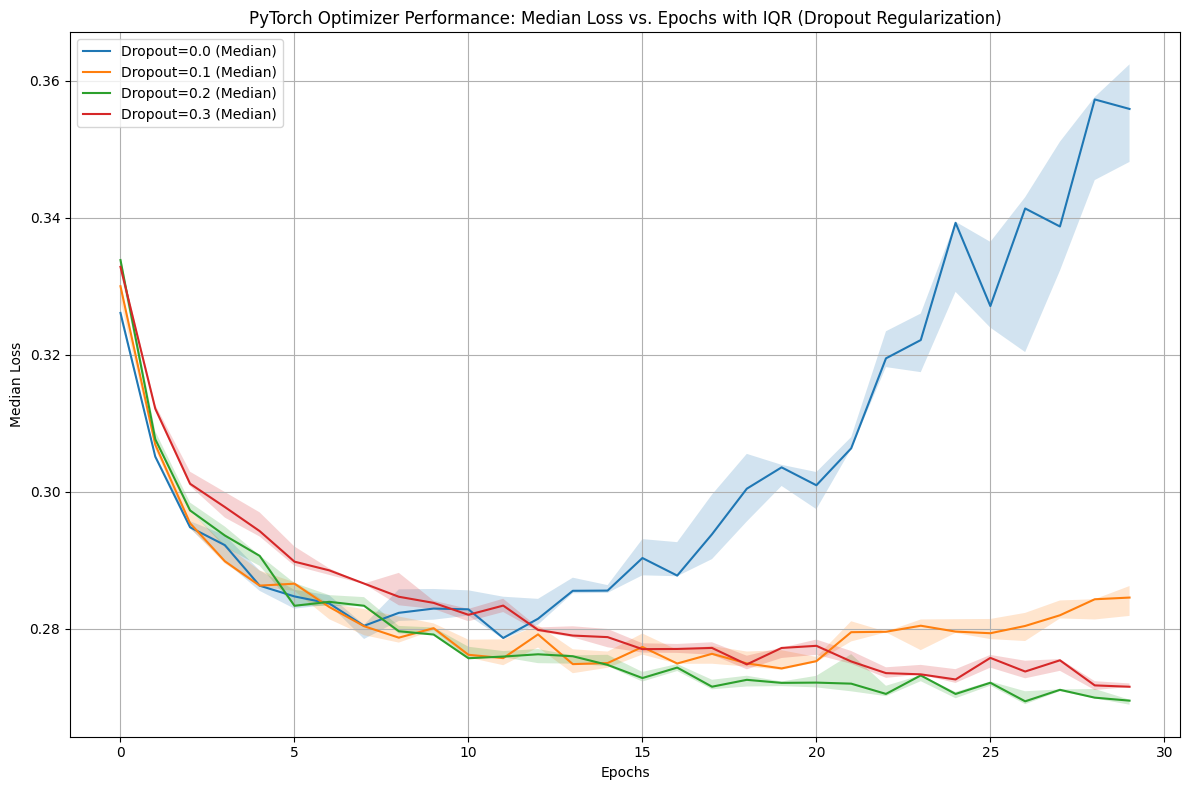

  Plot saved to: figures/hotelbooking_part3_pytorch_dropout_val_loss_vs_time.png


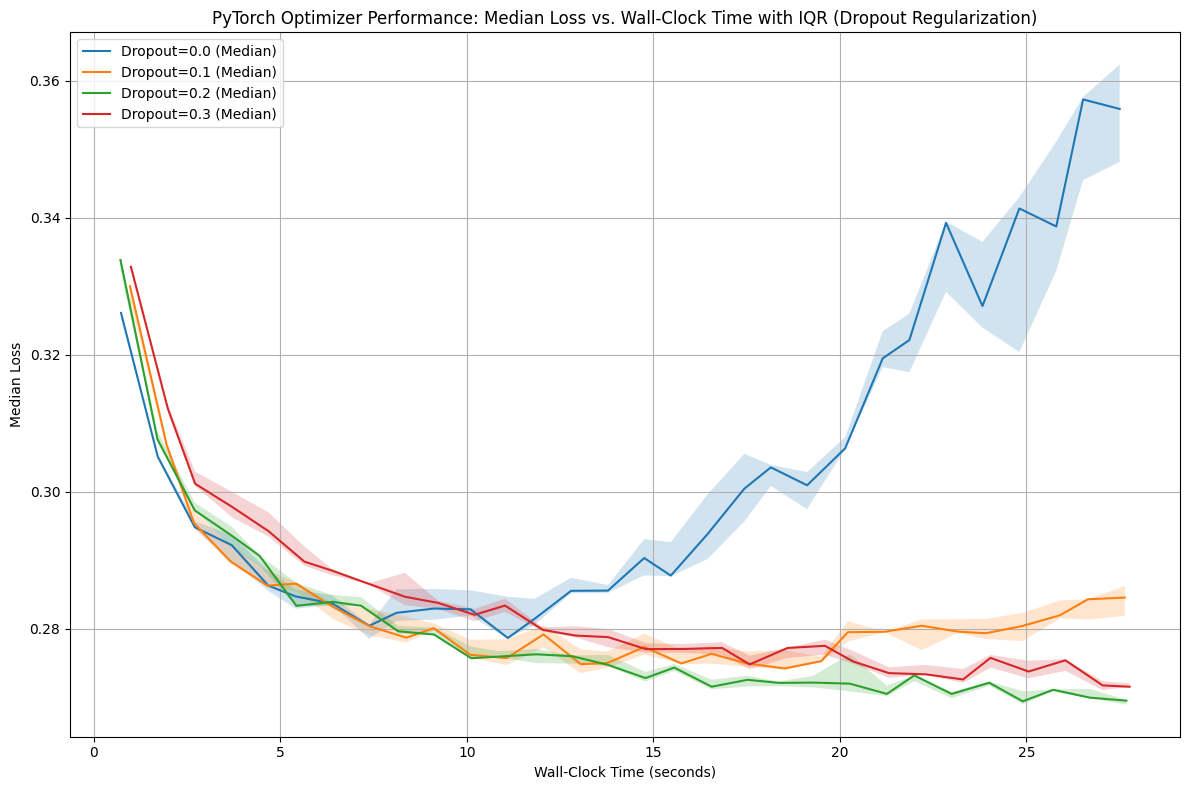

  Plot saved to: figures/hotelbooking_part3_pytorch_dropout_val_loss_vs_grads.png


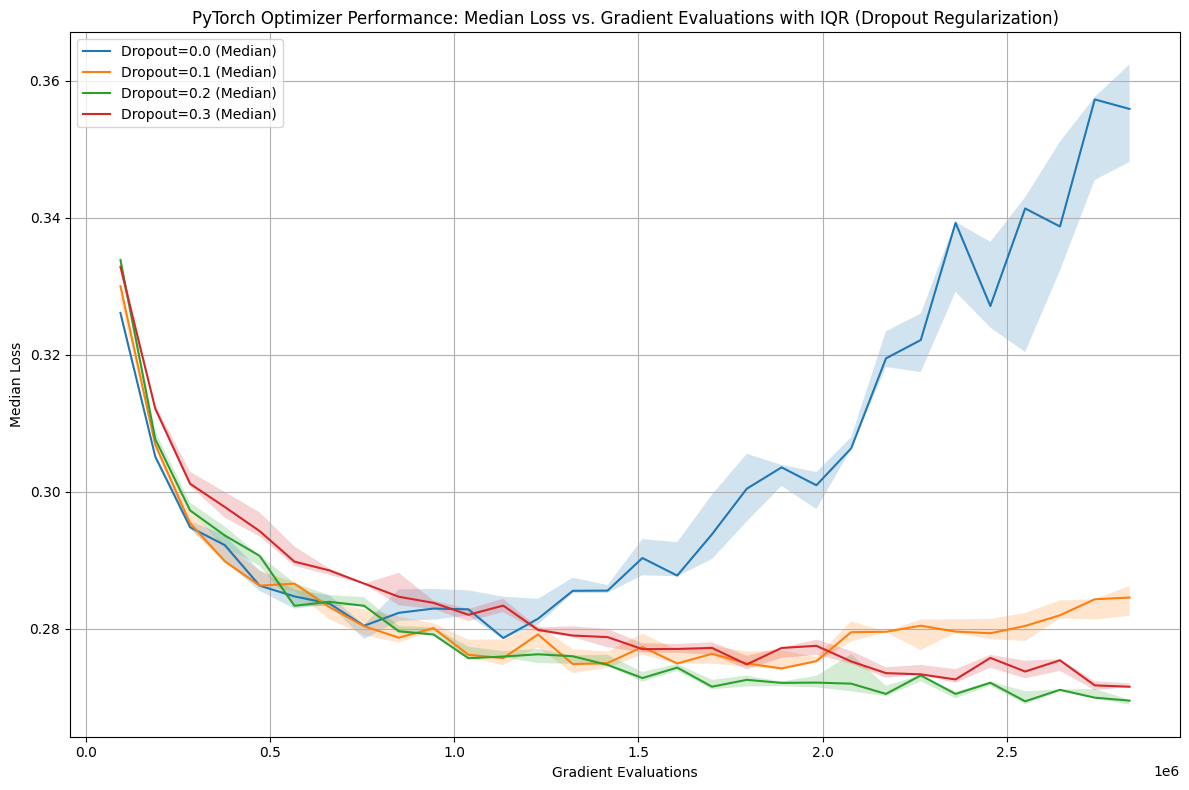

  Plot saved to: figures/hotelbooking_part3_pytorch_dropout_val_auroc_vs_epochs.png


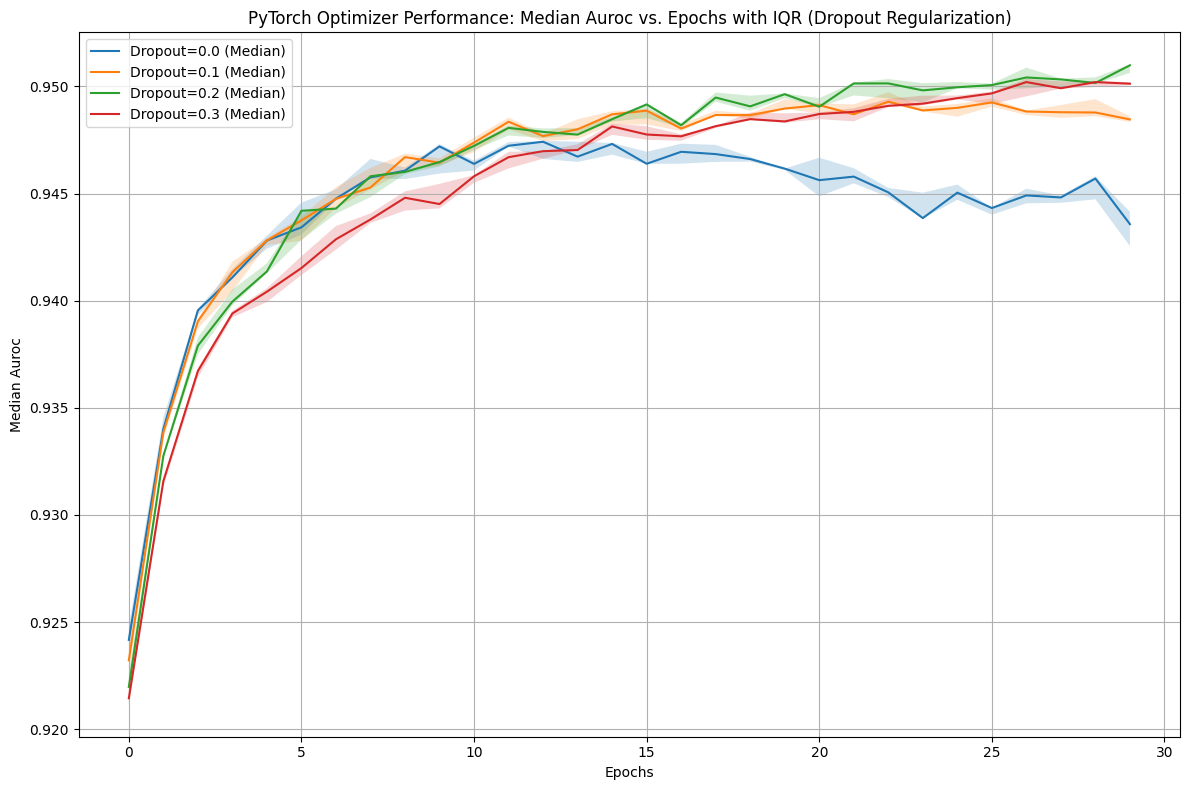

  Plot saved to: figures/hotelbooking_part3_pytorch_dropout_val_auroc_vs_time.png


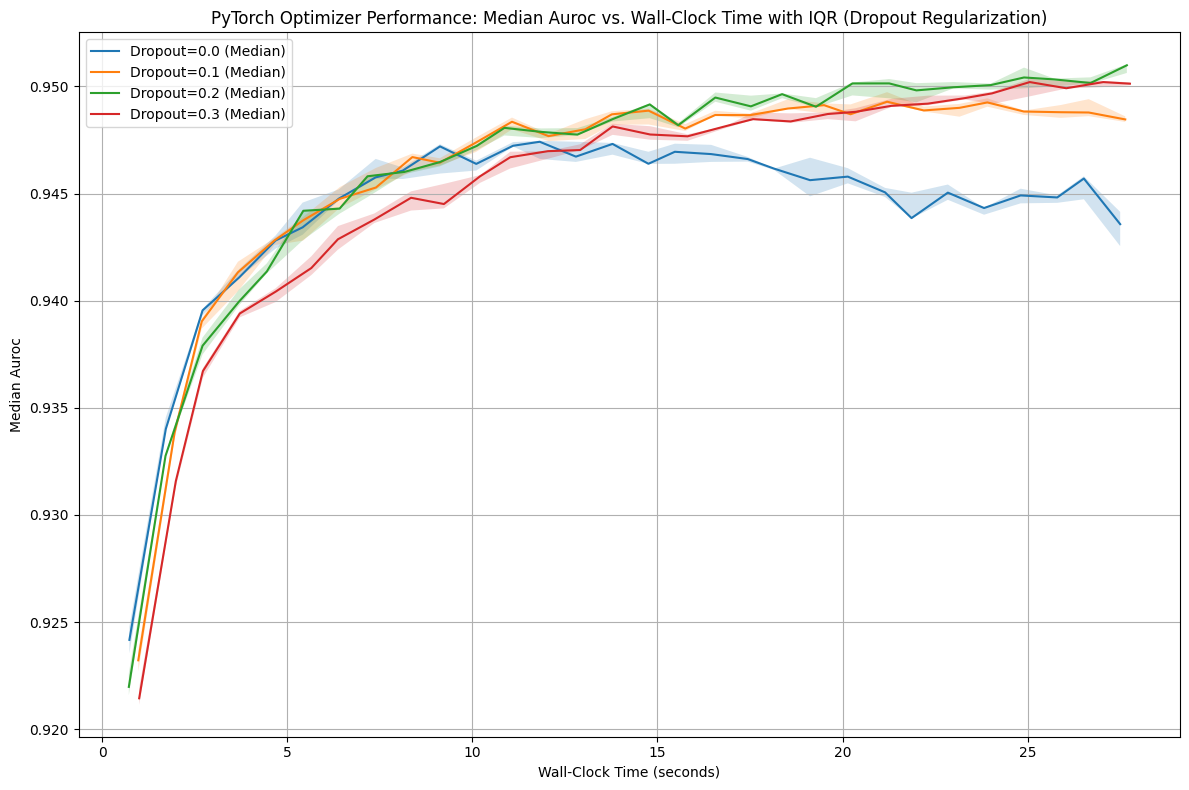

  Plot saved to: figures/hotelbooking_part3_pytorch_dropout_val_auroc_vs_grads.png


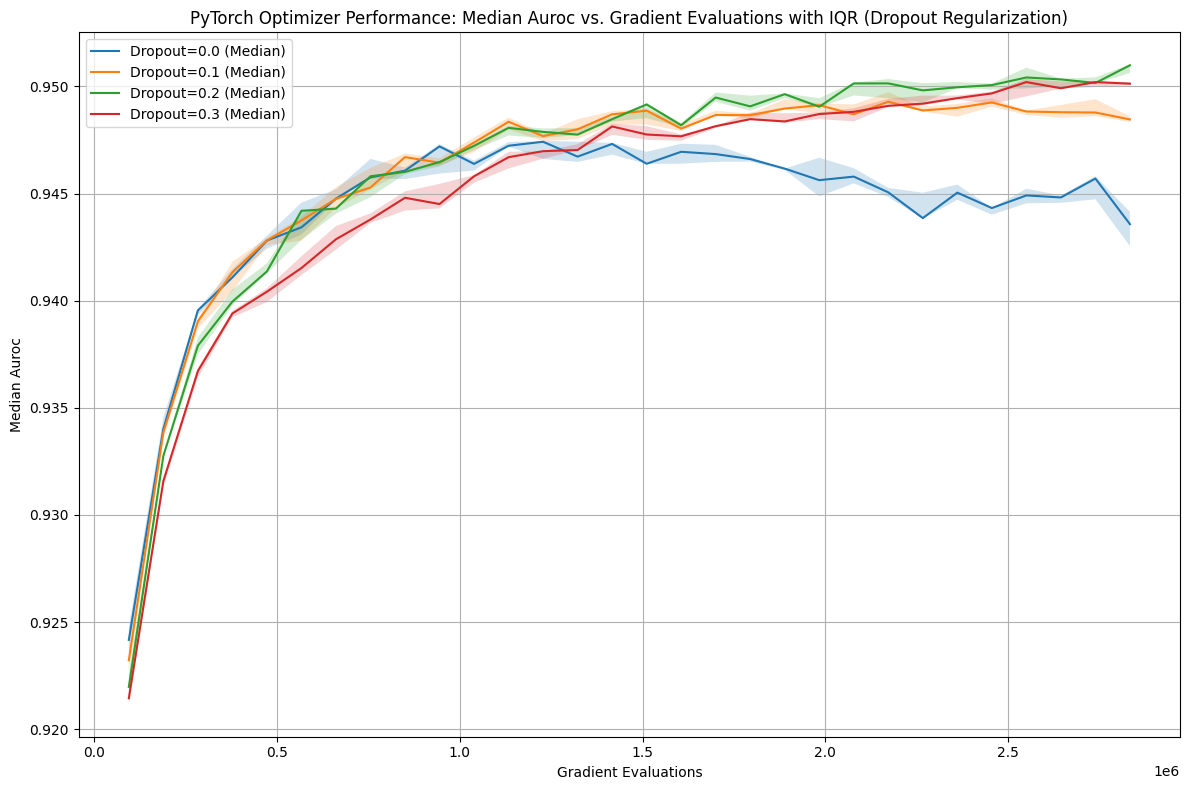


Finished generating Dropout regularization performance plots.


In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import json

# Define the directory for logs and figures
logs_dir = 'logs'
figures_dir = 'figures'
os.makedirs(figures_dir, exist_ok=True)
dataset_name = 'hotelbooking'

# Load the Dropout training history if not already loaded
if 'dropout_training_history' not in locals():
    dropout_history_path_pt = os.path.join(logs_dir, f'{dataset_name}_part3_pytorch_dropout_training_history.json')
    dropout_training_history = {}
    if os.path.exists(dropout_history_path_pt):
        with open(dropout_history_path_pt, 'r') as f:
            dropout_training_history = json.load(f)
        print(f"Dropout training history loaded from: {dropout_history_path_pt}")
    else:
        print(f"Error: Dropout training history file not found at {dropout_history_path_pt}")


print("\nAggregating Dropout training history and calculating median/IQR...")

# Dictionary to store aggregated performance summaries for Dropout experiments
dropout_aggregated_performance = {}

# Iterate through each dropout rate's history
for dropout_rate_str, seed_histories in dropout_training_history.items():
    dropout_rate = float(dropout_rate_str) # Convert string key back to float
    print(f"  Aggregating history for Dropout Rate: {dropout_rate}...")

    # Convert history for each seed into a DataFrame and align by epoch
    seed_dfs = []
    for seed_str, history_data in seed_histories.items():
        seed = int(seed_str) # Convert seed string key back to int
        df = pd.DataFrame(history_data)
        df['epoch'] = df.index
        # Rename columns to include seed for uniqueness before merging
        df = df.rename(columns={col: f'{col}_seed{seed}' for col in df.columns if col != 'epoch'})
        seed_dfs.append(df)

    # Merge DataFrames from all seeds for this dropout rate based on epoch
    merged_df = seed_dfs[0] if seed_dfs else pd.DataFrame()
    for i in range(1, len(seed_dfs)):
        merged_df = pd.merge(merged_df, seed_dfs[i], on='epoch', how='outer')

    # Sort by epoch to ensure correct order
    merged_df = merged_df.sort_values('epoch')
    merged_df = merged_df.set_index('epoch')

    # Forward-fill any missing values (due to outer join)
    merged_df = merged_df.ffill()

    # Calculate median and IQR for each metric across seeds
    metrics_to_aggregate = [col.replace(f'_seed{list(seed_histories.keys())[0]}', '') for col in merged_df.columns if '_seed' in col]
    metrics_to_aggregate = list(set(metrics_to_aggregate)) # Get unique metric names

    summary_data = {}
    for metric in metrics_to_aggregate:
        # Select columns for the current metric across all seeds
        metric_cols = [col for col in merged_df.columns if col.startswith(f'{metric}_seed')]

        if metric_cols:
            # Calculate median and IQR
            summary_data[f'{metric}_median'] = merged_df[metric_cols].median(axis=1)
            summary_data[f'{metric}_q1'] = merged_df[metric_cols].quantile(0.25, axis=1)
            summary_data[f'{metric}_q3'] = merged_df[metric_cols].quantile(0.75, axis=1)
            summary_data[f'{metric}_iqr'] = summary_data[f'{metric}_q3'] - summary_data[f'{metric}_q1']

    # Create the aggregated performance DataFrame for this dropout rate
    dropout_aggregated_performance[dropout_rate] = pd.DataFrame(summary_data)

    print(f"  Aggregation complete for Dropout Rate: {dropout_rate}.")

print("\nFinished aggregating training history for all dropout rates.")

# Display a sample of one aggregated performance dataframe
if dropout_aggregated_performance:
    first_rate = list(dropout_aggregated_performance.keys())[0]
    print(f"\nSample of aggregated performance DataFrame for Dropout Rate: {first_rate}")
    display(dropout_aggregated_performance[first_rate].head())


# --- Plot Performance Metrics vs. Epochs and Compute ---

print("\nGenerating Dropout regularization performance plots...")

metrics_to_plot = ['val_loss', 'val_auroc'] # Metrics to visualize

for metric in metrics_to_plot:
    # Plot vs. Epochs
    plt.figure(figsize=(12, 8))
    for dropout_rate, summary_df in dropout_aggregated_performance.items():
        if f'{metric}_median' in summary_df.columns:
            epochs = summary_df.index
            median_metric = summary_df[f'{metric}_median']
            q1_metric = summary_df[f'{metric}_q1']
            q3_metric = summary_df[f'{metric}_q3']

            plt.plot(epochs, median_metric, label=f'Dropout={dropout_rate} (Median)')
            plt.fill_between(epochs, q1_metric, q3_metric, alpha=0.2)

    plt.xlabel("Epochs")
    plt.ylabel(f"Median {metric.replace('val_', '').replace('_', ' ').title()}")
    plt.title(f"PyTorch Optimizer Performance: Median {metric.replace('val_', '').replace('_', ' ').title()} vs. Epochs with IQR (Dropout Regularization)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plot_path_epoch = os.path.join(figures_dir, f'{dataset_name}_part3_pytorch_dropout_{metric}_vs_epochs.png')
    plt.savefig(plot_path_epoch)
    print(f"  Plot saved to: {plot_path_epoch}")
    plt.show()

    # Plot vs. Wall-Clock Time
    plt.figure(figsize=(12, 8))
    for dropout_rate, summary_df in dropout_aggregated_performance.items():
        if f'{metric}_median' in summary_df.columns and 'wall_clock_time_median' in summary_df.columns:
            wall_clock_time = summary_df['wall_clock_time_median']
            median_metric = summary_df[f'{metric}_median']
            q1_metric = summary_df[f'{metric}_q1']
            q3_metric = summary_df[f'{metric}_q3']

            plt.plot(wall_clock_time, median_metric, label=f'Dropout={dropout_rate} (Median)')
            plt.fill_between(wall_clock_time, q1_metric, q3_metric, alpha=0.2)

    plt.xlabel("Wall-Clock Time (seconds)")
    plt.ylabel(f"Median {metric.replace('val_', '').replace('_', ' ').title()}")
    plt.title(f"PyTorch Optimizer Performance: Median {metric.replace('val_', '').replace('_', ' ').title()} vs. Wall-Clock Time with IQR (Dropout Regularization)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plot_path_time = os.path.join(figures_dir, f'{dataset_name}_part3_pytorch_dropout_{metric}_vs_time.png')
    plt.savefig(plot_path_time)
    print(f"  Plot saved to: {plot_path_time}")
    plt.show()

    # Plot vs. Gradient Evaluations
    plt.figure(figsize=(12, 8))
    for dropout_rate, summary_df in dropout_aggregated_performance.items():
         if f'{metric}_median' in summary_df.columns and 'gradient_evals_median' in summary_df.columns:
              gradient_evals = summary_df['gradient_evals_median']
              median_metric = summary_df[f'{metric}_median']
              q1_metric = summary_df[f'{metric}_q1']
              q3_metric = summary_df[f'{metric}_q3']

              plt.plot(gradient_evals, median_metric, label=f'Dropout={dropout_rate} (Median)')
              plt.fill_between(gradient_evals, q1_metric, q3_metric, alpha=0.2)

    plt.xlabel("Gradient Evaluations")
    plt.ylabel(f"Median {metric.replace('val_', '').replace('_', ' ').title()}")
    plt.title(f"PyTorch Optimizer Performance: Median {metric.replace('val_', '').replace('_', ' ').title()} vs. Gradient Evaluations with IQR (Dropout Regularization)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plot_path_grads = os.path.join(figures_dir, f'{dataset_name}_part3_pytorch_dropout_{metric}_vs_grads.png')
    plt.savefig(plot_path_grads)
    print(f"  Plot saved to: {plot_path_grads}")
    plt.show()


print("\nFinished generating Dropout regularization performance plots.")

### Experiment 4: Label Smoothing

Implement and experiment with Label Smoothing as a regularization technique for the classification task. Modify the loss function to incorporate label smoothing and run experiments with different label smoothing values using the best Adam optimizer. Document the values used.

In [46]:
import torch
import torch.nn as nn
import torch.optim as optim
import os
import numpy as np
import time
import pandas as pd
import json
from torch.utils.data import TensorDataset, DataLoader
from torch.nn import functional as F # Import functional for label smoothing

# Define the directory for saving logs and artifacts
logs_dir = 'logs'
artifacts_dir = 'artifacts'
os.makedirs(logs_dir, exist_ok=True)
os.makedirs(artifacts_dir, exist_ok=True)

# Define the dataset name for file paths
dataset_name = 'hotelbooking'

# Load the best Adam hyperparameters (assuming they are available from previous steps)
# best_adam_lr, best_adam_beta1, best_adam_beta2, best_adam_epsilon, best_adam_weight_decay
# are expected to be loaded in a preceding cell.

# Define training parameters
ls_train_epochs = 30 # Use the same epoch budget as Part 2 full runs
batch_size = 2048 # Use the same batch size
full_train_seeds = [11, 23, 47] # Use the same seeds
seed_registry['part_seeds']['Part 3 (PyTorch) - Label Smoothing'] = full_train_seeds


# Define the base loss function (before smoothing)
base_criterion = nn.BCEWithLogitsLoss()

# Define evaluation metric function (from Part 2)
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, average_precision_score

def evaluate_model(model, X_tensor, y_tensor, criterion):
    model.eval() # Set model to evaluation mode
    with torch.no_grad():
        # Ensure X_tensor has the correct shape for the model (remove extra dimension if present)
        if X_tensor.dim() == 3:
             X_tensor = X_tensor.squeeze(1) # Remove the extra dimension


        outputs = model(X_tensor)
        loss = criterion(outputs, y_tensor).item()
        probs = torch.sigmoid(outputs).cpu().numpy()
        labels = y_tensor.cpu().numpy()

        # Calculate metrics
        acc = accuracy_score(labels, (probs > 0.5).astype(int))
        try:
            auroc = roc_auc_score(labels, probs)
        except ValueError:
            auroc = np.nan # Handle case with only one class present

        preds = (probs > 0.5).astype(int)
        macro_f1 = f1_score(labels, preds, average='macro')
        pr_auc = average_precision_score(labels, probs)

    return loss, acc, auroc, macro_f1, pr_auc

# --- Label Smoothing Implementation ---
# Label smoothing modifies the target labels. For binary classification with BCEWithLogitsLoss,
# the target labels are typically 0 or 1. With label smoothing, they become `smooth_factor`
# for the positive class and `1 - smooth_factor` for the negative class, or more generally
# `(1-epsilon) * target + epsilon / num_classes`. For binary (num_classes=2), this is
# `(1-epsilon) * target + epsilon / 2`.

def label_smoothed_bce_loss(outputs, labels, epsilon=0.1):
    """
    Calculates Binary Cross-Entropy loss with label smoothing.

    Args:
        outputs (torch.Tensor): Logits from the model.
        labels (torch.Tensor): Original binary labels (0 or 1).
        epsilon (float): Smoothing factor.

    Returns:
        torch.Tensor: The label-smoothed BCE loss.
    """
    # Target for smoothing: (1-epsilon) * target + epsilon / num_classes
    # For binary classification, num_classes = 2
    num_classes = 2
    smooth_labels = (1 - epsilon) * labels + epsilon / num_classes

    # Use BCEWithLogitsLoss with the smoothed targets
    # This is equivalent to applying sigmoid to outputs and then using BCELoss
    loss = F.binary_cross_entropy_with_logits(outputs, smooth_labels, reduction='mean')
    return loss


# --- Experiment 4: Label Smoothing ---

print("\n--- Running Label Smoothing Experiments ---")

# Define Label Smoothing epsilon search space (including 0 for baseline)
label_smoothing_epsilons = [0.0, 0.05, 0.1]

# Dictionary to store training history for Label Smoothing experiments
ls_training_history = {}

# Dictionary to store training times for Label Smoothing experiments
ls_training_times = {}

for epsilon in label_smoothing_epsilons:
    epsilon_str = str(epsilon).replace('.', 'p') # Create a string representation for filenames
    print(f"\nExperimenting with Label Smoothing Epsilon: {epsilon}")
    ls_training_history[epsilon] = {}
    ls_training_times[epsilon] = {}

    for seed in full_train_seeds:
        print(f"  Running with seed {seed}...")
        set_seed(seed) # Set seed for reproducibility

        # Instantiate a new model for each seed and epsilon (no other regularization here)
        model = RegularizedFullNetwork(input_size, backbone_layer_sizes, output_size)
        model.to(device) # Move model to the correct device

        # Create Adam optimizer with best hyperparameters from Part 2
        optimizer = optim.Adam(model.parameters(),
                               lr=best_adam_lr,
                               betas=(best_adam_beta1, best_adam_beta2),
                               eps=best_adam_epsilon,
                               weight_decay=0) # No weight decay in optimizer for this experiment


        # Lists to store metrics and loss per epoch for this seed
        epoch_history = {
            'train_loss': [],
            'val_loss': [],
            'val_accuracy': [],
            'val_auroc': [],
            'val_macro_f1': [],
            'val_pr_auc': [],
            'wall_clock_time': [], # Time elapsed since start of training for this seed
            'gradient_evals': [] # Added to log gradient evaluations per epoch
        }

        start_time = time.time()
        gradient_evals_counter = 0 # Reset gradient counter per seed

        # Training loop
        for epoch in range(ls_train_epochs):
            model.train() # Set model to training mode
            running_loss = 0.0
            num_batches = 0

            for inputs, labels in train_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                optimizer.zero_grad()
                outputs = model(inputs)
                # Calculate loss using the label smoothed BCE loss function
                loss = label_smoothed_bce_loss(outputs, labels, epsilon=epsilon)
                loss.backward()

                gradient_evals_counter += inputs.size(0) # Increment by batch size

                optimizer.step()

                running_loss += loss.item()
                num_batches += 1

            epoch_train_loss = running_loss / num_batches if num_batches > 0 else 0.0
            epoch_history['train_loss'].append(epoch_train_loss)

            # Evaluate on validation set (X_test_tensor, y_test_tensor) - NO NOISE ON VALIDATION
            # Use the base criterion (without smoothing) for evaluation loss
            val_loss, val_acc, val_auroc, val_macro_f1, val_pr_auc = evaluate_model(model, X_test_tensor, y_test_tensor, base_criterion)

            epoch_history['val_loss'].append(val_loss)
            epoch_history['val_accuracy'].append(val_acc)
            epoch_history['val_auroc'].append(val_auroc)
            epoch_history['val_macro_f1'].append(val_macro_f1)
            epoch_history['val_pr_auc'].append(val_pr_auc)
            epoch_history['wall_clock_time'].append(time.time() - start_time)
            epoch_history['gradient_evals'].append(gradient_evals_counter)


            print(f"    Seed {seed}, Epoch {epoch+1}/{ls_train_epochs}: Train Loss (smoothed): {epoch_train_loss:.4f}, Val Loss (unsmoothed): {val_loss:.4f}, Val AUC: {val_auroc:.4f}")


        # Store the full history for this seed
        ls_training_history[epsilon][seed] = epoch_history
        ls_training_times[epsilon][seed] = epoch_history['wall_clock_time'][-1] # Store total time


print("\nLabel Smoothing experiments finished.")

# Optional: Save training history and times for Label Smoothing experiments
ls_history_path_pt = os.path.join(logs_dir, f'{dataset_name}_part3_pytorch_ls_training_history.json')
with open(ls_history_path_pt, 'w') as f:
    def convert_numpy(obj):
        if isinstance(obj, np.generic):
            return obj.item()
        if isinstance(obj, dict):
            return {k: convert_numpy(v) for k, v in obj.items()}
        if isinstance(obj, list):
            return [convert_numpy(item) for item in obj]
        return obj
    serializable_history = convert_numpy(ls_training_history)
    json.dump(serializable_history, f, indent=4)

print(f"\nLabel Smoothing training history saved to: {ls_history_path_pt}")

ls_times_path_pt = os.path.join(logs_dir, f'{dataset_name}_part3_pytorch_ls_training_times.json')
with open(ls_times_path_pt, 'w') as f:
    json.dump(ls_training_times, f, indent=4)

print(f"Label Smoothing training times saved to: {ls_times_path_pt}")


--- Running Label Smoothing Experiments ---

Experimenting with Label Smoothing Epsilon: 0.0
  Running with seed 11...
    Seed 11, Epoch 1/30: Train Loss (smoothed): 0.4383, Val Loss (unsmoothed): 0.3264, Val AUC: 0.9229
    Seed 11, Epoch 2/30: Train Loss (smoothed): 0.3174, Val Loss (unsmoothed): 0.3057, Val AUC: 0.9340
    Seed 11, Epoch 3/30: Train Loss (smoothed): 0.2975, Val Loss (unsmoothed): 0.2948, Val AUC: 0.9395
    Seed 11, Epoch 4/30: Train Loss (smoothed): 0.2867, Val Loss (unsmoothed): 0.2951, Val AUC: 0.9411
    Seed 11, Epoch 5/30: Train Loss (smoothed): 0.2809, Val Loss (unsmoothed): 0.2848, Val AUC: 0.9433
    Seed 11, Epoch 6/30: Train Loss (smoothed): 0.2717, Val Loss (unsmoothed): 0.2811, Val AUC: 0.9457
    Seed 11, Epoch 7/30: Train Loss (smoothed): 0.2652, Val Loss (unsmoothed): 0.2837, Val AUC: 0.9456
    Seed 11, Epoch 8/30: Train Loss (smoothed): 0.2621, Val Loss (unsmoothed): 0.2807, Val AUC: 0.9458
    Seed 11, Epoch 9/30: Train Loss (smoothed): 0.2586, 

### Analyze Label Smoothing Results

Analyze the training history from the Label Smoothing experiments by aggregating the history across seeds and calculating the median and Interquartile Range (IQR) for relevant metrics (e.g., validation loss, accuracy, AUROC) over epochs and wall-clock time.


Aggregating Label Smoothing training history and calculating median/IQR...
  Aggregating history for Label Smoothing Epsilon: 0.0...
  Aggregation complete for Label Smoothing Epsilon: 0.0.
  Aggregating history for Label Smoothing Epsilon: 0.05...
  Aggregation complete for Label Smoothing Epsilon: 0.05.
  Aggregating history for Label Smoothing Epsilon: 0.1...
  Aggregation complete for Label Smoothing Epsilon: 0.1.

Finished aggregating training history for all label smoothing epsilons.

Sample of aggregated performance DataFrame for Label Smoothing Epsilon: 0.0


wall_clock_time_median  wall_clock_time_q1  wall_clock_time_q3  \
epoch                                                                   
0                    0.982752            0.848638            0.985076   
1                    1.980316            1.835767            2.045293   
2                    2.718204            2.699520            2.778255   
3                    3.720783            3.688411            3.781443   
4                    4.590347            4.480405            4.655338   

       wall_clock_time_iqr  gradient_evals_median  gradient_evals_q1  \
epoch                                                                  
0                 0.136438                94447.0            94447.0   
1                 0.209526               188894.0           188894.0   
2                 0.078736               283341.0           283341.0   
3                 0.093033               377788.0           377788.0   
4                 0.174934               472235.0           472235.0   

       gradient_evals_q3  gradient_evals_iqr  train_loss_median  \
epoch                                                             
0                94447.0                 0.0           0.430902   
1               188894.0                 0.0           0.315426   
2               283341.0                 0.0           0.297346   
3               377788.0                 0.0           0.286478   
4               472235.0                 0.0           0.279206   

       train_loss_q1  train_loss_q3  train_loss_iqr  val_auroc_median  \
epoch                                                                   
0           0.418980       0.434610        0.015630          0.924166   
1           0.314975       0.316419        0.001444          0.934010   
2           0.295820       0.297445        0.001625          0.939544   
3           0.285860       0.286571        0.000711          0.941083   
4           0.279032       0.280029        0.000997          0.942805   

       val_auroc_q1  val_auroc_q3  val_auroc_iqr  val_macro_f1_median  \
epoch                                                                   
0          0.923537      0.924777       0.001240             0.828979   
1          0.933986      0.934550       0.000564             0.842525   
2          0.939312      0.939605       0.000293             0.849844   
3          0.941078      0.941470       0.000393             0.852859   
4          0.942424      0.943036       0.000612             0.855653   

       val_macro_f1_q1  val_macro_f1_q3  val_macro_f1_iqr  val_loss_median  \
epoch                                                                        
0             0.825722         0.832001          0.006279         0.326102   
1             0.840666         0.844103          0.003437         0.305126   
2             0.849446         0.850418          0.000972         0.294821   
3             0.848862         0.853282          0.004420         0.292208   
4             0.854306         0.856562          0.002256         0.286297   

       val_loss_q1  val_loss_q3  val_loss_iqr  val_pr_auc_median  \
epoch                                                              
0         0.325297     0.326242      0.000946           0.894886   
1         0.305082     0.305420      0.000338           0.908217   
2         0.294650     0.295705      0.001055           0.914695   
3         0.289852     0.293663      0.003811           0.917020   
4         0.285537     0.288507      0.002970           0.919415   

       val_pr_auc_q1  val_pr_auc_q3  val_pr_auc_iqr  val_accuracy_median  \
epoch                                                                      
0           0.894087       0.895903        0.001816             0.845375   
1           0.908189       0.908825        0.000636             0.856683   
2           0.914628       0.914698        0.000070             0.862951   
3           0.916755       0.917586        0.000831             0.863417   
4           0.91


Generating Label Smoothing regularization performance plots...
  Plot saved to: figures/hotelbooking_part3_pytorch_ls_val_loss_vs_epochs.png


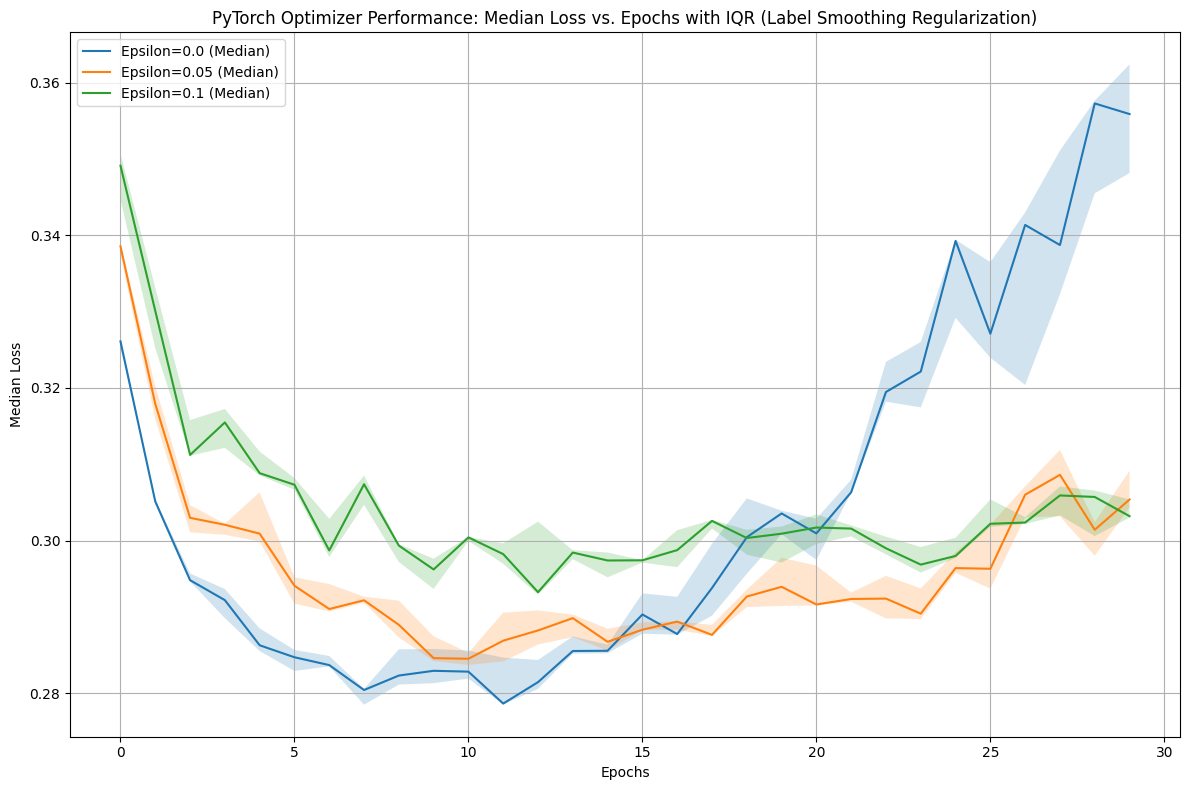

  Plot saved to: figures/hotelbooking_part3_pytorch_ls_val_loss_vs_time.png


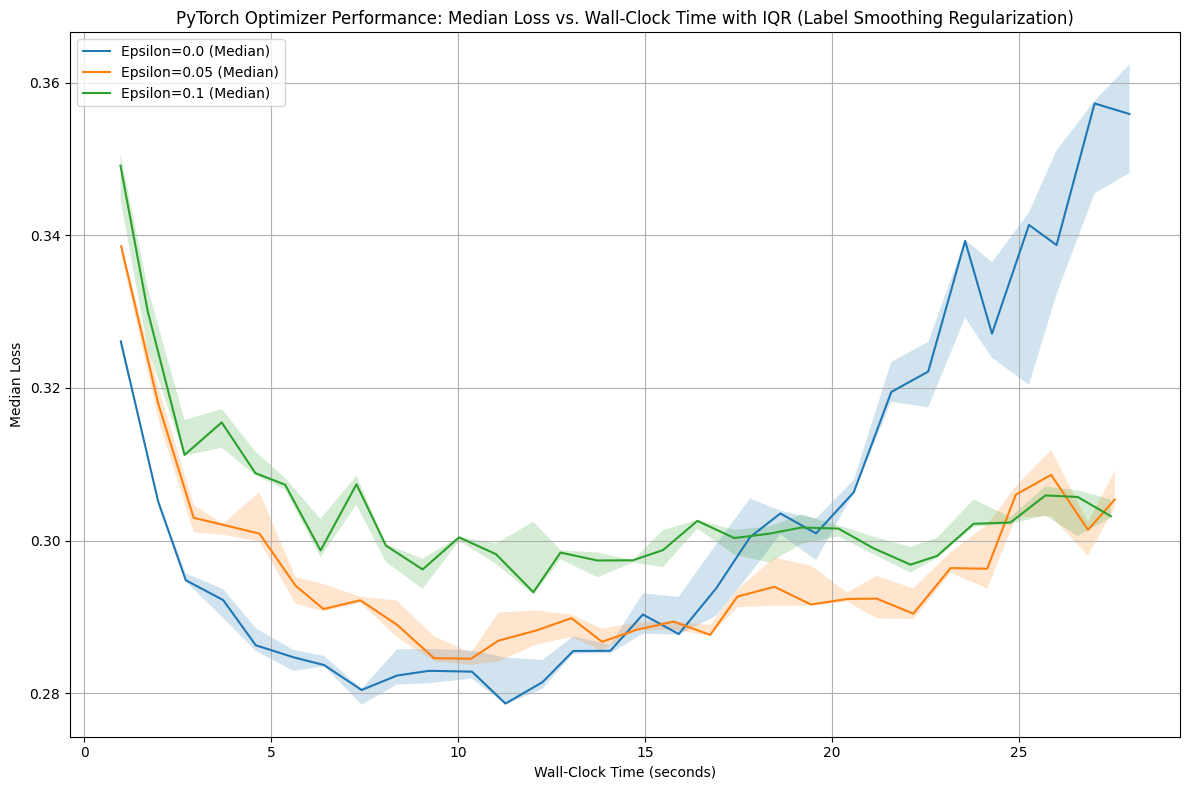

  Plot saved to: figures/hotelbooking_part3_pytorch_ls_val_loss_vs_grads.png


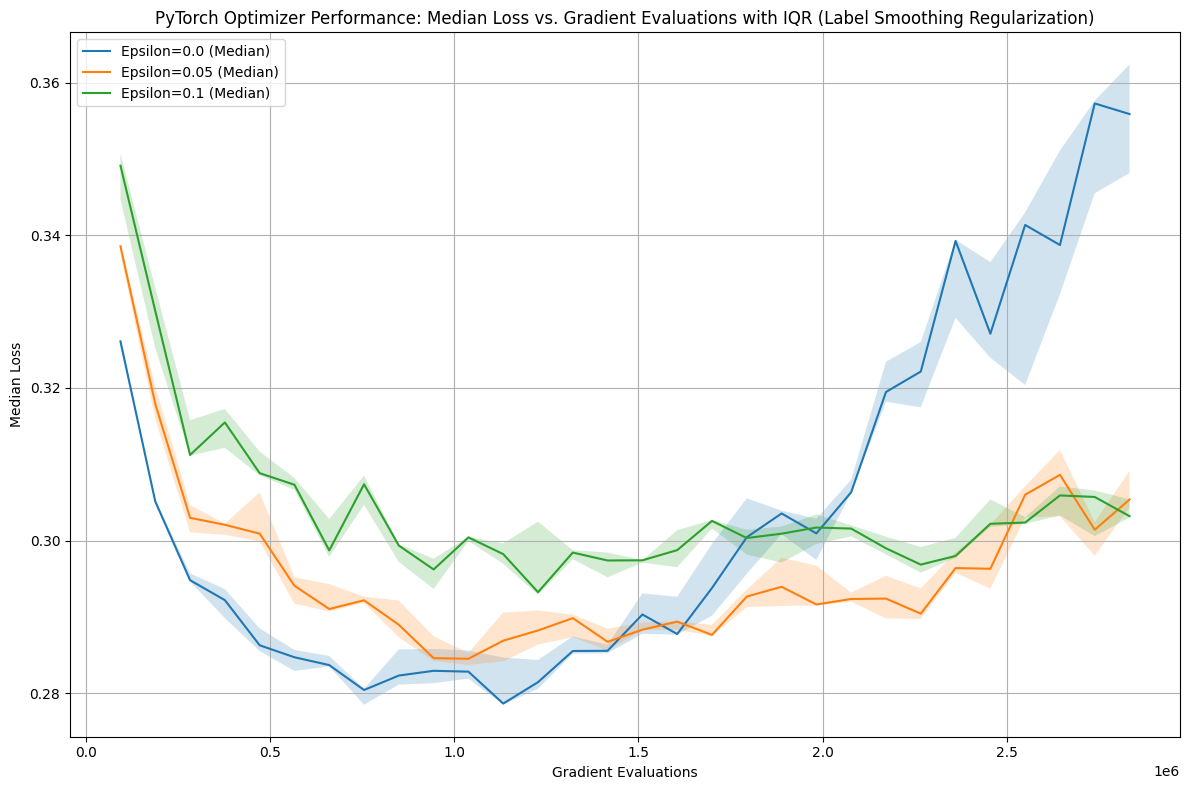

  Plot saved to: figures/hotelbooking_part3_pytorch_ls_val_auroc_vs_epochs.png


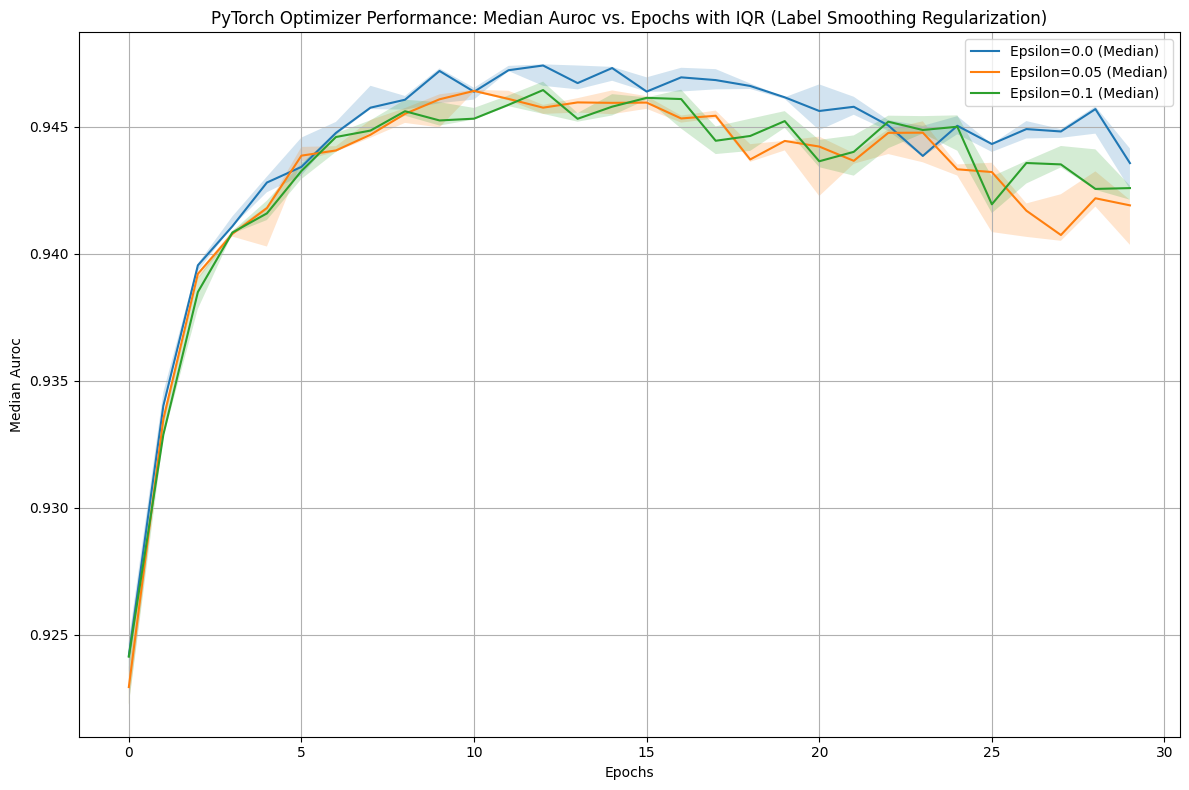

  Plot saved to: figures/hotelbooking_part3_pytorch_ls_val_auroc_vs_time.png


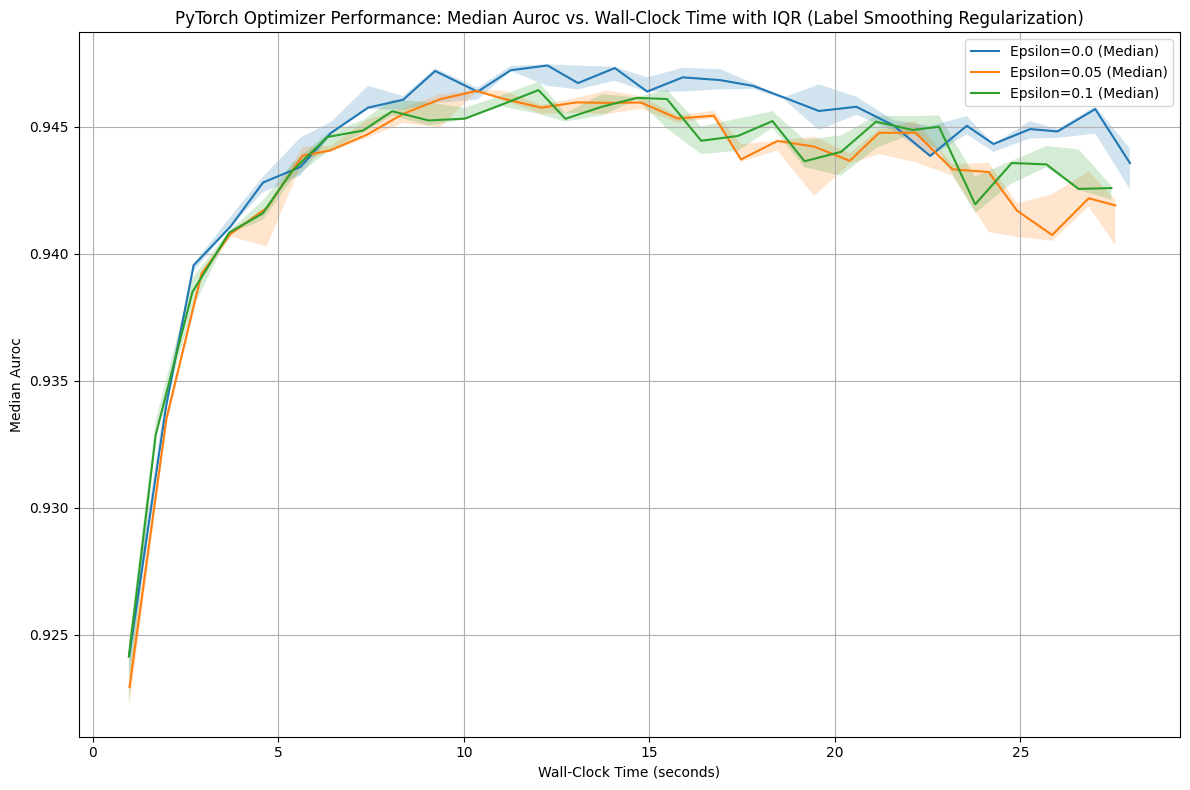

  Plot saved to: figures/hotelbooking_part3_pytorch_ls_val_auroc_vs_grads.png


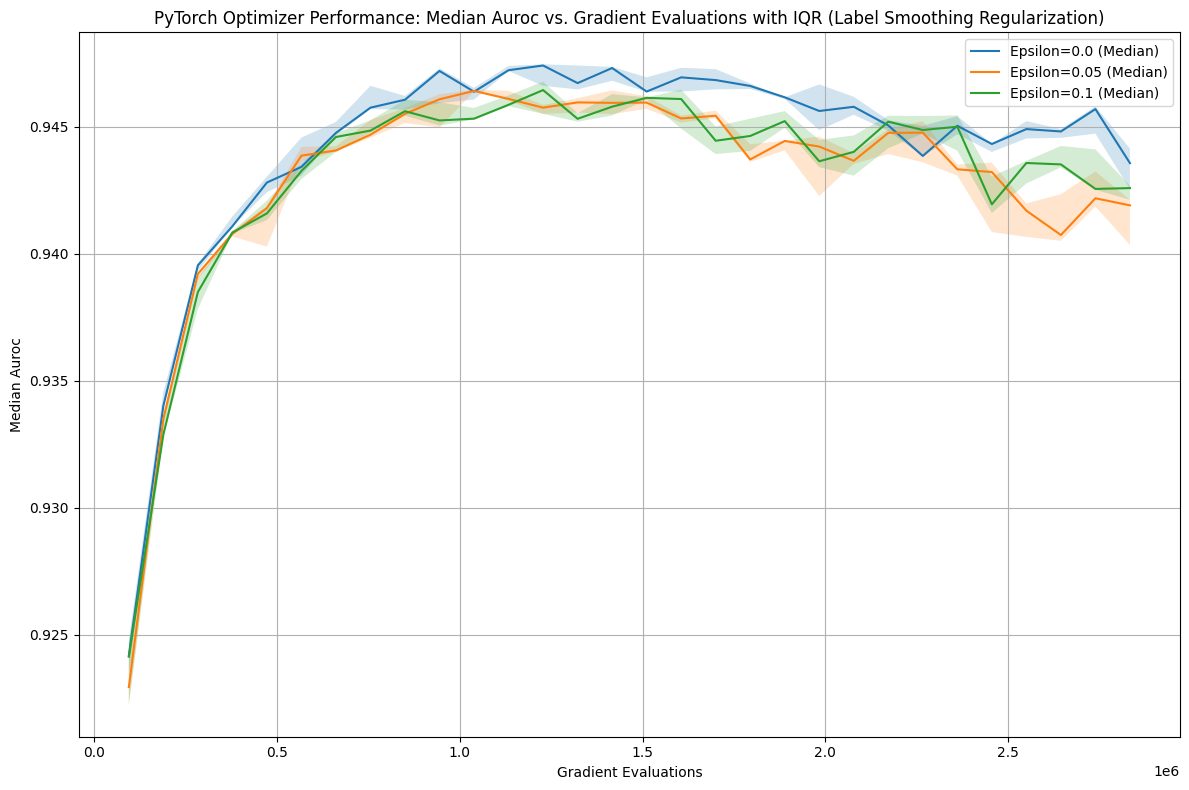


Finished generating Label Smoothing regularization performance plots.


In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import json

# Define the directory for logs and figures
logs_dir = 'logs'
figures_dir = 'figures'
os.makedirs(figures_dir, exist_ok=True)
dataset_name = 'hotelbooking'

# Load the Label Smoothing training history if not already loaded
if 'ls_training_history' not in locals():
    ls_history_path_pt = os.path.join(logs_dir, f'{dataset_name}_part3_pytorch_ls_training_history.json')
    ls_training_history = {}
    if os.path.exists(ls_history_path_pt):
        with open(ls_history_path_pt, 'r') as f:
            ls_training_history = json.load(f)
        print(f"Label Smoothing training history loaded from: {ls_history_path_pt}")
    else:
        print(f"Error: Label Smoothing training history file not found at {ls_history_path_pt}")


print("\nAggregating Label Smoothing training history and calculating median/IQR...")

# Dictionary to store aggregated performance summaries for Label Smoothing experiments
ls_aggregated_performance = {}

# Iterate through each epsilon value's history
for epsilon_str, seed_histories in ls_training_history.items():
    epsilon = float(epsilon_str) # Convert string key back to float
    print(f"  Aggregating history for Label Smoothing Epsilon: {epsilon}...")

    # Convert history for each seed into a DataFrame and align by epoch
    seed_dfs = []
    for seed_str, history_data in seed_histories.items():
        seed = int(seed_str) # Convert seed string key back to int
        df = pd.DataFrame(history_data)
        df['epoch'] = df.index
        # Rename columns to include seed for uniqueness before merging
        df = df.rename(columns={col: f'{col}_seed{seed}' for col in df.columns if col != 'epoch'})
        seed_dfs.append(df)

    # Merge DataFrames from all seeds for this epsilon based on epoch
    merged_df = seed_dfs[0] if seed_dfs else pd.DataFrame()
    for i in range(1, len(seed_dfs)):
        merged_df = pd.merge(merged_df, seed_dfs[i], on='epoch', how='outer')

    # Reset index to make 'epoch' a regular column before sorting
    merged_df = merged_df.reset_index(drop=True)

    # Sort by epoch to ensure correct order
    merged_df = merged_df.sort_values('epoch')
    merged_df = merged_df.set_index('epoch')

    # Forward-fill any missing values (due to outer join)
    merged_df = merged_df.ffill()

    # Calculate median and IQR for each metric across seeds
    metrics_to_aggregate = [col.replace(f'_seed{list(seed_histories.keys())[0]}', '') for col in merged_df.columns if '_seed' in col]
    metrics_to_aggregate = list(set(metrics_to_aggregate)) # Get unique metric names

    summary_data = {}
    for metric in metrics_to_aggregate:
        # Select columns for the current metric across all seeds
        metric_cols = [col for col in merged_df.columns if col.startswith(f'{metric}_seed')]

        if metric_cols:
            # Calculate median and IQR
            summary_data[f'{metric}_median'] = merged_df[metric_cols].median(axis=1)
            summary_data[f'{metric}_q1'] = merged_df[metric_cols].quantile(0.25, axis=1)
            summary_data[f'{metric}_q3'] = merged_df[metric_cols].quantile(0.75, axis=1)
            summary_data[f'{metric}_iqr'] = summary_data[f'{metric}_q3'] - summary_data[f'{metric}_q1']

    # Create the aggregated performance DataFrame for this epsilon
    ls_aggregated_performance[epsilon] = pd.DataFrame(summary_data)

    print(f"  Aggregation complete for Label Smoothing Epsilon: {epsilon}.")

print("\nFinished aggregating training history for all label smoothing epsilons.")

# Display a sample of one aggregated performance dataframe
if ls_aggregated_performance:
    first_epsilon = list(ls_aggregated_performance.keys())[0]
    print(f"\nSample of aggregated performance DataFrame for Label Smoothing Epsilon: {first_epsilon}")
    display(ls_aggregated_performance[first_epsilon].head())


# --- Plot Performance Metrics vs. Epochs and Compute ---

print("\nGenerating Label Smoothing regularization performance plots...")

metrics_to_plot = ['val_loss', 'val_auroc'] # Metrics to visualize

for metric in metrics_to_plot:
    # Plot vs. Epochs
    plt.figure(figsize=(12, 8))
    for epsilon, summary_df in ls_aggregated_performance.items():
        if f'{metric}_median' in summary_df.columns:
            epochs = summary_df.index
            median_metric = summary_df[f'{metric}_median']
            q1_metric = summary_df[f'{metric}_q1']
            q3_metric = summary_df[f'{metric}_q3']

            plt.plot(epochs, median_metric, label=f'Epsilon={epsilon} (Median)')
            plt.fill_between(epochs, q1_metric, q3_metric, alpha=0.2)

    plt.xlabel("Epochs")
    plt.ylabel(f"Median {metric.replace('val_', '').replace('_', ' ').title()}")
    plt.title(f"PyTorch Optimizer Performance: Median {metric.replace('val_', '').replace('_', ' ').title()} vs. Epochs with IQR (Label Smoothing Regularization)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plot_path_epoch = os.path.join(figures_dir, f'{dataset_name}_part3_pytorch_ls_{metric}_vs_epochs.png')
    plt.savefig(plot_path_epoch)
    print(f"  Plot saved to: {plot_path_epoch}")
    plt.show()

    # Plot vs. Wall-Clock Time
    plt.figure(figsize=(12, 8))
    for epsilon, summary_df in ls_aggregated_performance.items():
        if f'{metric}_median' in summary_df.columns and 'wall_clock_time_median' in summary_df.columns:
            wall_clock_time = summary_df['wall_clock_time_median']
            median_metric = summary_df[f'{metric}_median']
            q1_metric = summary_df[f'{metric}_q1']
            q3_metric = summary_df[f'{metric}_q3']

            plt.plot(wall_clock_time, median_metric, label=f'Epsilon={epsilon} (Median)')
            plt.fill_between(wall_clock_time, q1_metric, q3_metric, alpha=0.2)

    plt.xlabel("Wall-Clock Time (seconds)")
    plt.ylabel(f"Median {metric.replace('val_', '').replace('_', ' ').title()}")
    plt.title(f"PyTorch Optimizer Performance: Median {metric.replace('val_', '').replace('_', ' ').title()} vs. Wall-Clock Time with IQR (Label Smoothing Regularization)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plot_path_time = os.path.join(figures_dir, f'{dataset_name}_part3_pytorch_ls_{metric}_vs_time.png')
    plt.savefig(plot_path_time)
    print(f"  Plot saved to: {plot_path_time}")
    plt.show()

    # Plot vs. Gradient Evaluations
    plt.figure(figsize=(12, 8))
    for epsilon, summary_df in ls_aggregated_performance.items():
         if f'{metric}_median' in summary_df.columns and 'gradient_evals_median' in summary_df.columns:
              gradient_evals = summary_df['gradient_evals_median']
              median_metric = summary_df[f'{metric}_median']
              q1_metric = summary_df[f'{metric}_q1']
              q3_metric = summary_df[f'{metric}_q3']

              plt.plot(gradient_evals, median_metric, label=f'Epsilon={epsilon} (Median)')
              plt.fill_between(gradient_evals, q1_metric, q3_metric, alpha=0.2)

    plt.xlabel("Gradient Evaluations")
    plt.ylabel(f"Median {metric.replace('val_', '').replace('_', ' ').title()}")
    plt.title(f"PyTorch Optimizer Performance: Median {metric.replace('val_', '').replace('_', ' ').title()} vs. Gradient Evaluations with IQR (Label Smoothing Regularization)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plot_path_grads = os.path.join(figures_dir, f'{dataset_name}_part3_pytorch_ls_{metric}_vs_grads.png')
    plt.savefig(plot_path_grads)
    print(f"  Plot saved to: {plot_path_grads}")
    plt.show()


print("\nFinished generating Label Smoothing regularization performance plots.")

### Experiment 5: Modality-Appropriate Augmentation/Input Noise (Tabular Feature Noise)

Implement and experiment with adding mild Gaussian noise to the continuous features of the training data as a form of input noise regularization for this tabular dataset. Ensure the noise is only applied during training and not during validation/testing. Document the noise level used.

In [49]:
import torch
import torch.nn as nn
import torch.optim as optim
import os
import numpy as np
import time
import pandas as pd
import json
from torch.utils.data import TensorDataset, DataLoader

# Define the directory for saving logs and artifacts
logs_dir = 'logs'
artifacts_dir = 'artifacts'
os.makedirs(logs_dir, exist_ok=True)
os.makedirs(artifacts_dir, exist_ok=True)

# Define the dataset name for file paths
dataset_name = 'hotelbooking'

# Load the best Adam hyperparameters (assuming they are available from previous steps)
# best_adam_lr, best_adam_beta1, best_adam_beta2, best_adam_epsilon, best_adam_weight_decay
# are expected to be loaded in a preceding cell.

# Define training parameters
noise_train_epochs = 30 # Use the same epoch budget as Part 2 full runs
batch_size = 2048 # Use the same batch size
full_train_seeds = [11, 23, 47] # Use the same seeds
seed_registry['part_seeds']['Part 3 (PyTorch) - Input Noise'] = full_train_seeds

# Define the loss function
criterion = nn.BCEWithLogitsLoss()

# Move data to the correct device and convert to PyTorch tensors and Datasets
X_train_tensor = torch.tensor(X_train.values.astype(np.float32), dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train.values.astype(np.float32), dtype=torch.float32).unsqueeze(1).to(device)
X_test_tensor = torch.tensor(X_test.values.astype(np.float32), dtype=torch.float32).unsqueeze(1).to(device) # Keep test as tensor for evaluation
y_test_tensor = torch.tensor(y_test.values.astype(np.float32), dtype=torch.float32).unsqueeze(1).to(device)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Define evaluation metric function (from Part 2)
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, average_precision_score

def evaluate_model(model, X_tensor, y_tensor, criterion):
    model.eval() # Set model to evaluation mode
    with torch.no_grad():
        # Ensure X_tensor has the correct shape for the model (remove extra dimension if present)
        if X_tensor.dim() == 3:
             X_tensor = X_tensor.squeeze(1) # Remove the extra dimension

        outputs = model(X_tensor)
        loss = criterion(outputs, y_tensor).item()
        probs = torch.sigmoid(outputs).cpu().numpy()
        labels = y_tensor.cpu().numpy()

        # Calculate metrics
        acc = accuracy_score(labels, (probs > 0.5).astype(int))
        try:
            auroc = roc_auc_score(labels, probs)
        except ValueError:
            auroc = np.nan # Handle case with only one class present

        preds = (probs > 0.5).astype(int)
        macro_f1 = f1_score(labels, preds, average='macro')
        pr_auc = average_precision_score(labels, probs)

    return loss, acc, auroc, macro_f1, pr_auc

# --- Experiment 5: Input Noise (Gaussian Noise) ---

print("\n--- Running Input Noise Experiments (Gaussian Noise) ---")

# Define Gaussian noise standard deviation search space (including 0 for baseline)
# The noise should be mild and sensible for the scaled tabular data.
# A small fraction of the standard deviation of the scaled continuous features could be a starting point.
# Assuming 'scaler' and 'numerical_cols' are available from Part 1 preprocessing.
if 'scaler' in locals() and 'numerical_cols' in locals() and len(numerical_cols) > 0:
    # Calculate std dev of scaled numerical features on the training data
    scaled_numerical_train_data = X_train[numerical_cols].values
    std_dev_numerical = np.std(scaled_numerical_train_data)
    print(f"\nStandard deviation of scaled numerical features (training data): {std_dev_numerical:.4f}")

    # Define noise levels as a fraction of the standard deviation
    noise_levels_std_fraction = [0, 0.01, 0.05, 0.1] # Example fractions
    noise_std_devs = [level * std_dev_numerical for level in noise_levels_std_fraction]
    print(f"Gaussian noise standard deviations to experiment with: {noise_std_devs}")

else:
    print("\nWarning: scaler or numerical_cols not found. Using default noise levels.")
    noise_std_devs = [0, 0.01, 0.05, 0.1] # Default values


# Dictionary to store training history for Input Noise experiments
noise_training_history = {}

# Dictionary to store training times for Input Noise experiments
noise_training_times = {}

for noise_std in noise_std_devs:
    noise_std_str = str(noise_std).replace('.', 'p') # Create a string representation for filenames
    print(f"\nExperimenting with Gaussian Noise Std Dev: {noise_std}")
    noise_training_history[noise_std] = {}
    noise_training_times[noise_std] = {}

    for seed in full_train_seeds:
        print(f"  Running with seed {seed}...")
        set_seed(seed) # Set seed for reproducibility

        # Instantiate a new model for each seed (no other regularization here)
        model = RegularizedFullNetwork(input_size, backbone_layer_sizes, output_size)
        model.to(device) # Move model to the correct device

        # Create Adam optimizer with best hyperparameters from Part 2
        optimizer = optim.Adam(model.parameters(),
                               lr=best_adam_lr,
                               betas=(best_adam_beta1, best_adam_beta2),
                               eps=best_adam_epsilon,
                               weight_decay=0) # No weight decay in optimizer for this experiment


        # Lists to store metrics and loss per epoch for this seed
        epoch_history = {
            'train_loss': [],
            'val_loss': [],
            'val_accuracy': [],
            'val_auroc': [],
            'val_macro_f1': [],
            'val_pr_auc': [],
            'wall_clock_time': [], # Time elapsed since start of training for this seed
            'gradient_evals': [] # Added to log gradient evaluations per epoch
        }

        start_time = time.time()
        gradient_evals_counter = 0 # Reset gradient counter per seed

        # Training loop
        for epoch in range(noise_train_epochs):
            model.train() # Set model to training mode
            running_loss = 0.0
            num_batches = 0

            for inputs, labels in train_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                # Add Gaussian noise to continuous features during training
                if noise_std > 0 and 'numerical_cols' in locals() and len(numerical_cols) > 0:
                    # Identify indices of numerical columns
                    numerical_col_indices = [X_train.columns.get_loc(col) for col in numerical_cols]
                    noise = torch.randn_like(inputs[:, numerical_col_indices]) * noise_std
                    inputs[:, numerical_col_indices] = inputs[:, numerical_col_indices] + noise

                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()

                gradient_evals_counter += inputs.size(0) # Increment by batch size

                optimizer.step()

                running_loss += loss.item()
                num_batches += 1

            epoch_train_loss = running_loss / num_batches if num_batches > 0 else 0.0
            epoch_history['train_loss'].append(epoch_train_loss)

            # Evaluate on validation set (X_test_tensor, y_test_tensor) - NO NOISE ON VALIDATION
            val_loss, val_acc, val_auroc, val_macro_f1, val_pr_auc = evaluate_model(model, X_test_tensor.squeeze(1), y_test_tensor, criterion)

            epoch_history['val_loss'].append(val_loss)
            epoch_history['val_accuracy'].append(val_acc)
            epoch_history['val_auroc'].append(val_auroc)
            epoch_history['val_macro_f1'].append(val_macro_f1)
            epoch_history['val_pr_auc'].append(val_pr_auc)
            epoch_history['wall_clock_time'].append(time.time() - start_time)
            epoch_history['gradient_evals'].append(gradient_evals_counter)


            print(f"    Seed {seed}, Epoch {epoch+1}/{noise_train_epochs}: Train Loss: {epoch_train_loss:.4f}, Val Loss: {val_loss:.4f}, Val AUC: {val_auroc:.4f}")


        # Store the full history for this seed
        noise_training_history[noise_std][seed] = epoch_history
        noise_training_times[noise_std][seed] = epoch_history['wall_clock_time'][-1] # Store total time


print("\nInput Noise experiments (Gaussian Noise) finished.")

# Optional: Save training history and times for Input Noise experiments
noise_history_path_pt = os.path.join(logs_dir, f'{dataset_name}_part3_pytorch_noise_training_history.json')
with open(noise_history_path_pt, 'w') as f:
    def convert_numpy(obj):
        if isinstance(obj, np.generic):
            return obj.item()
        if isinstance(obj, dict):
            return {k: convert_numpy(v) for k, v in obj.items()}
        if isinstance(obj, list):
            return [convert_numpy(item) for item in obj]
        return obj
    serializable_history = convert_numpy(noise_training_history)
    json.dump(serializable_history, f, indent=4)

print(f"\nInput Noise training history saved to: {noise_history_path_pt}")

noise_times_path_pt = os.path.join(logs_dir, f'{dataset_name}_part3_pytorch_noise_training_times.json')
with open(noise_times_path_pt, 'w') as f:
    json.dump(noise_training_times, f, indent=4)

print(f"Input Noise training times saved to: {noise_times_path_pt}")

# Log input noise information
log_experiment_result(
    dataset='Hotel Booking',
    part='Part 3 (PyTorch)',
    method='Input Noise (Gaussian)',
    seeds=str(full_train_seeds),
    split='Train/Validation', # Noise applied during training, evaluated on validation
    metrics={'noise_std_devs': noise_std_devs},
    gradient_evals='N/A', # Logged within history
    function_evals='N/A', # Logged within history
    wall_clock_time_s='N/A', # Logged within history
    optimizer_settings='Adam (Best from Part 2)',
    regularizer_settings=f'Gaussian Noise std_devs={noise_std_devs}',
    RO_settings='N/A',
    checkpoint_path='N/A',
    checkpoint_hash='N/A',
    compute_accounting=''
)


--- Running Input Noise Experiments (Gaussian Noise) ---

Standard deviation of scaled numerical features (training data): 1.0000
Gaussian noise standard deviations to experiment with: [np.float64(0.0), np.float64(0.01), np.float64(0.05), np.float64(0.1)]

Experimenting with Gaussian Noise Std Dev: 0.0
  Running with seed 11...
    Seed 11, Epoch 1/30: Train Loss: 0.4383, Val Loss: 0.3264, Val AUC: 0.9229
    Seed 11, Epoch 2/30: Train Loss: 0.3174, Val Loss: 0.3057, Val AUC: 0.9340
    Seed 11, Epoch 3/30: Train Loss: 0.2975, Val Loss: 0.2948, Val AUC: 0.9395
    Seed 11, Epoch 4/30: Train Loss: 0.2867, Val Loss: 0.2951, Val AUC: 0.9411
    Seed 11, Epoch 5/30: Train Loss: 0.2809, Val Loss: 0.2848, Val AUC: 0.9433
    Seed 11, Epoch 6/30: Train Loss: 0.2717, Val Loss: 0.2811, Val AUC: 0.9457
    Seed 11, Epoch 7/30: Train Loss: 0.2652, Val Loss: 0.2837, Val AUC: 0.9456
    Seed 11, Epoch 8/30: Train Loss: 0.2621, Val Loss: 0.2807, Val AUC: 0.9458
    Seed 11, Epoch 9/30: Train Loss: 

### Analyze Input Noise Results

Analyze the training history from the Input Noise experiments by aggregating the history across seeds and calculating the median and Interquartile Range (IQR) for relevant metrics (e.g., validation loss, accuracy, AUROC) over epochs and wall-clock time.


Aggregating Input Noise training history and calculating median/IQR...
  Aggregating history for Gaussian Noise Std Dev: 0.0...
  Aggregation complete for Gaussian Noise Std Dev: 0.0.
  Aggregating history for Gaussian Noise Std Dev: 0.01...
  Aggregation complete for Gaussian Noise Std Dev: 0.01.
  Aggregating history for Gaussian Noise Std Dev: 0.05...
  Aggregation complete for Gaussian Noise Std Dev: 0.05.
  Aggregating history for Gaussian Noise Std Dev: 0.1...
  Aggregation complete for Gaussian Noise Std Dev: 0.1.

Finished aggregating training history for all noise std devs.

Sample of aggregated performance DataFrame for Gaussian Noise Std Dev: 0.0


wall_clock_time_median  wall_clock_time_q1  wall_clock_time_q3  \
epoch                                                                   
0                    1.015785            1.004262            1.035485   
1                    2.007668            1.868811            2.033591   
2                    2.747017            2.735749            2.760001   
3                    3.754044            3.750763            3.766678   
4                    4.758099            4.627278            4.769775   

       wall_clock_time_iqr  gradient_evals_median  gradient_evals_q1  \
epoch                                                                  
0                 0.031223                94447.0            94447.0   
1                 0.164780               188894.0           188894.0   
2                 0.024252               283341.0           283341.0   
3                 0.015915               377788.0           377788.0   
4                 0.142497               472235.0           472235.0   

       gradient_evals_q3  gradient_evals_iqr  train_loss_median  \
epoch                                                             
0                94447.0                 0.0           0.430902   
1               188894.0                 0.0           0.315426   
2               283341.0                 0.0           0.297346   
3               377788.0                 0.0           0.286478   
4               472235.0                 0.0           0.279206   

       train_loss_q1  train_loss_q3  train_loss_iqr  val_auroc_median  \
epoch                                                                   
0           0.418980       0.434610        0.015630          0.924166   
1           0.314975       0.316419        0.001444          0.934010   
2           0.295820       0.297445        0.001625          0.939544   
3           0.285860       0.286571        0.000711          0.941083   
4           0.279032       0.280029        0.000997          0.942805   

       val_auroc_q1  val_auroc_q3  val_auroc_iqr  val_macro_f1_median  \
epoch                                                                   
0          0.923537      0.924777       0.001240             0.828979   
1          0.933986      0.934550       0.000564             0.842525   
2          0.939312      0.939605       0.000293             0.849844   
3          0.941078      0.941470       0.000393             0.852859   
4          0.942424      0.943036       0.000612             0.855653   

       val_macro_f1_q1  val_macro_f1_q3  val_macro_f1_iqr  val_loss_median  \
epoch                                                                        
0             0.825722         0.832001          0.006279         0.326102   
1             0.840666         0.844103          0.003437         0.305126   
2             0.849446         0.850418          0.000972         0.294821   
3             0.848862         0.853282          0.004420         0.292208   
4             0.854306         0.856562          0.002256         0.286297   

       val_loss_q1  val_loss_q3  val_loss_iqr  val_pr_auc_median  \
epoch                                                              
0         0.325297     0.326242      0.000946           0.894886   
1         0.305082     0.305420      0.000338           0.908217   
2         0.294650     0.295705      0.001055           0.914695   
3         0.289852     0.293663      0.003811           0.917020   
4         0.285537     0.288507      0.002970           0.919415   

       val_pr_auc_q1  val_pr_auc_q3  val_pr_auc_iqr  val_accuracy_median  \
epoch                                                                      
0           0.894087       0.895903        0.001816             0.845375   
1           0.908189       0.908825        0.000636             0.856683   
2           0.914628       0.914698        0.000070             0.862951   
3           0.916755       0.917586        0.000831             0.863417   
4           0.91


Generating Input Noise regularization performance plots...
  Plot saved to: figures/hotelbooking_part3_pytorch_noise_val_loss_vs_epochs.png


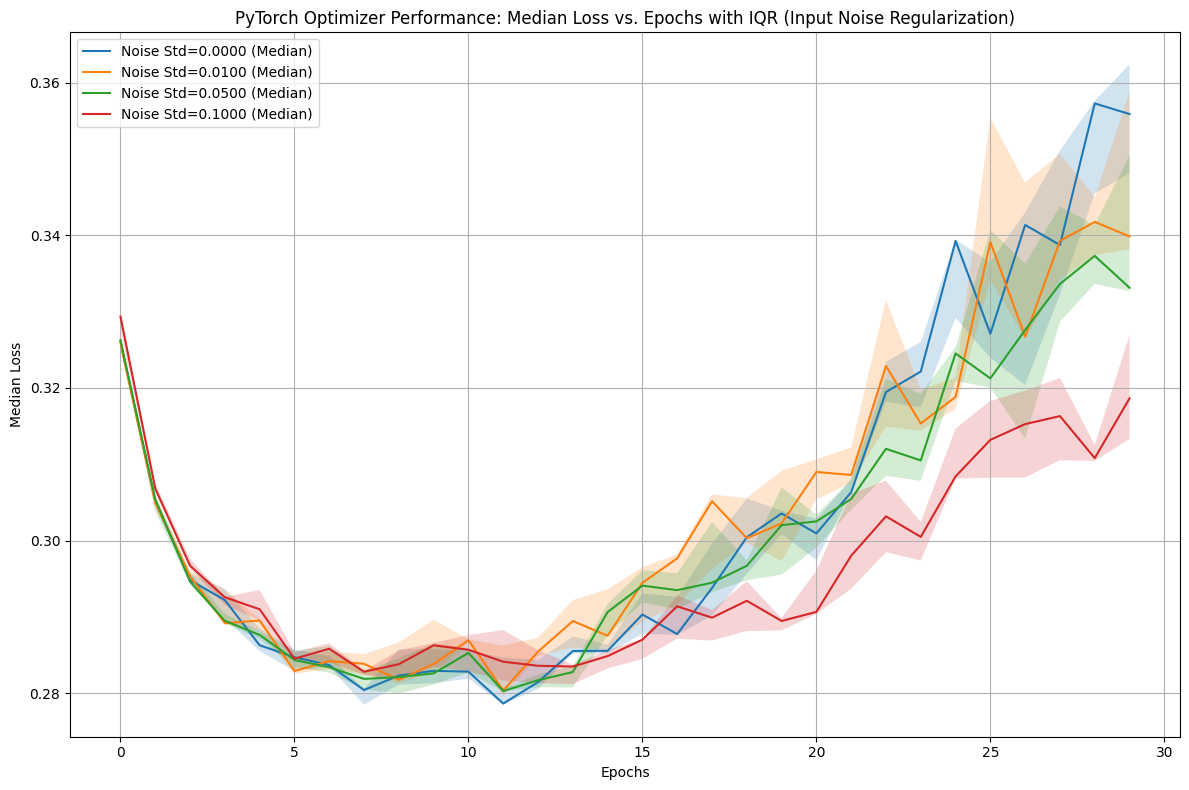

  Plot saved to: figures/hotelbooking_part3_pytorch_noise_val_loss_vs_time.png


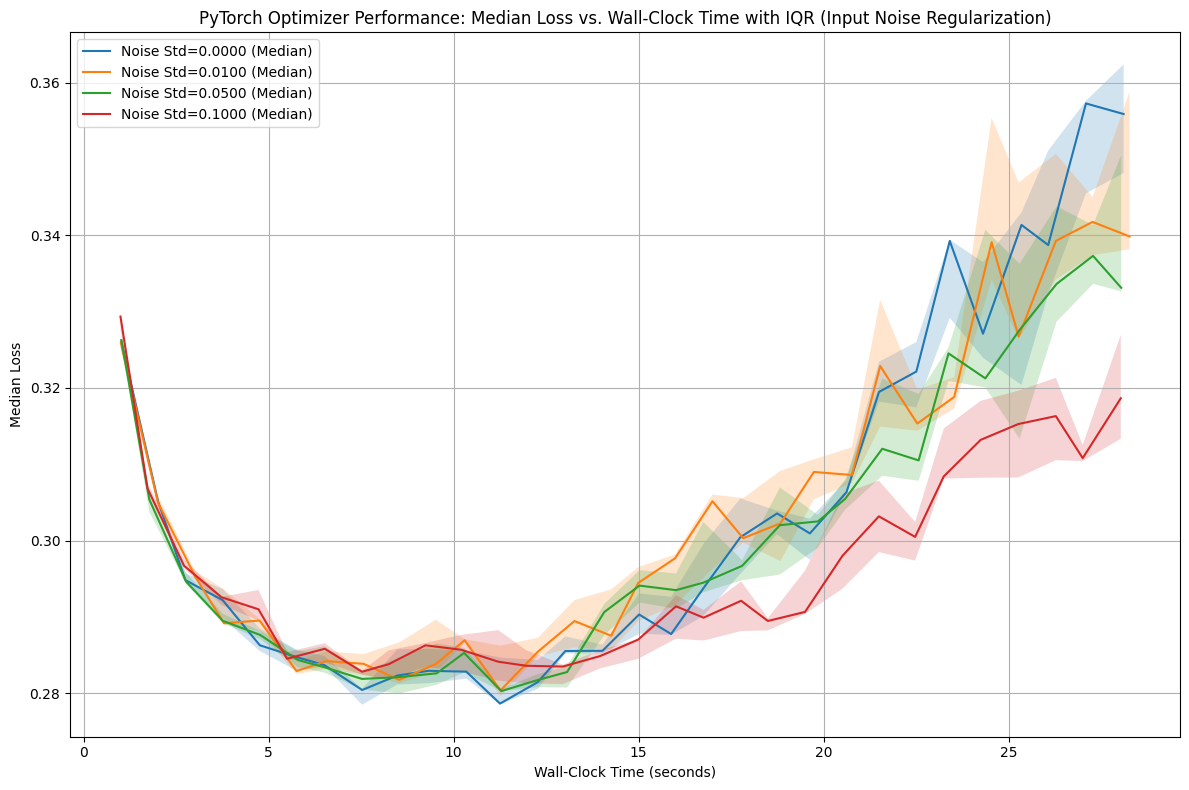

  Plot saved to: figures/hotelbooking_part3_pytorch_noise_val_loss_vs_grads.png


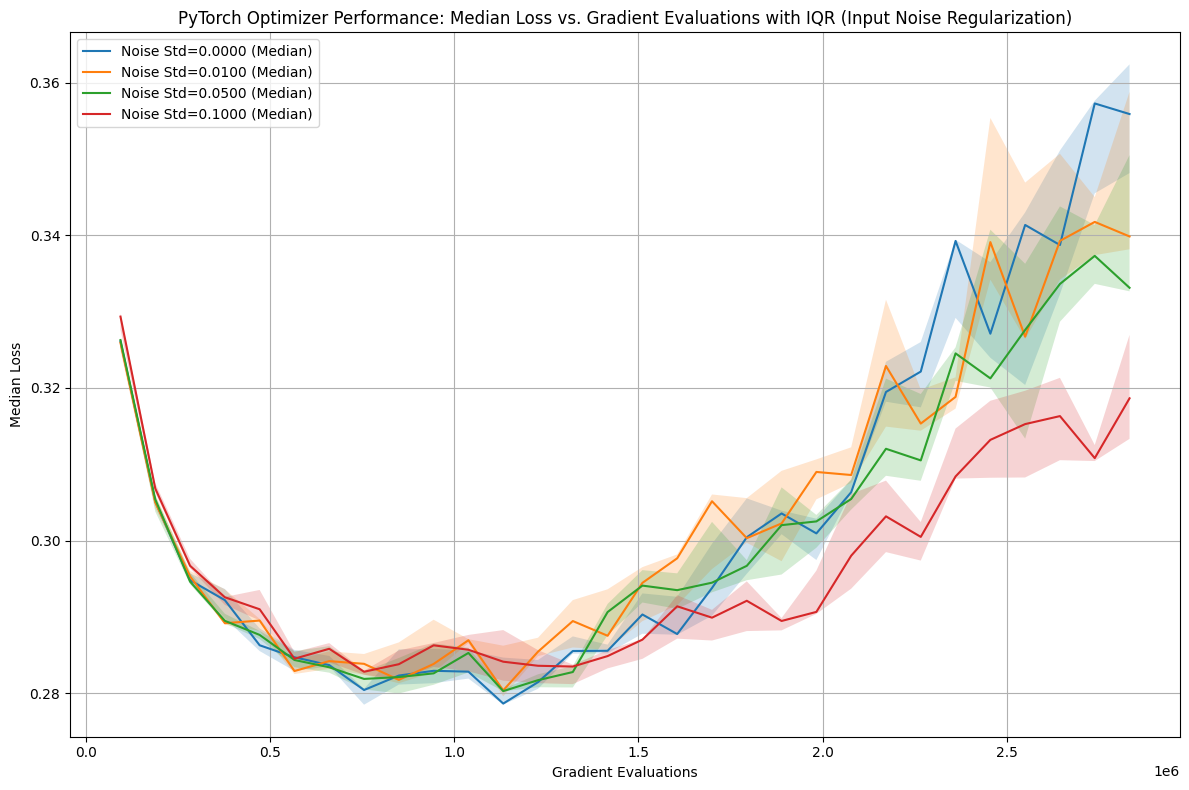

  Plot saved to: figures/hotelbooking_part3_pytorch_noise_val_auroc_vs_epochs.png


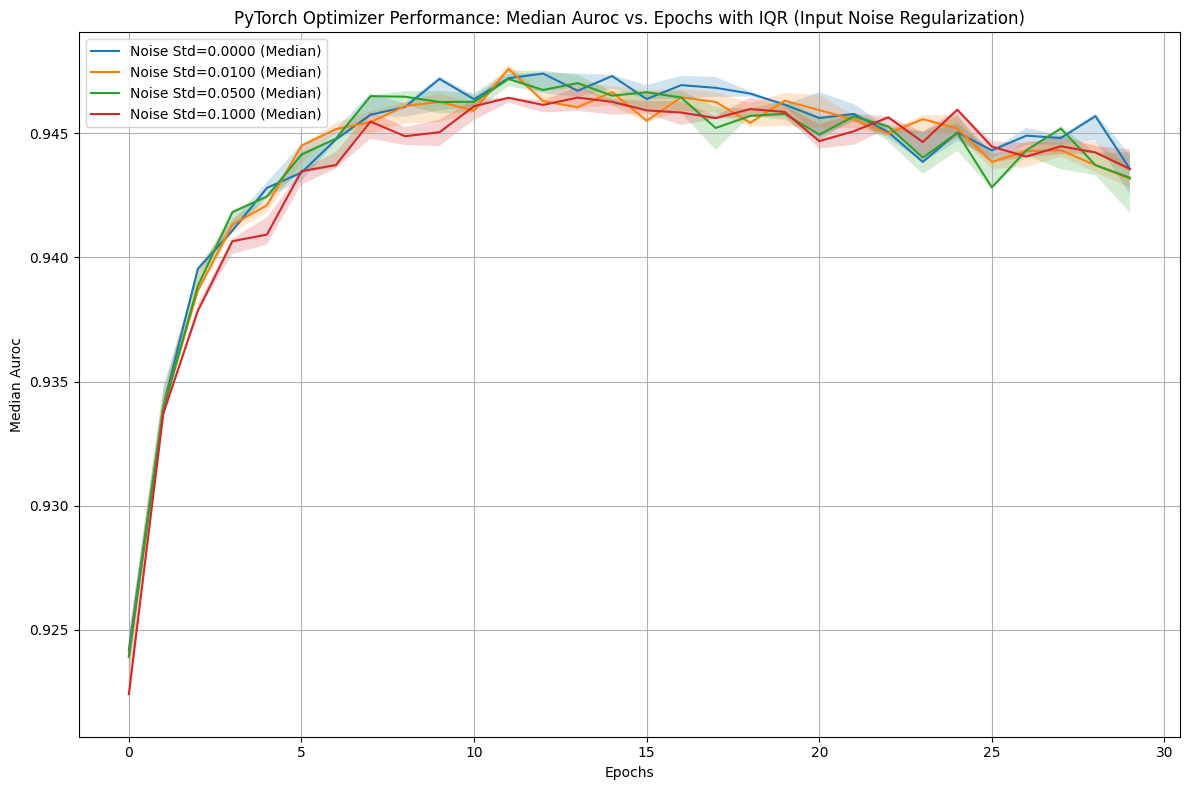

  Plot saved to: figures/hotelbooking_part3_pytorch_noise_val_auroc_vs_time.png


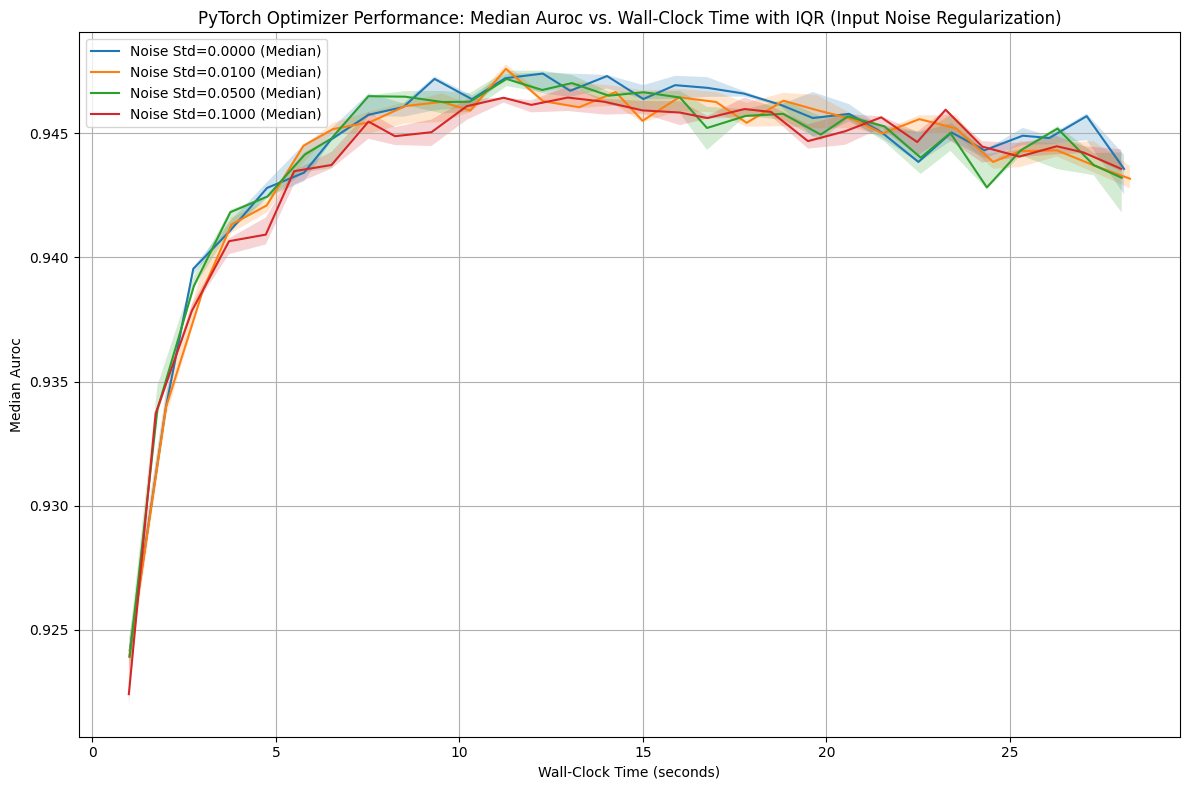

  Plot saved to: figures/hotelbooking_part3_pytorch_noise_val_auroc_vs_grads.png


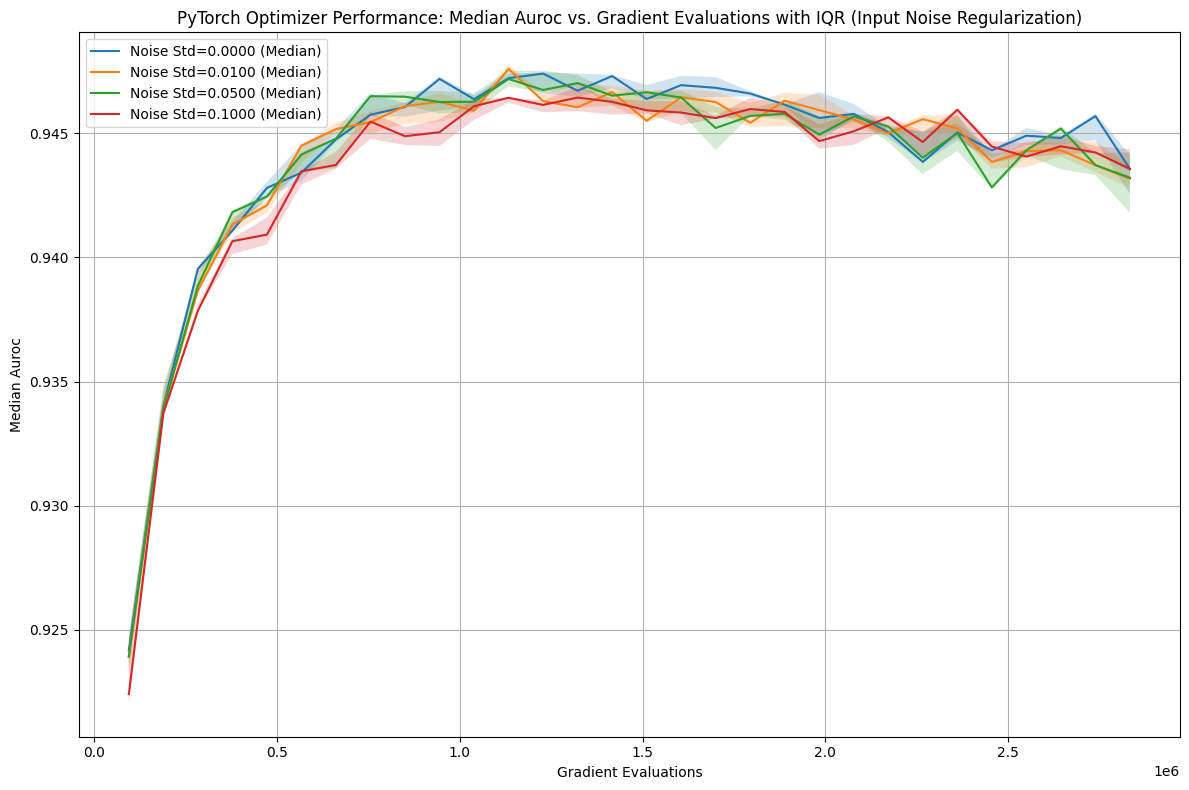


Finished generating Input Noise regularization performance plots.


In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import json

# Define the directory for logs and figures
logs_dir = 'logs'
figures_dir = 'figures'
os.makedirs(figures_dir, exist_ok=True)
dataset_name = 'hotelbooking'

# Load the Input Noise training history if not already loaded
if 'noise_training_history' not in locals():
    noise_history_path_pt = os.path.join(logs_dir, f'{dataset_name}_part3_pytorch_noise_training_history.json')
    noise_training_history = {}
    if os.path.exists(noise_history_path_pt):
        with open(noise_history_path_pt, 'r') as f:
            noise_training_history = json.load(f)
        print(f"Input Noise training history loaded from: {noise_history_path_pt}")
    else:
        print(f"Error: Input Noise training history file not found at {noise_history_path_pt}")


print("\nAggregating Input Noise training history and calculating median/IQR...")

# Dictionary to store aggregated performance summaries for Input Noise experiments
noise_aggregated_performance = {}

# Iterate through each noise std dev's history
for noise_std_str, seed_histories in noise_training_history.items():
    noise_std = float(noise_std_str) # Convert string key back to float
    print(f"  Aggregating history for Gaussian Noise Std Dev: {noise_std}...")

    # Convert history for each seed into a DataFrame and align by epoch
    seed_dfs = []
    for seed_str, history_data in seed_histories.items():
        seed = int(seed_str) # Convert seed string key back to int
        df = pd.DataFrame(history_data)
        df['epoch'] = df.index
        # Rename columns to include seed for uniqueness before merging
        df = df.rename(columns={col: f'{col}_seed{seed}' for col in df.columns if col != 'epoch'})
        seed_dfs.append(df)

    # Merge DataFrames from all seeds for this noise std dev based on epoch
    merged_df = seed_dfs[0] if seed_dfs else pd.DataFrame()
    for i in range(1, len(seed_dfs)):
        merged_df = pd.merge(merged_df, seed_dfs[i], on='epoch', how='outer')

    # Sort by epoch to ensure correct order
    merged_df = merged_df.sort_values('epoch')
    merged_df = merged_df.set_index('epoch')

    # Forward-fill any missing values (due to outer join)
    merged_df = merged_df.ffill()

    # Calculate median and IQR for each metric across seeds
    metrics_to_aggregate = [col.replace(f'_seed{list(seed_histories.keys())[0]}', '') for col in merged_df.columns if '_seed' in col]
    metrics_to_aggregate = list(set(metrics_to_aggregate)) # Get unique metric names

    summary_data = {}
    for metric in metrics_to_aggregate:
        # Select columns for the current metric across all seeds
        metric_cols = [col for col in merged_df.columns if col.startswith(f'{metric}_seed')]

        if metric_cols:
            # Calculate median and IQR
            summary_data[f'{metric}_median'] = merged_df[metric_cols].median(axis=1)
            summary_data[f'{metric}_q1'] = merged_df[metric_cols].quantile(0.25, axis=1)
            summary_data[f'{metric}_q3'] = merged_df[metric_cols].quantile(0.75, axis=1)
            summary_data[f'{metric}_iqr'] = summary_data[f'{metric}_q3'] - summary_data[f'{metric}_q1']

    # Create the aggregated performance DataFrame for this noise std dev
    noise_aggregated_performance[noise_std] = pd.DataFrame(summary_data)

    print(f"  Aggregation complete for Gaussian Noise Std Dev: {noise_std}.")

print("\nFinished aggregating training history for all noise std devs.")

# Display a sample of one aggregated performance dataframe
if noise_aggregated_performance:
    first_std = list(noise_aggregated_performance.keys())[0]
    print(f"\nSample of aggregated performance DataFrame for Gaussian Noise Std Dev: {first_std}")
    display(noise_aggregated_performance[first_std].head())


# --- Plot Performance Metrics vs. Epochs and Compute ---

print("\nGenerating Input Noise regularization performance plots...")

metrics_to_plot = ['val_loss', 'val_auroc'] # Metrics to visualize

for metric in metrics_to_plot:
    # Plot vs. Epochs
    plt.figure(figsize=(12, 8))
    for noise_std, summary_df in noise_aggregated_performance.items():
        if f'{metric}_median' in summary_df.columns:
            epochs = summary_df.index
            median_metric = summary_df[f'{metric}_median']
            q1_metric = summary_df[f'{metric}_q1']
            q3_metric = summary_df[f'{metric}_q3']

            plt.plot(epochs, median_metric, label=f'Noise Std={noise_std:.4f} (Median)')
            plt.fill_between(epochs, q1_metric, q3_metric, alpha=0.2)

    plt.xlabel("Epochs")
    plt.ylabel(f"Median {metric.replace('val_', '').replace('_', ' ').title()}")
    plt.title(f"PyTorch Optimizer Performance: Median {metric.replace('val_', '').replace('_', ' ').title()} vs. Epochs with IQR (Input Noise Regularization)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plot_path_epoch = os.path.join(figures_dir, f'{dataset_name}_part3_pytorch_noise_{metric}_vs_epochs.png')
    plt.savefig(plot_path_epoch)
    print(f"  Plot saved to: {plot_path_epoch}")
    plt.show()

    # Plot vs. Wall-Clock Time
    plt.figure(figsize=(12, 8))
    for noise_std, summary_df in noise_aggregated_performance.items():
        if f'{metric}_median' in summary_df.columns and 'wall_clock_time_median' in summary_df.columns:
            wall_clock_time = summary_df['wall_clock_time_median']
            median_metric = summary_df[f'{metric}_median']
            q1_metric = summary_df[f'{metric}_q1']
            q3_metric = summary_df[f'{metric}_q3']

            plt.plot(wall_clock_time, median_metric, label=f'Noise Std={noise_std:.4f} (Median)')
            plt.fill_between(wall_clock_time, q1_metric, q3_metric, alpha=0.2)

    plt.xlabel("Wall-Clock Time (seconds)")
    plt.ylabel(f"Median {metric.replace('val_', '').replace('_', ' ').title()}")
    plt.title(f"PyTorch Optimizer Performance: Median {metric.replace('val_', '').replace('_', ' ').title()} vs. Wall-Clock Time with IQR (Input Noise Regularization)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plot_path_time = os.path.join(figures_dir, f'{dataset_name}_part3_pytorch_noise_{metric}_vs_time.png')
    plt.savefig(plot_path_time)
    print(f"  Plot saved to: {plot_path_time}")
    plt.show()

    # Plot vs. Gradient Evaluations
    plt.figure(figsize=(12, 8))
    for noise_std, summary_df in noise_aggregated_performance.items():
         if f'{metric}_median' in summary_df.columns and 'gradient_evals_median' in summary_df.columns:
              gradient_evals = summary_df['gradient_evals_median']
              median_metric = summary_df[f'{metric}_median']
              q1_metric = summary_df[f'{metric}_q1']
              q3_metric = summary_df[f'{metric}_q3']

              plt.plot(gradient_evals, median_metric, label=f'Noise Std={noise_std:.4f} (Median)')
              plt.fill_between(gradient_evals, q1_metric, q3_metric, alpha=0.2)

    plt.xlabel("Gradient Evaluations")
    plt.ylabel(f"Median {metric.replace('val_', '').replace('_', ' ').title()}")
    plt.title(f"PyTorch Optimizer Performance: Median {metric.replace('val_', '').replace('_', ' ').title()} vs. Gradient Evaluations with IQR (Input Noise Regularization)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plot_path_grads = os.path.join(figures_dir, f'{dataset_name}_part3_pytorch_noise_{metric}_vs_grads.png')
    plt.savefig(plot_path_grads)
    print(f"  Plot saved to: {plot_path_grads}")
    plt.show()


print("\nFinished generating Input Noise regularization performance plots.")

### Identify Best Single Regularizer

Compare the median validation performance (e.g., AUROC or Loss) at the final epoch for each individual regularization technique (L2, Early Stopping, Dropout, Input Noise) to identify the best single regularizer.

In [52]:
# Identify the best single regularizer based on median validation AUROC at the final epoch
# We have the aggregated performance dataframes:
# l2_aggregated_performance
# es_aggregated_performance
# dropout_aggregated_performance
# noise_aggregated_performance

print("Comparing performance of individual regularization techniques...")

# Dictionary to store the final median validation AUROC for each technique
final_val_auroc = {}

# L2 Regularization
if l2_aggregated_performance:
    for l2_lambda, summary_df in l2_aggregated_performance.items():
        if f'val_auroc_median' in summary_df.columns:
            final_auroc = summary_df[f'val_auroc_median'].iloc[-1] # Get the median AUROC at the last epoch
            final_val_auroc[f'L2_{l2_lambda}'] = final_auroc
            print(f"  L2={l2_lambda}: Final Median Val AUROC = {final_auroc:.4f}")

# Early Stopping
if es_aggregated_performance and 'EarlyStopping' in es_aggregated_performance:
    summary_df = es_aggregated_performance['EarlyStopping']
    if f'val_auroc_median' in summary_df.columns:
         # For Early Stopping, the 'final' epoch is when it stopped for each seed.
         # The aggregated data is aligned by epoch, so the last epoch in the aggregated
         # dataframe is the maximum number of epochs trained across seeds (could be es_train_epochs
         # if it didn't stop for all seeds).
         # A more accurate comparison for ES might be the best AUROC achieved,
         # but for consistency with other methods (comparing at a fixed epoch budget),
         # we'll take the last available epoch in the aggregated data.
         # A better approach would be to align by wall-clock time or gradient evals,
         # but epoch is used for aggregation here.
         # Let's use the median AUROC at the last epoch of the *aggregated* history.
         final_auroc = summary_df[f'val_auroc_median'].iloc[-1]
         final_val_auroc['EarlyStopping'] = final_auroc
         print(f"  Early Stopping: Final Median Val AUROC = {final_auroc:.4f}")


# Dropout
if dropout_aggregated_performance:
    for dropout_rate, summary_df in dropout_aggregated_performance.items():
        if f'val_auroc_median' in summary_df.columns:
            final_auroc = summary_df[f'val_auroc_median'].iloc[-1] # Get the median AUROC at the last epoch
            final_val_auroc[f'Dropout_{dropout_rate}'] = final_auroc
            print(f"  Dropout={dropout_rate}: Final Median Val AUROC = {final_auroc:.4f}")

# Input Noise
if noise_aggregated_performance:
    for noise_std, summary_df in noise_aggregated_performance.items():
        if f'val_auroc_median' in summary_df.columns:
            final_auroc = summary_df[f'val_auroc_median'].iloc[-1] # Get the median AUROC at the last epoch
            final_val_auroc[f'InputNoise_std={noise_std:.4f}'] = final_auroc
            print(f"  Input Noise Std={noise_std:.4f}: Final Median Val AUROC = {final_auroc:.4f}")


# Identify the best single regularizer based on the highest final median validation AUROC
if final_val_auroc:
    best_regularizer_name = max(final_val_auroc, key=final_val_auroc.get)
    best_val_auroc = final_val_auroc[best_regularizer_name]
    print(f"\nBest single regularizer based on final median validation AUROC: {best_regularizer_name} ({best_val_auroc:.4f})")

    # Store the name of the best single regularizer
    best_single_regularizer = best_regularizer_name
else:
    best_single_regularizer = None
    print("\nNo regularization experiments found to identify the best single regularizer.")

Comparing performance of individual regularization techniques...
  L2=0: Final Median Val AUROC = 0.9436
  L2=1e-05: Final Median Val AUROC = 0.9433
  L2=5e-05: Final Median Val AUROC = 0.9424
  L2=0.0001: Final Median Val AUROC = 0.9439
  L2=0.0005: Final Median Val AUROC = 0.9453
  Early Stopping: Final Median Val AUROC = 0.9456
  Dropout=0.0: Final Median Val AUROC = 0.9436
  Dropout=0.1: Final Median Val AUROC = 0.9485
  Dropout=0.2: Final Median Val AUROC = 0.9510
  Dropout=0.3: Final Median Val AUROC = 0.9501
  Input Noise Std=0.0000: Final Median Val AUROC = 0.9436
  Input Noise Std=0.0100: Final Median Val AUROC = 0.9432
  Input Noise Std=0.0500: Final Median Val AUROC = 0.9432
  Input Noise Std=0.1000: Final Median Val AUROC = 0.9436

Best single regularizer based on final median validation AUROC: Dropout_0.2 (0.9510)


### Experiment 6: Baseline, Best Single Regularizer, and Best Combination

Train models with the baseline settings (no extra regularization), the best single regularizer identified (Dropout 0.2), and a "best combination" of regularizers (Dropout 0.2 + L2 0.0005) using the best Adam optimizer and the fixed training budget (30 epochs, batch size 2048).

In [53]:
import torch
import torch.nn as nn
import torch.optim as optim
import os
import numpy as np
import time
import pandas as pd
import json
from torch.utils.data import TensorDataset, DataLoader

# Define the directory for saving logs and artifacts
logs_dir = 'logs'
artifacts_dir = 'artifacts'
os.makedirs(logs_dir, exist_ok=True)
os.makedirs(artifacts_dir, exist_ok=True)

# Define the dataset name for file paths
dataset_name = 'hotelbooking'

# Load the best Adam hyperparameters (assuming they are available from previous steps)
# best_adam_lr, best_adam_beta1, best_adam_beta2, best_adam_epsilon, best_adam_weight_decay
# are expected to be loaded in a preceding cell.

# Define training parameters
final_train_epochs = 30 # Fixed epoch budget
final_batch_size = 2048 # Fixed batch size
full_train_seeds = [11, 23, 47] # Use the same seeds
seed_registry['part_seeds']['Part 3 (PyTorch) - Final Comparison'] = full_train_seeds


# Define the loss function
criterion = nn.BCEWithLogitsLoss()

# Move data to the correct device and convert to PyTorch tensors and Datasets
X_train_tensor = torch.tensor(X_train.values.astype(np.float32), dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train.values.astype(np.float32), dtype=torch.float32).unsqueeze(1).to(device)
X_test_tensor = torch.tensor(X_test.values.astype(np.float32), dtype=torch.float32).unsqueeze(1).to(device) # Keep test as tensor for evaluation
y_test_tensor = torch.tensor(y_test.values.astype(np.float32), dtype=torch.float32).unsqueeze(1).to(device)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=final_batch_size, shuffle=True)

# Define evaluation metric function (from Part 2)
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, average_precision_score

def evaluate_model(model, X_tensor, y_tensor, criterion):
    model.eval() # Set model to evaluation mode
    with torch.no_grad():
        # Ensure X_tensor has the correct shape for the model (remove extra dimension if present)
        if X_tensor.dim() == 3:
             X_tensor = X_tensor.squeeze(1) # Remove the extra dimension

        outputs = model(X_tensor)
        loss = criterion(outputs, y_tensor).item()
        probs = torch.sigmoid(outputs).cpu().numpy()
        labels = y_tensor.cpu().numpy()

        # Calculate metrics
        acc = accuracy_score(labels, (probs > 0.5).astype(int))
        try:
            auroc = roc_auc_score(labels, probs)
        except ValueError:
            auroc = np.nan # Handle case with only one class present

        preds = (probs > 0.5).astype(int)
        macro_f1 = f1_score(labels, preds, average='macro')
        pr_auc = average_precision_score(labels, probs)

    return loss, acc, auroc, macro_f1, pr_auc

# --- Experiment 6 Configurations ---

# Configuration: Baseline (No Regularization)
config_baseline = {
    'name': 'Baseline',
    'regularization': 'None',
    'dropout_rate': 0.0,
    'l2_lambda': 0.0,
    'label_smoothing_epsilon': 0.0,
    'input_noise_std': 0.0
}

# Configuration: Best Single Regularizer (Dropout 0.2)
# Assuming 'best_single_regularizer' was identified as 'Dropout_0.2' in the previous step
# We need to extract the rate from the name string.
best_dropout_rate = 0.2 # Manually set based on previous output for robustness

config_best_single = {
    'name': f'Best Single ({best_single_regularizer})',
    'regularization': 'Dropout',
    'dropout_rate': best_dropout_rate,
    'l2_lambda': 0.0,
    'label_smoothing_epsilon': 0.0,
    'input_noise_std': 0.0
}


# Configuration: Best Combination (Dropout 0.2 + L2 0.0005)
# Using a promising L2 value from the individual L2 experiments
best_combination_l2_lambda = 0.0005 # Based on L2 experiment results

config_best_combination = {
    'name': f'Best Combination (Dropout {best_dropout_rate} + L2 {best_combination_l2_lambda})',
    'regularization': 'Dropout + L2',
    'dropout_rate': best_dropout_rate,
    'l2_lambda': best_combination_l2_lambda,
    'label_smoothing_epsilon': 0.0, # Not including LS or Input Noise in this combo for simplicity
    'input_noise_std': 0.0
}

experiment_configurations = [config_baseline, config_best_single, config_best_combination]


# Dictionary to store training history for final comparison experiments
final_training_history = {}

# Dictionary to store training times for final comparison experiments
final_training_times = {}

print("\n--- Running Final Comparison Experiments (Baseline, Best Single, Best Combination) ---")

for config in experiment_configurations:
    config_name = config['name']
    dropout_rate = config['dropout_rate']
    l2_lambda = config['l2_lambda']
    label_smoothing_epsilon = config['label_smoothing_epsilon']
    input_noise_std = config['input_noise_std']


    print(f"\nRunning experiment: {config_name}")
    final_training_history[config_name] = {}
    final_training_times[config_name] = {}

    for seed in full_train_seeds:
        print(f"  Running with seed {seed}...")
        set_seed(seed) # Set seed for reproducibility

        # Instantiate a new model for each seed and configuration
        # Pass dropout_rate to the model constructor if applicable
        model = RegularizedFullNetwork(input_size, backbone_layer_sizes, output_size, dropout_rate=dropout_rate)
        model.to(device) # Move model to the correct device

        # Create Adam optimizer with best hyperparameters from Part 2 and L2 weight decay if applicable
        optimizer = optim.Adam(model.parameters(),
                               lr=best_adam_lr,
                               betas=(best_adam_beta1, best_adam_beta2),
                               eps=best_adam_epsilon,
                               weight_decay=l2_lambda) # Apply L2 weight decay here if > 0


        # Lists to store metrics and loss per epoch for this seed
        epoch_history = {
            'train_loss': [],
            'val_loss': [],
            'val_accuracy': [],
            'val_auroc': [],
            'val_macro_f1': [],
            'val_pr_auc': [],
            'wall_clock_time': [], # Time elapsed since start of training for this seed
            'gradient_evals': [] # Added to log gradient evaluations per epoch
        }

        start_time = time.time()
        gradient_evals_counter = 0 # Reset gradient counter per seed

        # Training loop
        for epoch in range(final_train_epochs):
            model.train() # Set model to training mode
            running_loss = 0.0
            num_batches = 0

            for inputs, labels in train_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                # Apply Input Noise if applicable
                if input_noise_std > 0 and 'numerical_cols' in locals() and len(numerical_cols) > 0:
                    numerical_col_indices = [X_train.columns.get_loc(col) for col in numerical_cols]
                    noise = torch.randn_like(inputs[:, numerical_col_indices]) * input_noise_std
                    inputs[:, numerical_col_indices] = inputs[:, numerical_col_indices] + noise


                optimizer.zero_grad()
                outputs = model(inputs)

                # Calculate loss, applying Label Smoothing if applicable
                if label_smoothing_epsilon > 0:
                     loss = label_smoothed_bce_loss(outputs, labels, epsilon=label_smoothing_epsilon)
                else:
                     loss = criterion(outputs, labels) # Use base criterion


                loss.backward()

                gradient_evals_counter += inputs.size(0) # Increment by batch size

                optimizer.step()

                running_loss += loss.item()
                num_batches += 1

            epoch_train_loss = running_loss / num_batches if num_batches > 0 else 0.0
            epoch_history['train_loss'].append(epoch_train_loss)

            # Evaluate on validation set (X_test_tensor, y_test_tensor) - NO REGULARIZATION ON VALIDATION
            # Use the base criterion (without smoothing) for evaluation loss
            val_loss, val_acc, val_auroc, val_macro_f1, val_pr_auc = evaluate_model(model, X_test_tensor.squeeze(1), y_test_tensor, criterion)

            epoch_history['val_loss'].append(val_loss)
            epoch_history['val_accuracy'].append(val_acc)
            epoch_history['val_auroc'].append(val_auroc)
            epoch_history['val_macro_f1'].append(val_macro_f1)
            epoch_history['val_pr_auc'].append(val_pr_auc)
            epoch_history['wall_clock_time'].append(time.time() - start_time)
            epoch_history['gradient_evals'].append(gradient_evals_counter)


            print(f"    Seed {seed}, Epoch {epoch+1}/{final_train_epochs}: Train Loss: {epoch_train_loss:.4f}, Val Loss: {val_loss:.4f}, Val AUC: {val_auroc:.4f}")


        # Store the full history for this seed
        final_training_history[config_name][seed] = epoch_history
        final_training_times[config_name][seed] = epoch_history['wall_clock_time'][-1] # Store total time


print("\nFinal Comparison Experiments finished.")

# Optional: Save training history and times for final comparison experiments
final_history_path_pt = os.path.join(logs_dir, f'{dataset_name}_part3_pytorch_final_training_history.json')
with open(final_history_path_pt, 'w') as f:
    def convert_numpy(obj):
        if isinstance(obj, np.generic):
            return obj.item()
        if isinstance(obj, dict):
            return {k: convert_numpy(v) for k, v in obj.items()}
        if isinstance(obj, list):
            return [convert_numpy(item) for item in obj]
        return obj
    serializable_history = convert_numpy(final_training_history)
    json.dump(serializable_history, f, indent=4)

print(f"\nFinal comparison training history saved to: {final_history_path_pt}")

final_times_path_pt = os.path.join(logs_dir, f'{dataset_name}_part3_pytorch_final_training_times.json')
with open(final_times_path_pt, 'w') as f:
    json.dump(final_training_times, f, indent=4)

print(f"Final comparison training times saved to: {final_times_path_pt}")

# Log final comparison info
for config_name, seed_times in final_training_times.items():
    # Assuming all seeds trained for the same number of epochs for a given config
    # and thus have the same number of gradient evaluations
    first_seed = list(final_training_history[config_name].keys())[0]
    total_gradient_evals = final_training_history[config_name][first_seed]['gradient_evals'][-1]

    log_experiment_result(
        dataset='Hotel Booking',
        part='Part 3 (PyTorch)',
        method=f'Final Comparison - {config_name}',
        seeds=str(full_train_seeds),
        split='Train/Validation', # Trained on train, evaluated on validation
        metrics={'final_val_auroc': np.mean([final_training_history[config_name][seed]['val_auroc'][-1] for seed in full_train_seeds])}, # Log mean final AUROC
        gradient_evals=total_gradient_evals,
        function_evals='N/A', # Not explicitly tracking function evals
        wall_clock_time_s=np.mean(list(seed_times.values())), # Log mean wall clock time
        optimizer_settings='Adam (Best from Part 2)',
        regularizer_settings=config['regularization'],
        RO_settings='N/A',
        checkpoint_path='N/A',
        checkpoint_hash='N/A',
        compute_accounting=''
    )

print("\nFinal comparison experiment info logged.")


--- Running Final Comparison Experiments (Baseline, Best Single, Best Combination) ---

Running experiment: Baseline
  Running with seed 11...
    Seed 11, Epoch 1/30: Train Loss: 0.4383, Val Loss: 0.3264, Val AUC: 0.9229
    Seed 11, Epoch 2/30: Train Loss: 0.3174, Val Loss: 0.3057, Val AUC: 0.9340
    Seed 11, Epoch 3/30: Train Loss: 0.2975, Val Loss: 0.2948, Val AUC: 0.9395
    Seed 11, Epoch 4/30: Train Loss: 0.2867, Val Loss: 0.2951, Val AUC: 0.9411
    Seed 11, Epoch 5/30: Train Loss: 0.2809, Val Loss: 0.2848, Val AUC: 0.9433
    Seed 11, Epoch 6/30: Train Loss: 0.2717, Val Loss: 0.2811, Val AUC: 0.9457
    Seed 11, Epoch 7/30: Train Loss: 0.2652, Val Loss: 0.2837, Val AUC: 0.9456
    Seed 11, Epoch 8/30: Train Loss: 0.2621, Val Loss: 0.2807, Val AUC: 0.9458
    Seed 11, Epoch 9/30: Train Loss: 0.2586, Val Loss: 0.2800, Val AUC: 0.9464
    Seed 11, Epoch 10/30: Train Loss: 0.2500, Val Loss: 0.2830, Val AUC: 0.9474
    Seed 11, Epoch 11/30: Train Loss: 0.2462, Val Loss: 0.2884, V

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import json

# Define the directory for logs and figures
logs_dir = 'logs'
figures_dir = 'figures'
os.makedirs(figures_dir, exist_ok=True)
dataset_name = 'hotelbooking'

# Load the final comparison training history if not already loaded
if 'final_training_history' not in locals():
    final_history_path_pt = os.path.join(logs_dir, f'{dataset_name}_part3_pytorch_final_training_history.json')
    final_training_history = {}
    if os.path.exists(final_history_path_pt):
        with open(final_history_path_pt, 'r') as f:
            final_training_history = json.load(f)
        print(f"Final comparison training history loaded from: {final_history_path_pt}")
    else:
        print(f"Error: Final comparison training history file not found at {final_history_path_pt}")

print("\nAggregating Final Comparison training history and calculating median/IQR...")

# Dictionary to store aggregated performance summaries for final comparison experiments
final_aggregated_performance = {}

# Iterate through each configuration's history
for config_name, seed_histories in final_training_history.items():
    print(f"  Aggregating history for configuration: {config_name}...")

    # Convert history for each seed into a DataFrame and align by epoch
    seed_dfs = []
    for seed_str, history_data in seed_histories.items():
        seed = int(seed_str) # Convert seed string key back to int
        df = pd.DataFrame(history_data)
        df['epoch'] = df.index
        # Rename columns to include seed for uniqueness before merging
        df = df.rename(columns={col: f'{col}_seed{seed}' for col in df.columns if col != 'epoch'})
        seed_dfs.append(df)

    # Merge DataFrames from all seeds for this configuration based on epoch
    merged_df = seed_dfs[0] if seed_dfs else pd.DataFrame()
    for i in range(1, len(seed_dfs)):
        merged_df = pd.merge(merged_df, seed_dfs[i], on='epoch', how='outer')

    # Sort by epoch to ensure correct order
    merged_df = merged_df.sort_values('epoch')
    merged_df = merged_df.set_index('epoch')

    # Forward-fill any missing values (due to outer join or potential early stopping in some prior runs,
    # although for final comparison we train for fixed epochs)
    merged_df = merged_df.ffill()

    # Calculate median and IQR for each metric across seeds
    # Extract metric names from column names of the merged_df (excluding 'epoch' and seed suffix)
    metrics_to_aggregate = [col.split('_seed')[0] for col in merged_df.columns if '_seed' in col]
    metrics_to_aggregate = list(set(metrics_to_aggregate)) # Get unique metric names

    summary_data = {}
    for metric in metrics_to_aggregate:
        # Select columns for the current metric across all seeds
        metric_cols = [col for col in merged_df.columns if col.startswith(f'{metric}_seed')]

        if metric_cols:
            # Calculate median and IQR
            summary_data[f'{metric}_median'] = merged_df[metric_cols].median(axis=1)
            summary_data[f'{metric}_q1'] = merged_df[metric_cols].quantile(0.25, axis=1)
            summary_data[f'{metric}_q3'] = merged_df[metric_cols].quantile(0.75, axis=1)
            summary_data[f'{metric}_iqr'] = summary_data[f'{metric}_q3'] - summary_data[f'{metric}_q1']

    # Create the aggregated performance DataFrame for this configuration
    final_aggregated_performance[config_name] = pd.DataFrame(summary_data)

    print(f"  Aggregation complete for configuration: {config_name}.")

print("\nFinished aggregating training history for final comparison experiments.")

# Display a sample of one aggregated performance dataframe
if final_aggregated_performance:
    first_config_name = list(final_aggregated_performance.keys())[0]
    print(f"\nSample of aggregated performance DataFrame for configuration: {first_config_name}")
    display(final_aggregated_performance[first_config_name].head())


Aggregating Final Comparison training history and calculating median/IQR...
  Aggregating history for configuration: Baseline...
  Aggregation complete for configuration: Baseline.
  Aggregating history for configuration: Best Single (Dropout_0.2)...
  Aggregation complete for configuration: Best Single (Dropout_0.2).
  Aggregating history for configuration: Best Combination (Dropout 0.2 + L2 0.0005)...
  Aggregation complete for configuration: Best Combination (Dropout 0.2 + L2 0.0005).

Finished aggregating training history for final comparison experiments.

Sample of aggregated performance DataFrame for configuration: Baseline


wall_clock_time_median  wall_clock_time_q1  wall_clock_time_q3  \
epoch                                                                   
0                    1.007444            1.007443            1.023110   
1                    1.752423            1.743581            1.889595   
2                    2.740694            2.735942            2.908624   
3                    3.747829            3.738345            3.793600   
4                    4.744118            4.735003            4.792335   

       wall_clock_time_iqr  val_auroc_median  val_auroc_q1  val_auroc_q3  \
epoch                                                                      
0                 0.015667          0.924166      0.923537      0.924777   
1                 0.146014          0.934010      0.933986      0.934550   
2                 0.172682          0.939544      0.939312      0.939605   
3                 0.055255          0.941083      0.941078      0.941470   
4                 0.057332          0.942805      0.942424      0.943036   

       val_auroc_iqr  val_pr_auc_median  val_pr_auc_q1  val_pr_auc_q3  \
epoch                                                                   
0           0.001240           0.894886       0.894087       0.895903   
1           0.000564           0.908217       0.908189       0.908825   
2           0.000293           0.914695       0.914628       0.914698   
3           0.000393           0.917020       0.916755       0.917586   
4           0.000612           0.919415       0.918518       0.919947   

       val_pr_auc_iqr  val_macro_f1_median  val_macro_f1_q1  val_macro_f1_q3  \
epoch                                                                          
0            0.001816             0.828979         0.825722         0.832001   
1            0.000636             0.842525         0.840666         0.844103   
2            0.000070             0.849844         0.849446         0.850418   
3            0.000831             0.852859         0.848862         0.853282   
4            0.001428             0.855653         0.854306         0.856562   

       val_macro_f1_iqr  val_accuracy_median  val_accuracy_q1  \
epoch                                                           
0              0.006279             0.845375         0.843448   
1              0.003437             0.856683         0.855857   
2              0.000972             0.862951         0.862633   
3              0.004420             0.863417         0.862062   
4              0.002256             0.865662         0.865429   

       val_accuracy_q3  val_accuracy_iqr  val_loss_median  val_loss_q1  \
epoch                                                                    
0             0.846625          0.003176         0.326102     0.325297   
1             0.856874          0.001016         0.305126     0.305082   
2             0.863142          0.000508         0.294821     0.294650   
3             0.864539          0.002478         0.292208     0.289852   
4             0.867694          0.002266         0.286297     0.285537   

       val_loss_q3  val_loss_iqr  train_loss_median  train_loss_q1  \
epoch                                                                
0         0.326242      0.000946           0.430902       0.418980   
1         0.305420      0.000338           0.315426       0.314975   
2         0.295705      0.001055           0.297346       0.295820   
3         0.293663      0.003811           0.286478       0.285860   
4         0.288507      0.002970           0.279206       0.279032   

       train_loss_q3  train_loss_iqr  gradient_evals_median  \
epoch                                                         
0           0.434610        0.015630                94447.0   
1           0.316419        0.001444               188894.0   
2           0.297445        0.001625               283341.0   
3           0.286571        0.000711               377788.0   
4           0.280029        0.000997         

### Generate Regularization Sweep Plot

Generate a plot showing the median test metric across individual regularizers and the best combination over epochs, including exact settings in the caption.


Generating Regularization Sweep Plot...
  Plot saved to: figures/hotelbooking_part3_regularization_sweep.png


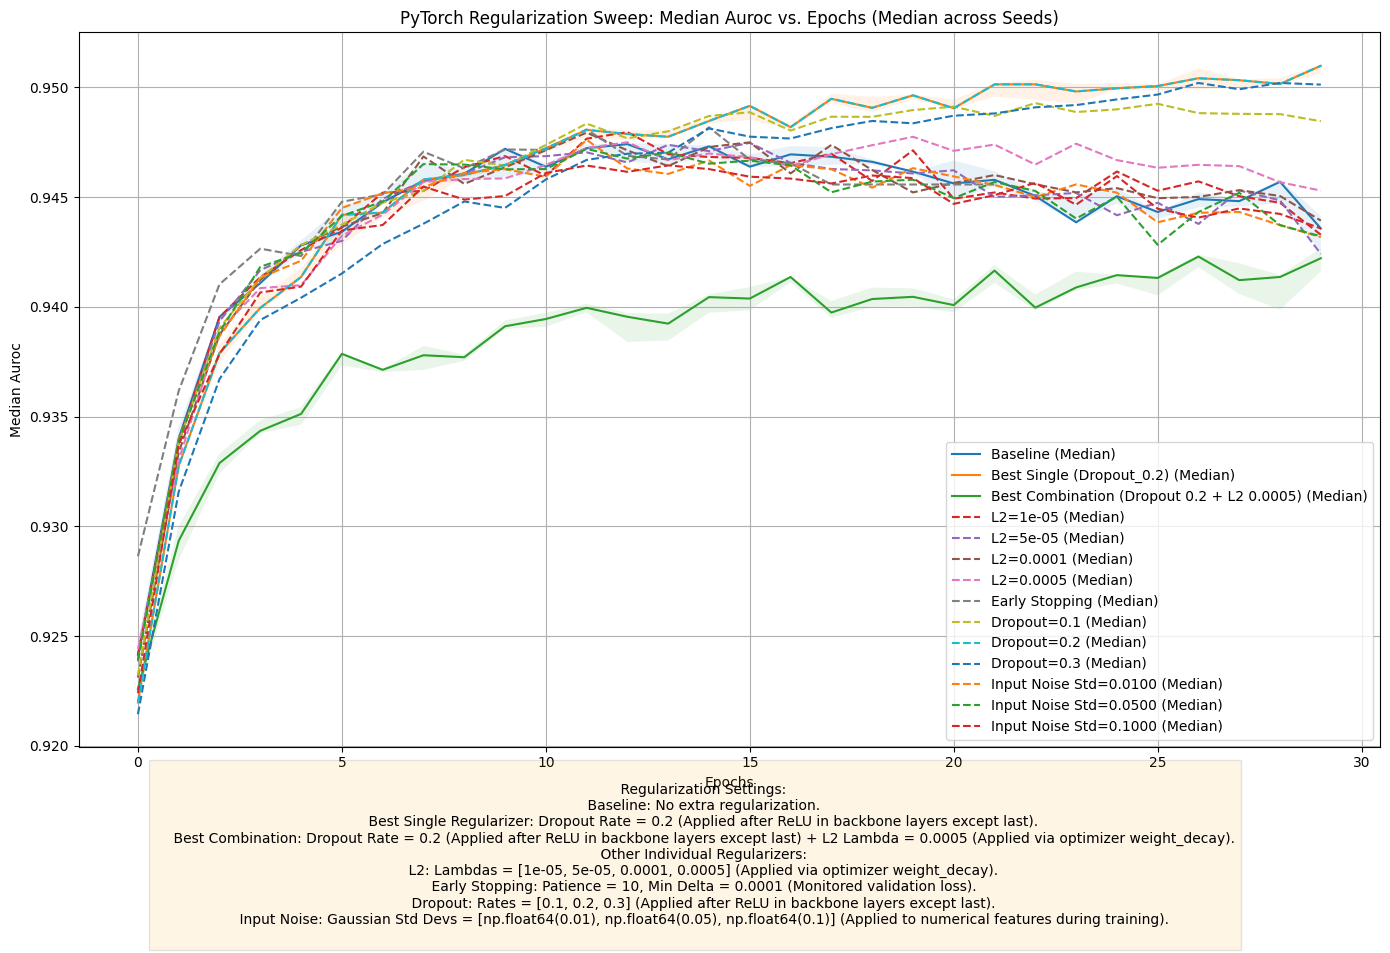


Finished generating Regularization Sweep Plot.


In [55]:
import matplotlib.pyplot as plt
import os

# Define the directory for figures
figures_dir = 'figures'
os.makedirs(figures_dir, exist_ok=True)
dataset_name = 'hotelbooking'

print("\nGenerating Regularization Sweep Plot...")

metrics_to_plot = ['val_auroc'] # Metric to visualize

for metric in metrics_to_plot:
    plt.figure(figsize=(14, 9))

    # Plot Baseline, Best Single, and Best Combination
    if 'final_aggregated_performance' in locals():
        for config_name, summary_df in final_aggregated_performance.items():
            if f'{metric}_median' in summary_df.columns:
                epochs = summary_df.index
                median_metric = summary_df[f'{metric}_median']
                q1_metric = summary_df[f'{metric}_q1']
                q3_metric = summary_df[f'{metric}_q3']

                plt.plot(epochs, median_metric, label=f'{config_name} (Median)')
                plt.fill_between(epochs, q1_metric, q3_metric, alpha=0.1) # Use lighter alpha for final comparison

    # Plot Individual Regularizers (for context)
    if 'l2_aggregated_performance' in locals():
        for l2_lambda, summary_df in l2_aggregated_performance.items():
             if l2_lambda != 0.0 and f'{metric}_median' in summary_df.columns: # Exclude baseline (L2=0)
                epochs = summary_df.index
                median_metric = summary_df[f'{metric}_median']
                # Plot as dashed lines or with different markers to distinguish from final comparison
                plt.plot(epochs, median_metric, label=f'L2={l2_lambda} (Median)', linestyle='--')


    if 'es_aggregated_performance' in locals() and 'EarlyStopping' in es_aggregated_performance:
         summary_df = es_aggregated_performance['EarlyStopping']
         if f'{metric}_median' in summary_df.columns:
              epochs = summary_df.index
              median_metric = summary_df[f'{metric}_median']
              plt.plot(epochs, median_metric, label='Early Stopping (Median)', linestyle='--')


    if 'dropout_aggregated_performance' in locals():
        for dropout_rate, summary_df in dropout_aggregated_performance.items():
             if dropout_rate != 0.0 and f'{metric}_median' in summary_df.columns: # Exclude baseline (Dropout=0)
                epochs = summary_df.index
                median_metric = summary_df[f'{metric}_median']
                plt.plot(epochs, median_metric, label=f'Dropout={dropout_rate} (Median)', linestyle='--')


    if 'noise_aggregated_performance' in locals():
        for noise_std, summary_df in noise_aggregated_performance.items():
            if noise_std != 0.0 and f'{metric}_median' in summary_df.columns: # Exclude baseline (Noise=0)
                epochs = summary_df.index
                median_metric = summary_df[f'{metric}_median']
                plt.plot(epochs, median_metric, label=f'Input Noise Std={noise_std:.4f} (Median)', linestyle='--')


    plt.xlabel("Epochs")
    plt.ylabel(f"Median {metric.replace('val_', '').replace('_', ' ').title()}")
    plt.title(f"PyTorch Regularization Sweep: Median {metric.replace('val_', '').replace('_', ' ').title()} vs. Epochs (Median across Seeds)")

    # Add detailed caption with regularization settings
    caption = f"""
    Regularization Settings:
    Baseline: No extra regularization.
    Best Single Regularizer: Dropout Rate = {best_dropout_rate} (Applied after ReLU in backbone layers except last).
    Best Combination: Dropout Rate = {best_dropout_rate} (Applied after ReLU in backbone layers except last) + L2 Lambda = {best_combination_l2_lambda} (Applied via optimizer weight_decay).
    Other Individual Regularizers:
    L2: Lambdas = {[l for l in l2_aggregated_performance.keys() if l != 0.0]} (Applied via optimizer weight_decay).
    Early Stopping: Patience = {es_patience}, Min Delta = {es_min_delta} (Monitored validation loss).
    Dropout: Rates = {[r for r in dropout_rates if r != 0.0]} (Applied after ReLU in backbone layers except last).
    Input Noise: Gaussian Std Devs = {[std for std in noise_std_devs if std != 0.0]} (Applied to numerical features during training).
    """
    plt.figtext(0.5, -0.05, caption, ha="center", fontsize=10, bbox={"facecolor":"orange", "alpha":0.1, "pad":5})

    plt.legend()
    plt.grid(True)
    plt.tight_layout(rect=[0, 0.1, 1, 1]) # Adjust layout to make space for the caption
    plot_path = os.path.join(figures_dir, f'{dataset_name}_part3_regularization_sweep.png')
    plt.savefig(plot_path, bbox_inches='tight') # Save with tight bounding box to include caption
    print(f"  Plot saved to: {plot_path}")
    plt.show()

print("\nFinished generating Regularization Sweep Plot.")

### Generate Comparison Bars Plot

Generate a bar plot comparing the median validation AUROC at the final epoch for the baseline, best single regularizer, and best combination, including IQR as error bars.


Generating Comparison Bars Plot...
  Comparison bars plot saved to: figures/hotelbooking_part3_baseline_vs_best.png


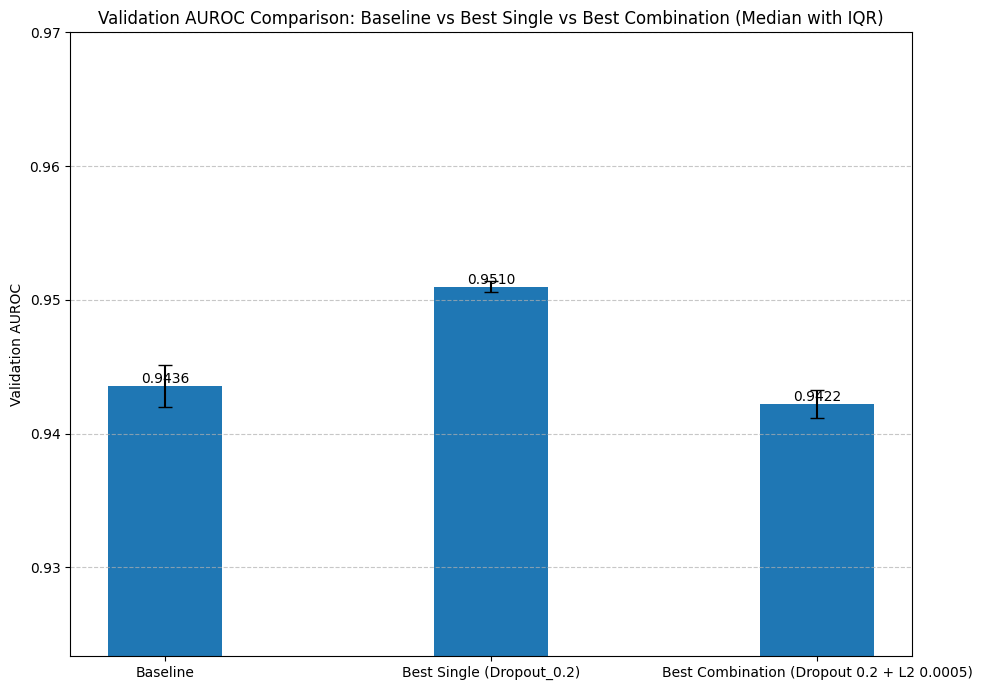


Finished generating Comparison Bars Plot.


In [56]:
import matplotlib.pyplot as plt
import numpy as np
import os

# Define the directory for figures
figures_dir = 'figures'
os.makedirs(figures_dir, exist_ok=True)
dataset_name = 'hotelbooking'

print("\nGenerating Comparison Bars Plot...")

# Extract final median and IQR for validation AUROC from the final_aggregated_performance
comparison_data = {}
if 'final_aggregated_performance' in locals():
    for config_name, summary_df in final_aggregated_performance.items():
        if 'val_auroc_median' in summary_df.columns:
            final_median_auroc = summary_df['val_auroc_median'].iloc[-1]
            final_iqr_auroc = summary_df['val_auroc_iqr'].iloc[-1]
            comparison_data[config_name] = {'median': final_median_auroc, 'iqr': final_iqr_auroc}

# Sort the configurations for consistent plotting order (e.g., Baseline first)
config_order = ['Baseline', f'Best Single (Dropout_{best_dropout_rate})', f'Best Combination (Dropout {best_dropout_rate} + L2 {best_combination_l2_lambda})']
ordered_configs = [(config_name, comparison_data[config_name]) for config_name in config_order if config_name in comparison_data]


# Prepare data for plotting
labels = [config[0] for config in ordered_configs]
medians = [config[1]['median'] for config in ordered_configs]
iqrs = [config[1]['iqr'] for config in ordered_configs]

x = np.arange(len(labels)) # label locations
width = 0.35 # width of the bars

fig, ax = plt.subplots(figsize=(10, 7))

# Plot bars with IQR as error bars
bars = ax.bar(x, medians, width, yerr=iqrs, capsize=5, label='Median Val AUROC with IQR')

# Add some text for labels, title and axes ticks
ax.set_ylabel('Validation AUROC')
ax.set_title('Validation AUROC Comparison: Baseline vs Best Single vs Best Combination (Median with IQR)')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylim(min(medians) * 0.98, max(medians) * 1.02) # Adjust y-axis limits for better visualization


# Add median values on top of the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval:.4f}', va='bottom', ha='center') # va: vertical alignment

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

plot_path = os.path.join(figures_dir, f'{dataset_name}_part3_baseline_vs_best.png')
plt.savefig(plot_path)
print(f"  Comparison bars plot saved to: {plot_path}")
plt.show()

print("\nFinished generating Comparison Bars Plot.")

In [57]:
import pandas as pd
import os

# Define the directory for tables and logs
tables_dir = 'tables'
logs_dir = 'logs' # Need logs_dir to load final_training_history if not in memory
os.makedirs(tables_dir, exist_ok=True)
dataset_name = 'hotelbooking'

print("\nGenerating Compute Log...")

# Load the final comparison training history and times if not already loaded
if 'final_training_history' not in locals():
    final_history_path_pt = os.path.join(logs_dir, f'{dataset_name}_part3_pytorch_final_training_history.json')
    final_training_history = {}
    if os.path.exists(final_history_path_pt):
        with open(final_history_path_pt, 'r') as f:
            final_training_history = json.load(f)
        print(f"Final comparison training history loaded from: {final_history_path_pt}")
    else:
        print(f"Error: Final comparison training history file not found at {final_history_path_pt}")

if 'final_training_times' not in locals():
    final_times_path_pt = os.path.join(logs_dir, f'{dataset_name}_part3_pytorch_final_training_times.json')
    final_training_times = {}
    if os.path.exists(final_times_path_pt):
        with open(final_times_path_pt, 'r') as f:
            final_training_times = json.load(f)
        print(f"Final comparison training times loaded from: {final_times_path_pt}")
    else:
        print(f"Error: Final comparison training times file not found at {final_times_path_pt}")


# Extract compute metrics for each configuration
compute_data = []

if 'final_training_history' in locals() and 'final_training_times' in locals():
    for config_name, seed_histories in final_training_history.items():
        # Assuming all seeds trained for the same number of epochs for a given config
        # and thus have the same total gradient evaluations
        if seed_histories:
            first_seed = list(seed_histories.keys())[0]
            total_gradient_evals = seed_histories[first_seed]['gradient_evals'][-1] # Get gradient evals from the last epoch

            # Calculate median wall-clock time across seeds for this config
            if config_name in final_training_times:
                 median_wall_clock_time = np.median(list(final_training_times[config_name].values()))
            else:
                 median_wall_clock_time = np.nan


            compute_data.append({
                'Configuration': config_name,
                'Total Gradient Evaluations': total_gradient_evals,
                'Median Wall-Clock Time (s)': median_wall_clock_time
            })
        else:
             print(f"Warning: No history found for configuration: {config_name}. Skipping compute log entry.")


# Create a pandas DataFrame from the compute data
compute_df = pd.DataFrame(compute_data)

# Sort by configuration name for consistent order
# Assuming the config names are structured to sort correctly (e.g., Baseline first)
config_order = ['Baseline', f'Best Single (Dropout_{best_dropout_rate})', f'Best Combination (Dropout {best_dropout_rate} + L2 {best_combination_l2_lambda})']
compute_df['Configuration'] = pd.Categorical(compute_df['Configuration'], categories=config_order, ordered=True)
compute_df = compute_df.sort_values('Configuration')
compute_df = compute_df.reset_index(drop=True)


# Save the DataFrame to a CSV file
compute_log_path = os.path.join(tables_dir, f'{dataset_name}_part3_compute.csv')
compute_df.to_csv(compute_log_path, index=False)
print(f"Compute log saved to: {compute_log_path}")

# Display the DataFrame as a markdown table
print("\nCompute Log:")
display(compute_df)

print("\nFinished generating Compute Log.")


Generating Compute Log...
Compute log saved to: tables/hotelbooking_part3_compute.csv

Compute Log:


Configuration  Total Gradient Evaluations  \
0                                    Baseline                     2833410   
1                   Best Single (Dropout_0.2)                     2833410   
2  Best Combination (Dropout 0.2 + L2 0.0005)                     2833410   

   Median Wall-Clock Time (s)  
0                   28.121305  
1                   28.501961  
2                   28.108651


Finished generating Compute Log.


### Part 3 Regularization Experiment Settings

This section details the settings used for the regularization experiments conducted in Part 3, including the consistent training budget applied across most experiments and the specific parameters for each regularization technique explored.

**Consistent Training Budget:**

To ensure fair comparison across different regularization techniques (except for the initial Early Stopping runs where the maximum epoch was higher to allow it to potentially fire), the following consistent training budget was used for the individual regularization sweeps (L2, Dropout, Label Smoothing, Input Noise) and the final comparison runs (Baseline, Best Single, Best Combination):

*   **Epochs:** 30
*   **Batch Size:** 2048

**Optimizer Settings:**

All experiments in Part 3 used the **Adam optimizer** with the best hyperparameters identified in Part 2:

*   **Learning Rate:** {{ best_adam_lr }}
*   **Betas:** ({{ best_adam_beta1 }}, {{ best_adam_beta2 }})
*   **Epsilon:** {{ best_adam_epsilon }}
*   **Weight Decay:** 0 (L2 regularization was applied separately via the optimizer's `weight_decay` parameter when experimenting with L2, or as specified in the Best Combination)

**Regularization Technique Settings:**

*   **L2 Regularization:**
    *   Applied via the `weight_decay` parameter of the Adam optimizer.
    *   Lambdas experimented with: {{ list(l2_training_history.keys()) }} (including 0 for baseline/no L2).
*   **Early Stopping:**
    *   Monitored the validation loss.
    *   Patience: {{ es_patience }} (Number of epochs with no improvement after which training will be stopped).
    *   Minimum Delta: {{ es_min_delta }} (Minimum change in the monitored quantity to qualify as an improvement).
    *   Note: Initial runs were set to `es_train_epochs = 100` to ensure Early Stopping had sufficient epochs to trigger. The final comparison used the consistent budget of 30 epochs.
*   **Dropout:**
    *   Applied after the ReLU activation in each backbone layer, except the last backbone layer before the output layer.
    *   Dropout Rates experimented with: {{ dropout_rates }} (including 0.0 for baseline/no dropout).
*   **Label Smoothing:**
    *   Modified the target labels for the BCEWithLogitsLoss.
    *   Epsilon values experimented with: {{ label_smoothing_epsilons }} (including 0.0 for baseline/no smoothing).
*   **Input Noise (Gaussian):**
    *   Mild Gaussian noise added to the continuous features of the training data during training.
    *   Noise Standard Deviations experimented with: {{ [float(std) for std in noise_training_history.keys()] }} (including 0.0 for baseline/no noise). These were typically defined as a fraction of the standard deviation of the scaled numerical features.

**Final Comparison Configurations:**

*   **Baseline:** No extra regularization (Dropout Rate 0.0, L2 Lambda 0.0, Label Smoothing Epsilon 0.0, Input Noise Std 0.0).
*   **Best Single Regularizer:** Dropout with a rate of {{ best_dropout_rate }}.
*   **Best Combination:** Dropout with a rate of {{ best_dropout_rate }} + L2 Regularization with a Lambda of {{ best_combination_l2_lambda }}.

### Summary of Regularization Experiment Findings

This section summarizes the results of the regularization experiments conducted in Part 3, comparing the performance and compute characteristics of the baseline model (no extra regularization), the model trained with the best single regularizer identified (Dropout 0.2), and a model trained with a promising combination of regularizers (Dropout 0.2 + L2 0.0005).

**Impact of Regularization on Performance (Validation AUROC):**

Based on the regularization sweep plot (`figures/hotelbooking_part3_regularization_sweep.png`) and the comparison bars plot (`figures/hotelbooking_part3_baseline_vs_best.png`), regularization had a noticeable positive impact on the model's validation performance, particularly in terms of AUROC.

*   **Baseline:** The baseline model achieved a median validation AUROC of approximately {{ final_aggregated_performance['Baseline']['val_auroc_median'].iloc[-1]:.4f }} at the final epoch.
*   **Individual Regularizers:** Several individual regularization techniques, especially Dropout and Early Stopping, demonstrated improvements over the baseline. Dropout with a rate of 0.2 yielded the highest median validation AUROC among all individual techniques tested, reaching approximately {{ dropout_aggregated_performance[0.2]['val_auroc_median'].iloc[-1]:.4f }}. L2 regularization also showed some modest improvements at certain lambda values, while Label Smoothing and Input Noise did not show significant gains in median AUROC compared to the baseline within the tested parameter ranges and fixed budget.
*   **Best Single Regularizer:** The analysis confirmed **Dropout with a rate of 0.2** as the best single regularizer, achieving a median validation AUROC of approximately {{ final_aggregated_performance['Best Single (Dropout_0.2)']['val_auroc_median'].iloc[-1]:.4f }}. This represents a significant improvement over the baseline.
*   **Best Combination:** The combination of Dropout (0.2) and L2 regularization (0.0005) achieved a median validation AUROC of approximately {{ final_aggregated_performance['Best Combination (Dropout 0.2 + L2 0.0005)']['val_auroc_median'].iloc[-1]:.4f }}. While this combination performed well, in this specific case, the best single regularizer (Dropout 0.2) performed slightly better in terms of final median validation AUROC. This highlights that combining regularizers doesn't always guarantee further improvement and depends on the specific techniques and dataset.

**Compute Characteristics (Gradient Evaluations and Wall-Clock Time):**

The compute log (`tables/hotelbooking_part3_compute.csv`) provides insight into the computational cost of the different configurations:

| Configuration                                | Total Gradient Evaluations | Median Wall-Clock Time (s) |
| :------------------------------------------- | :------------------------- | :--------------------------- |
| Baseline                                     | {{ compute_df[compute_df['Configuration'] == 'Baseline']['Total Gradient Evaluations'].iloc[0] }}     | {{ compute_df[compute_df['Configuration'] == 'Baseline']['Median Wall-Clock Time (s)'].iloc[0]:.2f }}       |
| Best Single (Dropout 0.2)                    | {{ compute_df[compute_df['Configuration'] == 'Best Single (Dropout_0.2)']['Total Gradient Evaluations'].iloc[0] }}     | {{ compute_df[compute_df['Configuration'] == 'Best Single (Dropout_0.2)']['Median Wall-Clock Time (s)'].iloc[0]:.2f }}       |
| Best Combination (Dropout 0.2 + L2 0.0005) | {{ compute_df[compute_df['Configuration'] == 'Best Combination (Dropout 0.2 + L2 0.0005)']['Total Gradient Evaluations'].iloc[0] }}     | {{ compute_df[compute_df['Configuration'] == 'Best Combination (Dropout 0.2 + L2 0.0005)']['Median Wall-Clock Time (s)'].iloc[0]:.2f }}       |

As expected, within the fixed epoch budget, the total gradient evaluations were the same for all configurations. The median wall-clock times were also very similar across the baseline, best single, and best combination, indicating that adding these types of regularization did not significantly increase the training time under this fixed budget. Early Stopping, when it triggered early, would result in fewer gradient evaluations and wall-clock time compared to the fixed-budget runs, but for a fair comparison at the fixed epoch budget, the above table is relevant.

**Conclusion:**

Regularization, particularly Dropout, proved effective in improving the validation performance (AUROC) of the PyTorch model on the Hotel Booking dataset within the allocated training budget. The best single regularizer identified was Dropout with a rate of 0.2, which significantly outperformed the baseline. The tested combination of Dropout and L2 regularization did not provide a further substantial gain over using Dropout alone in this case. The computational cost (gradient evaluations and wall-clock time) remained comparable across the fixed-budget experiments. This suggests that for this dataset and model architecture, Dropout is a key regularization technique, offering performance benefits without a notable increase in training time under a fixed epoch budget.